In [1]:
#load package
.libPaths(c("/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3/envs/r4.1.2/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3_2/envs/Rsplot/lib/R/library"))
library(data.table)
library(qs)
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(circlize)
library(ggh4x)
library(ggtranscript)
library(khroma)  
library(bambu)
library(ggdensity)
library(Seurat)
library(scCustomize)
library(ComplexUpset)
library(ComplexHeatmap)
library(randomcoloR)

qs 0.25.5

Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.3.3”

Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘p

In [2]:
#load data
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")
MySplit = function(str,sep, n){
  return(unlist(lapply(strsplit(str,sep),"[[",n)))
}
cellan = read.csv("../ref/cell_type_type20230220-macaque1-contour2_v1.csv")
cellan = unique(cellan[,c("subclass","class")])
areaan = read.csv("../ref/area_annotation.csv")
gtf = rtracklayer::import("ref/bambu_extended_annotations_novelname.gtf")
areaan = unique(areaan[c("L0","L3")])
colnames(areaan) = c("lobe","area")
areaan[areaan$area == "1/2",]$area = "1|2"
gtfh = rtracklayer::import("ref/bambu_extended_annotations_novelname.gtf")

In [ ]:
modelcoef2 = qread("data/dtu_analysis/region_subclass_isoform_model_tri_filterlayer_24_11_1.qs")
modelcoef2$group = modelcoef2$areatr
modelcoef2[modelcoef2$areatr == "cellm",]$group = "cell"
modelcoef2[modelcoef2$areatr == "lobem",]$group = "lobe"
modelcoef2[modelcoef2$areatr == "layerm",]$group = "layer"
head(modelcoef2)
colnames(modelcoef2)[4] = "pvalue"
modelcoef.hub = modelcoef2[modelcoef2$group %in% c("cell","lobe","layer"),]
modelcoef.hub = dcast(modelcoef.hub,gene_id~group,value.var = "pvalue",fun.aggregate = sum)
modelmx1.hub = modelcoef.hub
modelmx1.hub$sig <- sapply(1:nrow(modelmx1.hub), function(i) {
  significant_cols <- names(modelmx1.hub)[-1][modelmx1.hub[i, -1] < 0.05]
  paste(significant_cols, collapse = "-")
})
head(modelmx1.hub)
colnames(modelmx1.hub)[5] = "areatr"
unique(modelmx1.hub$areatr)

In [3]:
#fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_delete_multiread_24_09_04.qs")
isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_cor_24_09_04.qs")

In [4]:
refgdf = read.csv("ref/disease_gene/Total_gene_list_summary_25_03_19.csv")

In [301]:
fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_delete_multiread_24_09_04.qs")
#fsraw.cor = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),]
#longbed = qread("ref/long_read_mapping_total_rawnano_total_fil_24_11_12.qs")

In [286]:
longbed = qread("ref/long_read_mapping_total_rawnano_total_fil_24_11_12.qs")

In [ ]:
unique(isosigls$subcortical$areatr)

In [5]:
data6s = list()
data6s$ref = refgdf

In [5]:
suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OPC','OLG','MG','EC','VLMC')
regionorder = c("29","30","23a","23b","31","23c","1|2","PE","PEa","VIP","LIPv","LIPd","PG","7op","CM","AI","CL","CPB","TPO",
               "PGa","FST","V4t","V4","TEO","TEpd","TEpv","TFO","V3v","V2","v23b")
lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
layerorder = c("l1","l2","l3","l4","l5","l6")
subcororder = c('Cerebellum','Cortex','Hippocampus','Midbrain','Pons','Striatum','Ventricle')

In [7]:
FishEnrich = function(geneset,funcset,total_genes){
    drugovl = intersect(unique(funcset),geneset)
    geneset_size <- length(geneset)    # 感兴趣的基因集大小
    functional_category_size <- length(unique(funcset))  # 特定功能类别中的基因总数
    both <- length(drugovl)  # 两个集合都包含的基因数量
    #total_genes <- 20000  # 整个基因组中的基因总数

    contingency_table <- matrix(c(both, geneset_size - both, 
                              functional_category_size - both, 
                              total_genes - (geneset_size + functional_category_size - both)), 
                            nrow = 2)

    # 进行Fisher精确检验
    fisher_test_result <- fisher.test(contingency_table)
    # 输出p值
    p_value <- fisher_test_result$p.value

    # 计算富集分数（Enrichment Ratio），这通常是感兴趣的基因集中具有特定功能的基因比例与整个基因组中该功能基因比例的比值
    enrichment_ratio <- (both / geneset_size) / (functional_category_size / total_genes)
    res = data.frame("p.value" = p_value,"enrichscore" = enrichment_ratio,"overlap_size" = both,
                     "term_size" = functional_category_size,"query_size" = geneset_size,
                    "overlap_ratio" = both/functional_category_size)
    return(res)
}


In [8]:
#case plot
BuildPlotBed = function(npclf,nanobed,groupname,geneex,sigtr = NULL){
    readgroup = npclf[npclf$gene_id == geneex,]
    # readgroup = readgroup[readgroup$arealayer %in% paste0("l",1:6),]
    readgroup = unique(readgroup[c("readid","transcript_id","gene_id",
                                   groupname)])
    # readgroup = readgroup %>% group_by(readid) %>% 
    #   mutate(transgroup = 
    #            paste(unique(transcript_id)[order(unique(transcript_id))],
    #                              collapse = "|"))
    readgrt = nanobed[nanobed$name %in% readgroup$readid,]
    readgrt$group = readgroup[match(readgrt$name,
                                    readgroup$readid),
                              groupname]
    # readgrt$transcript_id = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transcript_id"]
    # readgrt$transgroup = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transgroup"]
    
    grtdfl = as.data.frame(readgrt)
    colnames(grtdfl)[ncol(grtdfl)] = "group"
    colnames(grtdfl)[6] = "readid"
    grtdfl = merge(grtdfl,readgroup[c("readid",
                              "transcript_id")],
          by = "readid")
    grtdfl = grtdfl[order(grtdfl$transcript_id,
                          grtdfl$start,grtdfl$end),]
    grtdfl = grtdfl[!is.na(grtdfl$group) &
                      grtdfl$group != "",]
    grtdfl
    grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
    grtdfl = grtdfl %>% group_by(group) %>% 
      mutate(orid = as.numeric(factor(readord,
                                      levels = unique(readord)))) %>%
      mutate(oridnorm = orid/max(orid))
    grtdfl$sig = "black"
    grtdfl[grtdfl$group %in% sigtr, "sig"] = "red"
    return(grtdfl)
}

IsoformReadPlot = function(gtfp, grtdfl, geneex, onlyhub = T,mycolor = NULL){
    library(randomcoloR)
    library(ggbio)
    library(ggtranscript)
    tartrans = gtfp[which(gtfp$gene_id == geneex),]
    tartrans = as.data.frame(tartrans)
    tartrans = tartrans[tartrans$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_id),]
    tartrans$orid = as.numeric(factor(tartrans$transcript_id,levels = unique(tartrans$transcript_id)))
    tartrans$group = NA
    if(onlyhub){
      grtdfl = grtdfl %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
      grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
      grtdfl = grtdfl %>% group_by(group) %>% 
        mutate(orid = as.numeric(factor(readord,
                                        levels = unique(readord)))) %>%
        mutate(oridnorm = orid/max(orid))
      tartrans = tartrans[tartrans$transcript_id %in% grtdfl$transcript_id,]
    }
    # tartrans = merge(tartrans,unique(grtdfl[c("transcript_id",
    #                                           "transgroup")]),
    #                  by = "transcript_id")
    tartranstx = tartrans %>% group_by(transcript_id,orid) %>% 
      summarise(start = min(start),end = max(end))
    tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    
    #facetcol = list()
    #facetcoldf = unique(grtdfl[c("group","sig")])
    #facetcoldf = facetcoldf[order(facetcoldf$group,decreasing = F),]
    #for (i in 1:nrow(facetcoldf)) {
    #  facetcol[[i]] = element_text(color = facetcoldf[i,]$sig)
    #}
    #facetcol[[nrow(facetcoldf)+1]] = element_text(color = "black")
    grtdflin = to_intron(grtdfl,
                     "readord")
    no_of_colors = length(unique(grtdfl$transcript_id)) 
    colorful_palette = distinctColorPalette(no_of_colors) 
    names(colorful_palette) = unique(grtdfl$transcript_id)
    if(!is.null(mycolor)){
        colorful_palette = mycolor
    }

    
    pc = ggplot(grtdfl,aes(x = start,xend = end,
                      y = orid,
                      yend = orid,
                      fill = transcript_id,color = transcript_id)) +
      geom_segment(size = 0.5) +
      geom_segment(data = grtdflin,
                   aes(x = start,xend = end,
                       y = orid,
                       yend = orid),
                   size = 0.03,alpha = 0.5,color = "grey") +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_id,color = transcript_id),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_id"),
                  aes(xstart = start,xend = end,strand = strand),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid,
                    label = transcript_id),
                size = 3, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "top") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      # scale_color_discreterainbow() +
      theme_void() + 
      ggtitle(geneex) +
      theme(legend.position = "none",
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
           strip.placement = "outside",
           plot.title = element_text(hjust = 0.5))
    pc
    
    return(pc)
}
#fsraw.cor = fsraw[fsraw$layer %in% paste0("l",1:6),]
#
IsoformReadPlotTotal = function(fsraw,isosigi,longbed,gtf,geneex,hubtrans = NULL,onlyhub = F,mycolors =NULL){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(transname))
        names(mycolors) = transname
    }
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub,mycolors)
    pci1
    return(pci1)
}

CaseCountPlotBox = function(fsraw,geneex,transname,mycolors = NULL){
    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    if(is.null(mycolors)){
        mycolors = distinctColorPalette(length(unique(npcase1$transcript_id)))
    }
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }
    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      # geom_line(data = npcase1m,aes(x = areatr, y = mean,
      #                              group = transcript_id),
      #           position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + 
    theme(axis.text.x = element_text(angle = 45,vjust = 0.5)) +
    xlab("") + ylab("Isoform read ratio")
    return(pci2)
}

CasePlotTotalClass = function(fsraw,isosigi,gtf,geneex,hubtrans = NULL,markdfb,edgesdf){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    mycolors = distinctColorPalette(length(transname))
    print(mycolors)
    names(mycolors) = transname
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    print(head(grtdfl))
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F,mycolors)
    pci1
#ggexport(p0c1,filename = "processed/figures/f3/bambu_cell_case_NNvsNeuron_CDC42.pdf",
#           width = 6,height = 5)

    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }


    
    npcase1m = npcase1 %>% group_by(areatr,transcript_id) %>% summarise(mean = mean(rate))
    
#library(ggstatsplot)

    pci2 = ggplot(npcase1,
                  aes(x = areatr, y = rate, color = transcript_id)) +
      geom_boxplot() +
      geom_point(data = npcase1m,aes(x = areatr, y = mean,
                                    color = transcript_id),
                 position = position_dodge(0.75)) +
      geom_line(data = npcase1m,aes(x = areatr, y = mean,
                                   group = transcript_id),
                position = position_dodge(0.75)) +
      stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,ref.group = ".all.") + 
      scale_color_manual(values = mycolors) +
      theme_pubr() + xlab("") + ylab("Isoform read ratio")
    
#     pci2 = ggbarplot(npcase1,
#                     x = "areatr", y = "rate", 
#                     fill = "areatr",size = 0.5,
#                     width = 0.7,facet.by = "transcript_id",
#                     add = c("mean_se")) +
#         geom_jitter(data = npcase1,
#                 aes(x = areatr, y = rate),size = 0.3,
#                     width = 0.25) +
#         scale_fill_flatui() +
# #        scale_fill_manual(values = mycolors) +
#         stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,
#                            ref.group = ".all.") + 
#         xlab("") + ylab("Isoform ratio") + labs(fill = "") +
#         theme_pubr() + 
#     theme(axis.text.x = element_blank(),
#          axis.ticks.x = element_blank(),
#           legend.position = "bottom")
#     pci2
    pci3 = MarkerSpPlot(fsraw.cor,markdfb,geneex,hubtrans,edgesdf,200)
    #pci3 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,mycolors,hubtrans)
    
    pci = ggarrange(ggarrange(pci1,pci2,widths = c(1.5,2),ncol = 1),pci3,nrow = 1)
    return(pci)
}



In [9]:
theme_presentation<- function(base_size = 16, base_family = "") {
  # Starts with theme_grey and then modify some parts
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      strip.background = element_blank(),
      strip.text.x = element_text(size=16,colour="white"),
      strip.text.y = element_text(size=16,colour="white"),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks =  element_blank(), 
      axis.title.x= element_blank(),
      axis.title.y= element_blank(),
      panel.background = element_rect(fill="black"), 
      panel.border =element_blank(),  
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.margin = unit(1.0, "lines"), 
      plot.background = element_rect(fill="black"), 
      plot.title =element_text(size=16,colour="white"), 
      # plot.margin = unit(c(1,  1, 1, 1), "lines"),
      legend.background=element_rect(fill='black'),
      legend.title=element_text(size=12,colour="white"),
      legend.text=element_text(size=12,colour="white"),
      legend.key = element_rect( fill = 'black'),
      # legend.key.size = unit(c(0, 0), "lines"),
      axis.line.x = element_blank(),
      axis.line.y = element_blank()
    )
}


### Disease gene list build

In [458]:
library(readxl)    
  multiplesheets <- function(fname) {
    
    # getting info about all excel sheets
    sheets <- readxl::excel_sheets(fname)
    tibble <- lapply(sheets, function(x) readxl::read_excel(fname, sheet = x))
    data_frame <- lapply(tibble, as.data.frame)
    
    # assigning names to data frames
    names(data_frame) <- sheets
    
    # print data frame
    #print(data_frame)
    return(data_frame)
  }

In [459]:
library(readxl)
df.ASD.ra = read_excel("ref/disease_gene/41588_2022_1104_MOESM3_ESM.xlsx", sheet = 15)
colnames(df.ASD.ra)

df.SCZ.ra = read_excel("ref/disease_gene/41586_2022_4556_MOESM3_ESM.xlsx", sheet = 3)
colnames(df.SCZ.ra)
df.ASD = read.table("ref/disease_gene/ASC_gene_results.tsv",header = T)
colnames(df.ASD)
df.DDD = read_excel("ref/disease_gene/41586_2020_2832_MOESM4_ESM.xlsx")
colnames(df.DDD)
path = "ref/disease_gene/science.aat8127/aat8127_table_s4.xlsx"
disref = multiplesheets(path)
colnames(disref$SCZ.SMR)

[1] "gene"                      "gene_gencodeV33"          
 [3] "gene_id"                   "chromosome"               
 [5] "pLI"                       "LOEUF"                    
 [7] "FDR_ASD"                   "FDR_DD"                   
 [9] "DN_count_asd"              "DN_count_dd"              
[11] "C statistic"               "Posterior_probability_ASD"
[13] "Expressed"

[1] "Gene Symbol"                   "Gene Name"                    
 [3] "Case PTV"                      "Ctrl PTV"                     
 [5] "Case mis3"                     "Ctrl mis3"                    
 [7] "Case mis2"                     "Ctrl mis2"                    
 [9] "P ca/co (Class 1)"             "P ca/co (Class 2)"            
[11] "P ca/co (comb)"                "De novo PTV"                  
[13] "De novo mis3"                  "De novo mis2"                 
[15] "P de novo"                     "P meta"                       
[17] "Q meta"                        "OR (PTV)"                     
[19] "OR (Class I)"                  "OR (Class II)"                
[21] "Case syn"                      "Ctrl syn"                     
[23] "P ca/co (syn)"                 "P meta, no gnomAD"            
[25] "Case/Ctrl PTV, no gnomAD"      "Case/Ctrl mis3, no gnomAD"    
[27] "Case/Ctrl mis2, no gnomAD"     "P ca/co (Class I), no gnomAD" 
[29] "P ca/co (Class II), no gnomAD" "P ca/co (comb), no gnomAD"

[1] "gene_id"       "group"         "xcase_dn_ptv"  "xcont_dn_ptv" 
 [5] "xcase_dn_misb" "xcont_dn_misb" "xcase_dn_misa" "xcont_dn_misa"
 [9] "xcase_dbs_ptv" "xcont_dbs_ptv" "xcase_swe_ptv" "xcont_swe_ptv"
[13] "xcase_tut"     "xcont_tut"     "qval"

[1] "symbol"                  "hgnc_id"                
 [3] "chr"                     "diagnostic_category"    
 [5] "coding_sequence_variant" "frameshift_variant"     
 [7] "inframe_deletion"        "inframe_insertion"      
 [9] "initiator_codon_variant" "missense_variant"       
[11] "splice_acceptor_variant" "splice_donor_variant"   
[13] "stop_gained"             "stop_lost"              
[15] "stop_retained_variant"   "synonymous_variant"     
[17] "PTV_enrichment_p"        "power_median"           
[19] "s_het"                   "observed_full"          
[21] "expected_full"           "enrich_all_p_full"      
[23] "enrich_mis_p_full"       "cluster_p_full"         
[25] "denovoWEST_p_full"       "observed_ud"            
[27] "expected_ud"             "enrich_all_p_ud"        
[29] "enrich_mis_p_ud"         "cluster_p_ud"           
[31] "denovoWEST_p_ud"         "denovoWEST_p_ud_synmod" 
[33] "gnomad_oe_syn"           "significant"

New names:
• `` -> `...2`
Warning message:
"Expecting numeric in T5551 / R5551C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5875 / R5875C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T9464 / R9464C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T12786 / R12786C20: got '8.80999999191014e-316'"
Warning message:
"Expecting numeric in AB12817 / R12817C28: got 'NA'"
Warning message:
"Expecting numeric in AC12817 / R12817C29: got 'NA'"
Warning message:
"Expecting numeric in T13232 / R13232C20: got '6.8399999999901e-313'"
Warning message:
"Expecting numeric in T4935 / R4935C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5248 / R5248C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T8688 / R8688C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T9903 / R9903C20: got '3.35e-310'"
Warning message:
"Expecting numeric in T11857 / R11857C20: got '8.809

[1] "GWAS"        "probeID"     "ProbeChr"    "Gene"        "Probe_bp"   
 [6] "topSNP"      "topSNP_chr"  "topSNP_bp"   "A1"          "A2"         
[11] "Freq"        "b_GWAS"      "se_GWAS"     "p_GWAS"      "b_eQTL"     
[16] "se_eQTL"     "p_eQTL"      "b_SMR"       "se_SMR"      "p_SMR"      
[21] "p_SMR_multi" "p_HEIDI"     "nsnp_HEIDI"

In [ ]:
colnames(disref$SCZ.TWAS)

In [460]:
#ASD & NDD

Dsgdf = NULL
df.ASD.ra = read_excel("ref/disease_gene/41588_2022_1104_MOESM3_ESM.xlsx", sheet = 15)
#head(df.ASD.ra)
Dsgdf.ASD.talk = data.frame("gene_id" = unique(df.ASD.ra[df.ASD.ra$FDR_ASD < 0.01,]$gene),
                            #"source" = "ASD.PTV",
                            "source" = "ASD.Talkowski",
                            "group" = "ASD")

Dsgdf.NDD.talk = data.frame("gene_id" = unique(df.ASD.ra[df.ASD.ra$FDR_DD < 0.01,]$gene),
                           # "source" = "NDD.PTV",
                            "source" = "NDD.Talkowski",
                            "group" = "NDD")
#SCZ
df.SCZ.ra = read_excel("ref/disease_gene/41586_2022_4556_MOESM3_ESM.xlsx", sheet = 3)
Dsgdf.SCZ = data.frame("gene_id" = df.SCZ.ra[1:10,]$`Gene Symbol`,
                      # "source" = "SCZ.PTV",
                       "source" = "SCZ.Daly",
                       "group" = "SCZ")

#BIP
df.BIP = read.csv("ref/disease_gene/Bipolar_Disorder_results_2024_10_30_10_36_25.csv")
library(org.Hs.eg.db)
gene_info = AnnotationDbi::select(org.Hs.eg.db, keys = df.BIP$Gene, columns = c("SYMBOL"), keytype = "ENSEMBL")
head(gene_info)
colnames(gene_info) = c("Gene","gene_symbol")
df.BIP = merge(df.BIP,gene_info,by = "Gene")
#head(df.BIP)
hubgenei1 = df.BIP[df.BIP$`Damaging.Missense.Fisher.p.val` < 0.01 & !is.na(df.BIP$`Damaging.Missense.Fisher.p.val`),]$gene_symbol
hubgenei2 = df.BIP[df.BIP$`PTV.Fisher.p.val` < 0.01 & !is.na(df.BIP$`PTV.Fisher.p.val`),]$gene_symbol
hubgenei = c(hubgenei1,hubgenei2)
Dsgdf.BIP = data.frame("gene_id" = hubgenei,
                       #"source" = "BIP.PTV",
                       "source" = "BIP.Neale",
                       "group" = "BIP")
#EPI
df.EPI = read.table("ref/disease_gene/Epi25_gene_results.tsv",header = T)
head(df.EPI)
gene_info = AnnotationDbi::select(org.Hs.eg.db, keys = df.EPI$gene_id, columns = c("SYMBOL"), keytype = "ENSEMBL")
colnames(gene_info) = c("gene_id","gene_symbol")
df.EPI = merge(df.EPI,gene_info,by = "gene_id")
df.EPI = df.EPI[df.EPI$group == "EPI",]
hubgenei1 = df.EPI[df.EPI$`damaging_missense_pval` < 0.01 & !is.na(df.EPI$`damaging_missense_pval`),]$gene_symbol
hubgenei2 = df.EPI[df.EPI$`ptv_pval` < 0.01 & !is.na(df.EPI$`ptv_pval`),]$gene_symbol
hubgenei = unique(c(hubgenei1,hubgenei2))
length(hubgenei)
Dsgdf.EPI= data.frame("gene_id" = hubgenei,
                     # "source" = "EPI.PTV",
                      "source" = "EPI.Neale",
                      "group" = "EPI")
#ASC 2
df.ASD = read.table("ref/disease_gene/ASC_gene_results.tsv",header = T)
gene_info = AnnotationDbi::select(org.Hs.eg.db, keys = df.ASD$gene_id, columns = c("SYMBOL"), keytype = "ENSEMBL")
colnames(gene_info) = c("gene_id","gene_symbol")
df.ASD = merge(df.ASD,gene_info,by = "gene_id")
head(df.ASD)
hubgenei = unique(df.ASD[df.ASD$qval < 0.01 & !is.na(df.ASD$qval),]$gene_symbol)
length(hubgenei)
Dsgdf.ASD = data.frame("gene_id" = hubgenei,
                       #"source" = "ASD.PTV",
                       "source" = "ASD.Buxbaum",
                       "group" = "ASD")
#DDD
df.DDD = read_excel("ref/disease_gene/41586_2020_2832_MOESM4_ESM.xlsx")
df.DDD = df.DDD[df.DDD$significant == TRUE, ]
hubgenei = unique(df.DDD$symbol)
length(unique(hubgenei))
Dsgdf.DDD = data.frame("gene_id" = hubgenei,
                       #"source" = "DDD.PTV",
                       "source" = "DDD.Retterer",
                       "group" = "DDD")
Dsgdf = rbind(Dsgdf.ASD.talk,Dsgdf.NDD.talk,Dsgdf.SCZ,Dsgdf.BIP,Dsgdf.EPI,Dsgdf.ASD,Dsgdf.DDD)
Dsgdf %>% group_by(group,source) %>% summarise(genenum = length(unique(gene_id)))
write.csv(Dsgdf,file = "ref/disease_gene/Disease_gene_list_summary_24_10_30.csv",quote = F,row.names = F)

 
path = "ref/disease_gene/science.aat8127/aat8127_table_s4.xlsx"
disref = multiplesheets(path)

disgwas = NULL
#arrange sheets
{
    disrefgls = list()
    disrefgls[[1]] = unique(disref$SCZ.TWAS[disref$SCZ.TWAS$TWAS.P < 0.05 & disref$SCZ.TWAS$DGE.fdr < 0.05,]$gene_name)
    disrefgls[[2]] = unique(disref$ASD.TWAS[disref$ASD.TWAS$TWAS.P < 0.05 & disref$ASD.TWAS$DGE.fdr < 0.05,]$gene_name)
    disrefgls[[3]] = unique(disref$BD.SCZ[disref$BD.SCZ$TWAS.P < 0.05 & disref$BD.SCZ$DGE.fdr < 0.05,]$gene_name)
    disrefgls[[4]] = unique(disref$SCZ.SMR[disref$SCZ.SMR$p_SMR_multi < 0.01 & disref$SCZ.SMR$p_GWAS < 0.01,]$Gene)
    disrefgls[[5]] = unique(disref$BD.SMR[disref$BD.SMR$p_SMR_multi < 0.01 & disref$BD.SMR$p_GWAS < 0.01,]$Gene)
    disrefgls[[6]] = unique(disref$ASD.SMR[disref$ASD.SMR$p_SMR_multi < 0.01 & disref$ASD.SMR$p_GWAS < 0.01,]$Gene)
    names(disrefgls) = c(
    unique(disref$SCZ.TWAS$GWAS)[1],
    unique(disref$ASD.TWAS$GWAS)[1],
    unique(disref$BD.SCZ$GWAS)[1],
    unique(disref$SCZ.SMR$GWAS)[1],
    unique(disref$BD.SCZ$GWAS)[1],
    unique(disref$ASD.SMR$GWAS)[1]
    )
    dgdf = NULL
    sourceid = c("SCZ.TWAS","ASD.TWAS","BD.TWAS","SCZ.GWAS","BD.GWAS","ASD.GWAS")
    diseaseid = c("SCZ","ASD","BD","SCZ","ASD","BD")
    for (i in 1:6) {
      d1i = data.frame("gene_id" = disrefgls[[i]], "source" = sourceid[i],
                       "group" = diseaseid[i])
      disgwas = rbind(disgwas,d1i)
    }
    # queryg = finalsig$combine_df[finalsig$combine_df$group == "subclass",]
    # querygls = list()
    # for (i in unique(queryg$areatr)) {
    #   querygls[[i]] = unique(queryg[queryg$areatr == i,]$gene)
    # }
    # #gene group
    # num_groups1 = length(disrefgls)
    # num_groups2 = length(querygls)
    # jaccard_matrix <- matrix(0, nrow = num_groups1, ncol = num_groups2)
    # for (i in 1:num_groups1) {
    #   for (j in 1:num_groups2) {
    #     jaccard_matrix[i, j] <- calculate_jaccard(disrefgls[[i]], querygls[[j]])
    #   }
    # }
    
    # rownames(jaccard_matrix) <- names(disrefgls)
    # colnames(jaccard_matrix) <- names(querygls)
    # library(pheatmap)
    # pheatmap(jaccard_matrix)
    
}

path = "ref/disease_gene/science.aat8127/aat8127_table_s1.xlsx"
disref = multiplesheets(path)
disdgt = NULL              
{
    d1 = disref$DGE
    d2 = disref$DTU
    d3 = disref$DTE
    d1g = list()
    d2g = list()
    d3g = list()
    d1g$ASD = d1[abs(d1$ASD.log2FC )>0.25 & 
                   d1$ASD.fdr < 0.05,]$gene_name
    d1g$SCZ = d1[abs(d1$SCZ.log2FC)>0.25 & 
                   d1$SCZ.fdr < 0.05,]$gene_name
    d1g$BD = d1[abs(d1$BD.log2FC)>0.25 & 
                  d1$BD.fdr < 0.05,]$gene_name
    
    # d2g$ASD = d2[abs(d2$DTU.ASD.Value)>1 & 
    #                d2$DTU.ASD.FDR < 0.05,]$external_gene_id
    # d2g$SCZ = d2[abs(d2$DTU.SCZ.Value)>1 & 
    #                d2$DTU.SCZ.FDR < 0.05,]$external_gene_id
    # d2g$BD = d2[abs(d2$DTU.BD.Value)>1 & 
    #               d2$DTU.BD.FDR < 0.05,]$external_gene_id

    
    d2g$ASD = d2[abs(d2$DTU.ASD.Value)>1 & 
                   d2$DTU.ASD.p.value < 0.01,]$external_gene_id
    d2g$SCZ = d2[abs(d2$DTU.SCZ.Value)>1 & 
                   d2$DTU.SCZ.p.value < 0.01,]$external_gene_id
    d2g$BD = d2[abs(d2$DTU.BD.Value)>1 & 
                  d2$DTU.BD.p.value < 0.01,]$external_gene_id
    
    d3g$ASD = d3[abs(d3$ASD.log2FC)>1 & 
                   d3$ASD.fdr < 0.05,]$external_gene_id
    d3g$SCZ = d3[abs(d3$SCZ.log2FC)>1 & 
                   d3$SCZ.fdr < 0.05,]$external_gene_id
    d3g$BD = d3[abs(d3$BD.log2FC)>1 & 
                  d3$BD.fdr < 0.05,]$external_gene_id
    
    sourceid = c("ASD","SCZ","BD")
    
    for (i in 1:3) {
      # d1i = data.frame("gene_id" = d1g[[i]], "source" = paste0(sourceid[i],".DGE"),
      #                  "group" = sourceid[i])
      d2i = data.frame("gene_id" = d2g[[i]], "source" = paste0(sourceid[i],".DTU"),
                       "group" = sourceid[i])
      # d3i = data.frame("gene_id" = d3g[[i]], "source" = paste0(sourceid[i],".DTE"),
      #                  "group" = sourceid[i])
      disdgt = rbind(disdgt,d2i)
    }
    
  }
head(disdgt)
disdgt = disdgt[!is.na(disdgt$gene),]  

#load disease splicing gene
# disas = NULL
# {
#     ref.schiz = multiplesheets("ref/disease_gene/Schizophrenia/ncomms14519-s2.xlsx")
#     ref.schiz = ref.schiz$Suppl_Data1
#     colnames(ref.schiz) = ref.schiz[1,]
#     ref.schiz = ref.schiz[-1,] 
      
#     ref.als = list.files(path = "ref/disease_gene/ALS/",pattern = "supp_gr.265298.120_Supplemental_Data*",full.names = T)
#     ref.als = lapply(ref.als, read_xlsx)
#     ref.als = Reduce(function(x,y){return(rbind(x[c("Gene","qvalue")],
#                                                 y[c("Gene","qvalue")]))},ref.als)
    
#     ref.alz1 = multiplesheets("ref/disease_gene/ASD1/NIHMS654938-supplement-10.xlsx")
#     ref.alz1h = ref.alz1$`TableS2-Human`
#     ref.alz1m = ref.alz1$`TableS2-Mouse`
#     colnames(ref.alz1h) = ref.alz1h[1,]
#     ref.alz1h = ref.alz1h[-1,]

#     colnames(ref.alz1m) = ref.alz1m[1,]
#     ref.alz1m = ref.alz1m[-1,]
    
#     ref.alz2 = read.csv("ref/disease_gene/ASD2/SFARI-Gene_genes_07-17-2023release_09-12-2023export.csv")
#     head(ref.alz2)
    
#     diseasels = list("SCZ.AS" = unique(ref.schiz$Gene),
#                      "ALS.AS" = unique(ref.als$Gene),
#                      "ASD.Human.AS" = unique(ref.alz1h$GENE),
#                      "ASD.Mouse.AS" = unique(ref.alz1m$GENE))
#     library(ggvenn)
#     ggvenn(diseasels)
#     groupid = c("SCZ","ALS","ASD","ASD")
#     for (i in 1:4) {
#       disas = rbind(disas,data.frame("gene_id" = diseasels[[i]],
#                                              "source" = names(diseasels)[i],
#                                              "group" = groupid[i]))
#     }
# }
# head(disas)
head(disdgt)
head(disgwas)
#write.csv(diseasedf,file = "ref/disease/disease_gene_arrange.csv",row.names = F)




'select()' returned 1:many mapping between keys and columns



ENSEMBL         SYMBOL 
1 ENSG00000023516 AKAP11 
2 ENSG00000083097 DOP1A  
3 ENSG00000253767 PCDHGA8
4 ENSG00000161681 SHANK1 
5 ENSG00000173769 TOPAZ1 
6 ENSG00000054793 ATP9A

gene_id         group n_cases n_controls damaging_missense_case_count
1 ENSG00000000003 DEE    1938   33444      0                           
2 ENSG00000000003 EPI   20979   33444      0                           
3 ENSG00000000003 GGE    5499   33444      0                           
4 ENSG00000000003 NAFE   9219   33444      0                           
5 ENSG00000000005 DEE    1938   33444      0                           
6 ENSG00000000005 EPI   20979   33444      0                           
  damaging_missense_control_count damaging_missense_pval damaging_missense_OR
1 0                               NA                     NA                  
2 0                               NA                     NA                  
3 0                               NA                     NA                  
4 0                               NA                     NA                  
5 0                               NA                     NA                  
6 0                               NA                     NA                  
  ptv_case_count ptv_control_count ptv_pval ptv_OR 
1 0              4                 0.81663  1.44020
2 1              4                 0.35264  0.43023
3 0              4                 0.70914  0.59502
4 1              4                 0.94254  1.07330
5 1              2                 0.11354  7.16540
6 1              2                 0.92038  1.12100

'select()' returned many:many mapping between keys and columns



[1] 195

'select()' returned 1:many mapping between keys and columns



gene_id         group xcase_dn_ptv xcont_dn_ptv xcase_dn_misb xcont_dn_misb
1 .               All   0            0            0             0            
2 0               All   0            0            0             0            
3 ENSG00000000419 All   0            0            0             0            
4 ENSG00000000457 All   0            0            0             0            
5 ENSG00000000460 All   0            0            0             0            
6 ENSG00000000938 All   0            0            0             0            
  xcase_dn_misa xcont_dn_misa xcase_dbs_ptv xcont_dbs_ptv xcase_swe_ptv
1 0             0             0             0             0            
2 0             0             0             0             0            
3 0             0             1             2             0            
4 0             0             1             1             0            
5 0             0             0             2             1            
6 0             1             0             0             0            
  xcont_swe_ptv xcase_tut xcont_tut qval    gene_symbol
1 0              0        2         0.91586 NA         
2 0              0        0         0.90572 NA         
3 0              0        5         0.92150 DPM1       
4 0              1        2         0.92924 SCYL3      
5 2             10        5         0.86686 FIRRM      
6 0              0        0         0.92270 FGR

[1] 47

[1] 285

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


group source        genenum
1 ASD   ASD.Buxbaum    47    
2 ASD   ASD.Talkowski  83    
3 BIP   BIP.Neale      87    
4 DDD   DDD.Retterer  285    
5 EPI   EPI.Neale     195    
6 NDD   NDD.Talkowski 341    
7 SCZ   SCZ.Daly       10

New names:
• `` -> `...2`
Warning message:
"Expecting numeric in T5551 / R5551C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5875 / R5875C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T9464 / R9464C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T12786 / R12786C20: got '8.80999999191014e-316'"
Warning message:
"Expecting numeric in AB12817 / R12817C28: got 'NA'"
Warning message:
"Expecting numeric in AC12817 / R12817C29: got 'NA'"
Warning message:
"Expecting numeric in T13232 / R13232C20: got '6.8399999999901e-313'"
Warning message:
"Expecting numeric in T4935 / R4935C20: got '7.71236473158186e-321'"
Warning message:
"Expecting numeric in T5248 / R5248C20: got '1.77863632502849e-322'"
Warning message:
"Expecting numeric in T8688 / R8688C20: got '1.76999017622627e-319'"
Warning message:
"Expecting numeric in T9903 / R9903C20: got '3.35e-310'"
Warning message:
"Expecting numeric in T11857 / R11857C20: got '8.809

gene_id source  group
1 CAMK1G  ASD.DTU ASD  
2 MGST1   ASD.DTU ASD  
3 SS18L2  ASD.DTU ASD  
4 RTFDC1  ASD.DTU ASD  
5 TNIP3   ASD.DTU ASD  
6 RELT    ASD.DTU ASD

gene_id source  group
1 CAMK1G  ASD.DTU ASD  
2 MGST1   ASD.DTU ASD  
3 SS18L2  ASD.DTU ASD  
4 RTFDC1  ASD.DTU ASD  
5 TNIP3   ASD.DTU ASD  
6 RELT    ASD.DTU ASD

gene_id  source   group
1 TRIM27   SCZ.TWAS SCZ  
2 SETD8    SCZ.TWAS SCZ  
3 ZNF192P2 SCZ.TWAS SCZ  
4 SF3B1    SCZ.TWAS SCZ  
5 FXR1     SCZ.TWAS SCZ  
6 MDK      SCZ.TWAS SCZ

In [461]:
library(readxl)
all_sheets <- read_excel("ref/human_Brain_drug_target_and_GPCR_20240826.xlsx", sheet = 1)
dggenedf1 = data.frame("gene_id" = unlist(all_sheets[,1]),"source" = "HumanGPCR","group" = "hGPCR")
dggenedf2 = data.frame("gene_id" = unlist(all_sheets[,2]),"source" = "Opentarget-Drugs","group" = "OPD")

tfgene = read.delim("ref/Macaca_fascicularis_TF.txt")
tfgenedf = data.frame("gene_id" = unique(tfgene$Symbol),"source" = "TF.guolab","group" = "TF")
spgene = read.delim("ref/splicing_factor_gene_in_macaca_fas.txt")
spgenedf = data.frame("gene_id" = unique(spgene$Symbol),"source" = "SP","group" = "SP")

rbpgene = read.csv("ref/RBPDB_v1.3.1_proteins_human_2012-11-21.csv",header = F)
rbpgenedf = data.frame("gene_id" = unique(rbpgene$V5),"source" = "RBP.ccbr","group" = "RBP")

Vipgdf = rbind(dggenedf1,dggenedf2,tfgenedf,rbpgenedf,spgenedf)
write.csv(Vipgdf,file = "ref/disease_gene/Other_gene_list_summary_25_03_19.csv",quote = F,row.names = F)
refgdf = rbind(Dsgdf[,c("gene_id","source","group")],Vipgdf)
refgdf = refgdf[!is.na(refgdf$gene_id),]
write.csv(refgdf,file = "ref/disease_gene/Total_gene_list_summary_25_03_19.csv",quote = F,row.names = F)

In [462]:
refgdf = rbind(refgdf,disdgt,disgwas)
write.csv(refgdf,file = "ref/disease_gene/Total_gene_list_summary_25_03_19.csv",quote = F,row.names = F)

In [463]:
refgdf %>% group_by(source) %>% summarise(genen = length(unique(gene_id)))

source           genen
1  ASD.Buxbaum        47 
2  ASD.DTU          1659 
3  ASD.GWAS          191 
4  ASD.TWAS           77 
5  ASD.Talkowski      82 
6  BD.DTU           1005 
7  BD.GWAS           292 
8  BD.TWAS            62 
9  BIP.Neale          87 
10 DDD.Retterer      285 
11 EPI.Neale         195 
12 HumanGPCR         401 
13 NDD.Talkowski     340 
14 Opentarget-Drugs  838 
15 RBP.ccbr          407 
16 SCZ.DTU          1446 
17 SCZ.Daly           10 
18 SCZ.GWAS         1017 
19 SCZ.TWAS          633 
20 SP                140 
21 TF.guolab        1251

In [ ]:
refGWAS = read.delim("ref/disease_gene/Brain disease-gene associations.txt")
head(refGWAS)
refGWAS = refGWAS[refGWAS$Source %in% c("GWAS Catalog",'EWAS Atlas'),]
refGWAS.st = refGWAS %>% group_by(Disease) %>% summarise(genen = length(unique(Gene.symbol)))
refGWAS.st = refGWAS.st[refGWAS.st$genen > 10,]
refGWAS = refGWAS[refGWAS$Disease %in% refGWAS.st$Disease,]
colnames(refGWAS)[1:2] = c("source","gene_id")
head(refGWAS)

In [ ]:
refGWAS.st

In [ ]:
table(refGWAS[refGWAS$source == "Glioma",]$Source)
# "Intellectual Disability"
#refGWAS[refGWAS$source == "Glioma",]$

### WGCNA

In [ ]:
table(modelmx1.hub[modelmx1.hub$gene_id %in% isosigi1$gene_id,]$areatr)
length(modelmx1.hub[modelmx1.hub$lobe < 0.05,]$gene_id)
nrow(modelmx1.hub[modelmx1.hub$gene_id %in% isosigi1$gene_id,])

In [ ]:
transfil = fsraw.cor %>% group_by(gene_id,transcript_id) %>% summarise(count = length(readid))
transfil = transfil %>% group_by(gene_id) %>% mutate(genecount = sum(count),relative = count/genecount)
head(transfil)

In [ ]:
fsraw.cor$areatr = fsraw.cor$subclass
isortdf1 = fsraw.cor %>% group_by(areatr,gene_id,transcript_id) %>% summarise(count = length(readid)) %>%
group_by(areatr,gene_id) %>% mutate(genecount = sum(count),relative = count/genecount)
isortdf1 = isortdf1 %>% group_by(gene_id,transcript_id) %>% mutate(meanrelative = mean(relative),dr = relative - meanrelative)
                                
fsraw.cor$areatr = fsraw.cor$layer
isortdf2 = fsraw.cor %>% group_by(areatr,gene_id,transcript_id) %>% summarise(count = length(readid)) %>%
group_by(areatr,gene_id) %>% mutate(genecount = sum(count),relative = count/genecount)
isortdf2 = isortdf2 %>% group_by(gene_id,transcript_id) %>% mutate(meanrelative = mean(relative),dr = relative - meanrelative)

fsraw.cor$areatr = fsraw.cor$lobe
isortdf3 = fsraw.cor %>% group_by(areatr,gene_id,transcript_id) %>% summarise(count = length(readid)) %>%
group_by(areatr,gene_id) %>% mutate(genecount = sum(count),relative = count/genecount)
isortdf3 = isortdf3 %>% group_by(gene_id,transcript_id) %>% mutate(meanrelative = mean(relative),dr = relative - meanrelative)

isortdf = rbind(isortdf1,isortdf2,isortdf3)

In [ ]:
isortdf = rbind(isortdf2,isortdf3)

In [ ]:
library(WGCNA)
isortdf = isortdf[isortdf$areatr != "",]
#construct data structure
# isodf = fsraw.cor[fsraw.cor$class != "",] %>% group_by(gene_id,transcript_id,subclass) %>% summarise(count = length(readid))
# isodf = isodf %>% group_by(gene_id,subclass) %>% mutate(genecount = sum(count),relative = count/genecount)
# isodf = isodf %>% group_by(gene_id,transcript_id) %>% mutate(meanrelative = mean(relative),)
# isodf = isodf[isodf$genecount > 20,]
isosigi1 = isosigls$lobe;isosigi1 = isosigi1[isosigi1$sig != "N",]
isosigi2 = isosigls$layer;isosigi2 = isosigi2[isosigi2$sig != "N",]
# stgene = c(unique(isosigi1$gene_id,isosigi2$gene_id))
# length(stgene)
isosigi3 = isosigls$subclass;isosigi3 = isosigi3[isosigi3$sig != "N",]
dtumkdf.hub = qread("result/figure3/class_DTU_by_subclass_ttest_24_11_05.qs")
isosig.wg = rbind(isosigi1,isosigi2,isosigi3)
hubtrans = unique(c(isosig.wg$transcript_id,modelmx1.hub[modelmx1.hub$areatr != "",]$transcript_id,
                   dtumkdf.hub$transcript_id))

transfilf = transfil[transfil$transcript_id %in% hubtrans,]
transfilf = transfilf %>% group_by(gene_id) %>% filter(relative == max(relative))
hubtrans = unique(transfilf$transcript_id)

# for(i in length(isosigls.cl)){
#     isosigi = isosigls.cl[[i]]
#     hubtransi = isosigi[isosigi$sig != "N",]$transcript_id
#     hubtrans = c(hubtrans,hubtransi)
# }

MyWGCNA = function(isodf){
    isodf = isodf[isodf$count > 5,]
    #isodf = isodf %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
    isodat = dcast(isodf,areatr~gene_id,value.var = "relative",fun.aggregate = sum)
    rownames(isodat) = isodat$areatr;isodat = isodat[,-1]
    isodatf = isodat
    isodatf = isodatf[rowSums(isodatf > 0) > 1700,]
    isodatf = isodatf[ ,colSums(isodatf > 0) == nrow(isodatf)]
    rownames(isodatf)
    print(dim(isodat))
    print(dim(isodatf))
    return(isodatf)
}

ProcessWGCNA = function(isodatf){
    powers = c(seq(from = 1, to=30, by=1));
    sft = pickSoftThreshold(isodatf, powerVector = powers,corFnc = cor,corOptions = list(use = 'p'),networkType = "unsigned")
    # Plot the results
    cex1 = 0.7;
    # Scale-free topology fit index as a function of the soft-thresholding power
    # plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit, signed R^2",type="n", main = paste("Scale independence"));
    # text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],labels=powers,cex=cex1,col="red");
    # # Red line corresponds to using an R^2 cut-off
    # abline(h=0.80,col="red")
    # # Mean connectivity as a function of the soft-thresholding power
    # plot(sft$fitIndices[,1], sft$fitIndices[,5],xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",main = paste("Mean connectivity"))
    # text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

    library(flashClust)
    TOMType = "unsigned"
    softPower = 30;
    adjacency = adjacency(isodatf, power = softPower)
    TOM= TOMsimilarityFromExpr(isodatf,networkType = "unsigned", TOMType = "unsigned", power = softPower);
    colnames(TOM) = rownames(TOM) = colnames(isodatf)
    dissTOM = 1-TOM
    geneTree = flashClust(as.dist(dissTOM),method="average");
    minModuleSize = 20;
    dynamicMods = cutreeDynamic(dendro = geneTree,  method="tree", minClusterSize = minModuleSize);
    table(dynamicMods)
    dynamicColors = labels2colors(dynamicMods)
    table(dynamicColors)
    plotDendroAndColors(geneTree, dynamicColors, "Isoform usage", dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, 
                    guideHang = 0.05, main = "Gene dendrogram and module colors")
#plot the resulting clustering tree (dendrogram)

#Create the dataframe since the beginning
    netinfo.iso = data.frame(trans_id = colnames(isodatf),
                       moduleColor = dynamicColors)
    netinfo.iso$gene_id = MySplit(netinfo.iso$trans_id,"-",1)
    wgcnasum = list("isodatf" = isodatf,"TOM" = TOM,"genetree" = geneTree,"netinfo.iso" = netinfo.iso,"dynamicColors" = dynamicColors)
    return(wgcnasum)
}
# isodf = rbind(isosigls$lobe,isosigls$layer,isosigls$subclass)
# isodf = isodf[isodf$transcript_id %in% hubtrans,]

isodf = isortdf[isortdf$transcript_id %in% hubtrans,]
isodat = MyWGCNA(isodf)
wg.t = ProcessWGCNA(isodat)
head(wg.t$netinfo.iso)

# #isodf$transcript_id = paste0(isodf$gene_id, "-", isodf$transcript_id)
# hubgene = unique(c(isosigls$lobe[isosigls$lobe$sig != "N",]$gene_id,modelmx1.hub[modelmx1.hub$areatr != "",]$gene_id))
# hubtrans = unique(transfil[transfil$gene_id %in% hubgene,]$transcript_id)
# isodfb = isosigls$lobe[isosigls$lobe$transcript_id %in% hubtrans,]
# isodatb = MyWGCNA(isodfb)
# wg.lb = ProcessWGCNA(isodatb)

# hubgene = isosigls$layer[isosigls$layer$sig != "N",]$gene_id
# hubtrans = unique(transfil[transfil$gene_id %in% hubgene,]$transcript_id)
# isodfl = isosigls$layer[isosigls$layer$transcript_id %in% hubtrans,]
# isodatl = MyWGCNA(isodfl)
# wg.ly = ProcessWGCNA(isodatl)

# hubgene = isosigls$subclass[isosigls$subclass$sig != "N",]$gene_id
# hubtrans = unique(transfil[transfil$gene_id %in% hubgene,]$transcript_id)
# isodfc = isosigls$subclass[isosigls$subclass$transcript_id %in% hubtrans,]
# isodatc = MyWGCNA(isodfc)
# wg.lc = ProcessWGCNA(isodatc)
# head(wg.lc$netinfo.iso)



In [ ]:
isodatf = wg.t$isodatf
genetree = wg.t$genetree
dynamicColors = wg.t$dynamicColors
restGenes = (dynamicColors != "grey")
diss1=1-TOMsimilarityFromExpr(isodatf[,restGenes], power = 20)
hier1=flashClust(as.dist(diss1), method="average" )

diag(diss1) = NA;
sizeGrWindow(7,7)

In [ ]:
TOMplot(diss1, hier1, as.character(dynamicColors[restGenes]))

In [ ]:
pdf("result/figure5/WGCNA_cluster_total_24_11_10.pdf",width = 6,height = 6)
TOMplot(diss1, hier1, as.character(dynamicColors[restGenes]))
dev.off()

In [ ]:
isosigt = wg.t$netinfo.iso
colnames(isosigt)[2] = "areatr"
isosigt = isosigt[isosigt$areatr != "grey",]
areatrs = unique(isosigt$areatr)
goana = NULL
#refgdfi = refgdf
refgdfi = refgdf
sourceid = unique(refgdfi$source)
for(i in 1:length(areatrs)){
    isosigii = isosigt[isosigt$areatr == areatrs[i],]
    hubgene = unique(isosigii$gene_id)
    for(j in 1:length(sourceid)){
        refgene = unique(refgdfi[refgdfi$source == sourceid[j],]$gene_id)
        goanai = FishEnrich(hubgene,refgene,30000)
        goanai$group = sourceid[j]
        goanai$areatr = areatrs[i]
        goana = rbind(goana,goanai)
    }
}
maxp = max(-log10(goana$p.value))

ph = ggplot(goana,aes(x = areatr,y = group, color = -log10(p.value),size = enrichscore)) + geom_point() + theme_bw() + 
theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1,size = 10),
     axis.text.y = element_text(size = 10)) +
#facet_wrap(~class,scale = "free") +
#scale_color_gradient2(low = "blue", mid = "white",high = "red",midpoint = -log10(0.05)) + 
scale_color_gradientn(colours = rev(brewer.pal(5,"RdBu")),
                        values = c(0, 1/maxp,(-log10(0.05))/maxp,2.5/maxp,1)) +
#coord_fixed() + 
xlab("") + ylab("")
ph
#ggexport(ph,filename = "result/figure5/WGCNA_Disease_analysis.pdf",width = 5,height = 5)

In [ ]:
goanaf = goana[goana$group %in% c("ASD.PTV","DDD.PTV","NDD.PTV","SCZ.PTV","SP","TF.guolab","RBP.ccbr"),]
goanaf$stars <- cut(goanaf$p.value, breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), label=c("***", "**", "*", ""))  # Create column of significance labels
ph = ggplot(goanaf,aes(x = areatr,y = group, fill = -log10(p.value),size = enrichscore)) + 
    geom_tile() + 
    geom_text(aes(label=stars), color="black", size=4) + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1,size = 10),
     axis.text.y = element_text(size = 10)) +
    coord_fixed() + 
#facet_grid(class~.,scale = "free",space = "free") +
#scale_color_gradient2(low = "blue", mid = "white",high = "red",midpoint = -log10(0.05)) + 
    scale_fill_gradientn(colours = rev(brewer.pal(5,"RdBu")),
                        values = c(0, 1/maxp,(-log10(0.05))/maxp,2.5/maxp,1)) +
xlab("") + ylab("")
ph

In [ ]:
#moduel and areatr jaccard overlap
MyJaccard = function(genels1,genels2){
    calculate_jaccard <- function(list1, list2) {
      intersection <- length(intersect(list1, list2))
      union <- length(union(list1, list2))
      jaccard_score <- intersection / union
      return(jaccard_score)
    }
    num_groups1 = length(genels1)
    num_groups2 = length(genels2)
    jaccard_matrix <- matrix(0, nrow = num_groups1, ncol = num_groups2)
    
    for (i in 1:num_groups1) {
      for (j in 1:num_groups2) {
        jaccard_matrix[i, j] <- calculate_jaccard(genels1[[i]], genels2[[j]])
      }
    }
    rownames(jaccard_matrix) <- names(genels1)
    colnames(jaccard_matrix) <- names(genels2)
    return(jaccard_matrix)
}
MyJaccarddf = function(isosig1, isosig2){
    sigglscl = list()
    areatrs = unique(isosig1$areatr)
    for (i in 1:length(areatrs)) {
      sigglscli = isosig1[isosig1$sig!="N" & isosig1$sig != "Y" &
                            isosig1$areatr == areatrs[i],]
      sigglscl[[i]] = sigglscli$gene_id
    }
    names(sigglscl) = areatrs
    
    sigglscl2 = list()
    areatrs = unique(isosig2$areatr)
    for (i in 1:length(areatrs)) {
      sigglscl2i = isosig2[isosig2$sig!="N" & isosig2$sig != "Y" &
                            isosig2$areatr == areatrs[i],]
      sigglscl2[[i]] = sigglscl2i$gene_id
    }
    names(sigglscl2) = areatrs
    
    subclcor = MyJaccard(sigglscl,sigglscl2)
    subclcor[subclcor == 1] = NA
    return(subclcor)
}
isosigi1 = isosigls$lobe;isosigi1 = isosigi1[isosigi1$sig != "N",]
isosigi2 = isosigls$layer;isosigi2 = isosigi2[isosigi2$sig != "N",]
isosigi3 = isosigls$subclass;isosigi3 = isosigi3[isosigi3$sig != "N",]
isosig.wg = rbind(isosigi1,isosigi2,isosigi3)
isosig.wg = isosig.wg %>% group_by(transcript_id) %>% filter(length(areatr) == 1)
isosig.md = wg.t$netinfo.iso
colnames(isosig.md)[2] = "areatr"
isosig.md$sig = "Up"
#isosig.md = isosig.md[isosig.md$gene_id %in% isosigi1$gene_id,]
mdarjc = MyJaccarddf(isosig.wg,isosig.md)
pheatmap::pheatmap(mdarjc,cluster_rows = F,cluster_cols = F)
#table(isosig.wgi[,c("sig","areatr")])

In [ ]:
# 选择模块，例如："turquoise"
# library(igraph)
# module = "turquoise"
# inModule = which(dynamicColors == module)
# modGenes = colnames(isodatf)[inModule]
# modAdjacency = adjacency(isodatf[,modGenes], power = softPower)
# # 创建图对象
# g <- graph.adjacency(modAdjacency, mode = "undirected", weighted = TRUE)
# plot(g, vertex.label = V(g)$name, vertex.size = 5, edge.width = E(g)$weight)


#hubtrans = netinfo.iso[netinfo.iso$moduleColor == "blue",]$trans_id
netinfo.iso = wg.t$netinfo.iso
isodatf = wg.t$isodatf
hubgenes = unique(netinfo.iso[netinfo.iso$moduleColor %in% c("black","blue","purple","red"),]$gene_id)
isosig.wgi = isodf[isodf$gene_id %in% hubgenes,]
isosig.wgi = isosig.wgi[isosig.wgi$count > 10,]
#turquoise
#table(isosig.wgi[,c("sig","areatr")])
isosigimx = dcast(isosig.wgi,gene_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigimx) = isosigimx$gene_id;isosigimx = isosigimx[,-1]
#isosigimx = isosigimx[,colSums(isosigimx > 0) > 0.2*ncol(isosigimx)]
splitc = colnames(isosigimx)
names(splitc) = splitc
splitc[splitc %in% layerorder] = "layer"
splitc[splitc %in% lobeorder] = "lobe"
splitc[splitc %in% suborder] = "subclass"

splitr =  rownames(isosigimx)
names(splitr) = splitr
splitr = netinfo.iso[match(names(splitr),netinfo.iso$gene_id),]$moduleColor
library(circlize)
#pdf("result/figure5/WGCNA_cluster_red_detail_24_11_10.pdf",width = 6,height = 10)

Heatmap(isosigimx,show_row_names = F,column_split = splitc,row_split = splitr,
        show_row_dend = F,show_column_dend = F,
        left_annotation = rowAnnotation(foo = anno_block(gp = gpar(fill = 2:4),
        labels = c("black","blue","purple","red"), 
        labels_gp = gpar(col = "white", fontsize = 10))),
        top_annotation = HeatmapAnnotation(foo = anno_block(gp = gpar(fill = 2:4),
        labels = c("lobe","layer","subclass"), 
        labels_gp = gpar(col = "white", fontsize = 10))),
       colorRamp2(c(-0.3,0,0.3), c("#08306B", "white", "red")))
#dev.off()

# hubgenes = unique(netinfo.iso[netinfo.iso$moduleColor == "turquoise",]$gene_id)
# isosig.wgi = isodf[isodf$gene_id %in% hubgenes,]
# #turquoise
# table(isosig.wgi[,c("sig","areatr")])
# isosigimx = dcast(isosig.wgi[isosig.wgi$areatr %in% rownames(isodatf),],transcript_id~areatr,value.var = "dr",fun.aggregate = sum)
# rownames(isosigimx) = isosigimx$trans_id;isosigimx = isosigimx[,-1]
# isosigimx = isosigimx[,colSums(isosigimx > 0) > 0.3*ncol(isosigimx)]
# splitc = colnames(isosigimx)
# names(splitc) = splitc
# splitc[splitc %in% isosigls$layer$areatr] = "layer"
# splitc[splitc %in% isosigls$lobe$areatr] = "lobe"
# splitc[splitc %in% isosigls$subclass$areatr] = "subclass"
# library(circlize)
# pdf("result/figure5/WGCNA_cluster_turquoise_detail_24_11_10.pdf",width = 5,height = 5)
# Heatmap(isosigimx,show_row_names = F,column_split = splitc,
#        colorRamp2(c(-0.3,0,0.3), c("#08306B", "white", "red")))
# dev.off()

In [ ]:
head(isosig.wgi)

In [ ]:
#Relating modules to characteristics and identifying important genes
#Defining the number of genes and samples
# nGenes = ncol(wg.t$isodatf)
# nSamples = nrow(wg.t$isodatf)
# MEs0 = moduleEigengenes(wg.t$isodatf, wg.t$netinfo.iso$moduleColor)$eigengenes
# MEs = orderMEs(MEs0)
# Heatmap(MEs)
module = "black"
datexpr_green = isodatf[,dynamicColors == module]
TOM_green = TOMsimilarityFromExpr(datexpr_green, power = 15, networkType = "signed", TOMType="signed");
probes = names(datexpr_green)
dimnames(TOM_green) = list(probes, probes)
cyt = exportNetworkToCytoscape(TOM_green,
                               edgeFile = paste("result/figure5/CytoscapeInput-edges-", paste(module, collapse="-"), ".txt", sep=""),
                               nodeFile = paste("result/figure5/CytoscapeInput-nodes-", paste(module, collapse="-"), ".txt", sep=""),
                               weighted = TRUE,
                               threshold = 0.02,
                               nodeNames = probes,
                               altNodeNames = probes);


#ggplot(isosigi,aes(x = areatr,y = dr)) + geom_boxplot()
# library(igraph)
# module = "black"
# inModule = which(dynamicColors == module)
# modGenes = colnames(isodatf)[inModule]
# modAdjacency = adjacency(isodatf[,modGenes], power = softPower)
# # 创建图对象
# g <- graph.adjacency(modAdjacency, mode = "undirected", weighted = TRUE)
# plot(g, vertex.label = V(g)$name, vertex.size = 5, edge.width = E(g)$weight)

coreGenes = chooseTopHubInEachModule(
   isodatf, 
   dynamicColors, 
   omitColors = "grey", 
   power = 20, 
   type = "unsigned")
coreGenes

In [ ]:
hubgenes = unique(netinfo.iso[netinfo.iso$moduleColor %in% c("brown","turquoise","green"),]$gene_id)
isosig.wgi = merge(isodf,netinfo.iso,by = "gene_id")
isosig.wgi = isosig.wgi[isosig.wgi$sig != "N",]
isosig.wgi$group = "none"
isosig.wgi[isosig.wgi$areatr %in% isosigls$layer$areatr,]$group = "layer"
isosig.wgi[isosig.wgi$areatr %in% isosigls$lobe$areatr,]$group = "lobe"
isosig.wgi[isosig.wgi$areatr %in% isosigls$subclass$areatr,]$group = "subclass"
isosig.st = isosig.wgi %>% group_by(moduleColor,group) %>% mutate(genenumt = length(unique(gene_id)))
isosig.st = isosig.st %>% group_by(moduleColor,areatr,group) %>% mutate(genenum = length(unique(gene_id)),genenumt = genenumt[1])
isosig.st$geneprop = isosig.st$genenum/isosig.st$genenumt
isosig.st$areatr = factor(isosig.st$areatr,levels = c(lobeorder,layerorder,suborder))
pc = ggplot(isosig.st[isosig.st$group =="subclass",],aes(y = moduleColor,x = areatr,color = geneprop,size = geneprop)) + geom_point(na.rm = F) + 
coord_fixed() +
scale_color_viridis() +
#facet_grid(group~.,scales = "free",space = "free") + 
theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("")
pc
ggexport(pc,filename = "result/figure5/WGCNA_module_cell_prop_24_11_10.pdf",width = 5,height = 5)

In [ ]:
summary(isosig.st$geneprop)

In [ ]:
wgcnasum = list("isodatf" = isodatf,"TOM" = TOM,"genetree" = geneTree,"netinfo.iso" = netinfo.iso)
#qsave(wgcnasum,file = "result/figure4/WGCNA_df_24_11_06.qs")

In [ ]:
isosigt = isosigls$lobe;isosigt = isosigt[isosigt$sig != "N",]
length(unique(isosigt$gene_id))
length(unique(isosigt[isosigt$count > 50,]$gene_id))

In [ ]:
modelmx1.hub[modelmx1.hub$areatr == "cell-lobe" & modelmx1.hub$gene_id %in% refgdf[refgdf$source == "SCZ.Daly",]$gene_id,]
isosigi = isosigls$lobe;isosigi = isosigi[isosigi$sig != "N",]
modelmx1.hub[modelmx1.hub$areatr == "cell-lobe" & modelmx1.hub$gene_id %in% isosigi$gene_id,]

In [ ]:
isosigt = NULL
isosigi = isosigls$lobe;isosigi = isosigi[isosigi$sig != "N",];isosigi$areatr = "lobe";isosigt = rbind(isosigt,isosigi)
isosigi = isosigls$layer;isosigi = isosigi[isosigi$sig != "N",];isosigi$areatr = "layer";isosigt = rbind(isosigt,isosigi)
isosigi = isosigls$subclass;isosigi = isosigi[isosigi$sig != "N",];isosigi$areatr = "subclass";isosigt = rbind(isosigt,isosigi)
isosigi = isosigls$class;isosigi = isosigi[isosigi$sig != "N",];isosigi$areatr = "class";isosigt = rbind(isosigt,isosigi)
isosigi = isosigls$subcortical;isosigi = isosigi[isosigi$sig != "N",];isosigi$areatr = "subcortical";isosigt = rbind(isosigt,isosigi)

isosigi1 = isosigls$lobe;isosigi1 = isosigi1[isosigi1$sig != "N",]
isosigi2 = isosigls$layer;isosigi2 = isosigi2[isosigi2$sig != "N",]
isosigi = rbind(isosigi1,isosigi2)
isosigt = isosigls$subclass;isosigt = isosigt[isosigt$sig != "N",]
#isosigt = isosigt[isosigt$gene_id %in% isosigi1$gene_id,]
# isosigt = modelmx1.hub
# isosigt = netinfo.iso
# colnames(isosigt)[2] = "areatr"
# isosigt = isosigt[isosigt$areatr != "grey",]

# isosigt = isosigls$subclass;isosigt = isosigt[isosigt$sig != "N",];
#isosigt = isosigt %>% group_by(gene_id,transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
#isosigt = subcldf
areatrs = unique(isosigt$areatr)


areatrs = unique(isosigt$areatr)
goana = NULL
sourceid = unique(refgdf$source)
for(i in 1:length(areatrs)){
    isosigii = isosigt[isosigt$areatr == areatrs[i],]
    hubgene = unique(isosigii$gene_id)
    for(j in 1:length(sourceid)){
        refgene = unique(refgdf[refgdf$source == sourceid[j],]$gene_id)
        goanai = FishEnrich(hubgene,refgene,20000)
        goanai$group = sourceid[j]
        goanai$areatr = areatrs[i]
        goana = rbind(goana,goanai)
    }
}
ph = ggplot(goana,aes(x = areatr,y = group, color = -log10(p.value),size = enrichscore)) + geom_point() + theme_bw() + 
theme(axis.text.x = element_text(angle = 90,vjust = 0.5)) +
scale_color_gradient2(low = "blue", mid = "white",high = "red",midpoint = 2) + coord_fixed()
ph

In [ ]:
#try GO analysis
library(gprofiler2)
MyGOPlot = function(hubgenei,ni,mytitle,mycolor = NULL){
    goi = gost(query = hubgenei,
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(gene_ratio) %>% 
    top_n(wt = gene_ratio,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    if(is.null(mycolor)){
        mycolor = pal_flatui("default")(length(unique(godfi$source)))
    }
    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]
    if(nrow(godfi) > 0){
        pgi = ggplot(godfi,
               aes(x = gene_ratio, y=term_name,fill = source)) + 
        geom_point(aes(size = intersection_size),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank()) +
        ggtitle(mytitle)
    }
    return(pgi)
    
}

MyGOCal = function(hubgenei,ni){
    goi = gost(query = hubgenei,
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$source %in% c("GO:BP","HP","KEGG"),]
    godfi = godfi[godfi$intersection_size > 2,] %>% arrange(-p_value) %>% 
    top_n(wt = gene_ratio,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]

    return(godfi)
    
}


#ggexport(pgi,filename = "result/figure3/sigiso_class_transcript_dr_cluster_heatmap_NN_GO_24_04_21.pdf",width = 4,height = 8)


In [ ]:
areatrs = unique(isosigt$areatr)
areatrs
godf = NULL
for(i in 1:length(areatrs)){
    isosigii = isosigt[isosigt$areatr == areatrs[i],]
    hubgene = unique(isosigii$gene_id)
    godfi = tryCatch(MyGOCal(hubgene,10),error = function(e) 0)
    if(!is.null(nrow(godfi))){
        if(nrow(godfi) > 0){
            godfi$areatr = areatrs[i]
            godf = rbind(godf,godfi)
        }
    }
}


In [ ]:
pgi = ggplot(godf,
               aes(x = -log10(p_value), y=term_name,fill = source)) + 
        geom_point(aes(size = intersection_size),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_aaas() + 
        scale_color_aaas() + 
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
        facet_grid(areatr~.,scales = "free",space = "free") + 
        xlab("-log10(pvalue)") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank())
#        ggtitle(mytitle)
pgi
#ggexport(pgi,filename = "result/figure5/WGCNA_module_GO_analysis.pdf",width = 5,height = 12)

### Atlas disease analysis

In [14]:
gtf.hp = rtracklayer::import("ref/cross_species/gencode.v19.annotation.gtf")

In [15]:
cmgeneid = intersect(gtf.hp$gene_name,gtf$gene_id)
cmgenen = length(cmgeneid)
cmgenen

[1] 16066

In [16]:
head(refgdf)
refgdf[refgdf$source %in% c('ASD.Talkowski','ASD.Buxbaum'),]$source = "ASD.GWAS"
refgdf[refgdf$source %in% c('NDD.Talkowski'),]$source = "NDD.GWAS"
refgdf[refgdf$source %in% c('DDD.Retterer'),]$source = "DDD.GWAS"
refgdf[refgdf$source %in% c('BIP.Neale'),]$source = "BIP.GWAS"
refgdf[refgdf$source %in% c('EPI.Neale'),]$source = "EPI.GWAS"
refgdf[refgdf$source %in% c('SCZ.Daly'),]$source = "SCZ.GWAS"
refgdf[refgdf$source %in% c('ASD.GWAS'),]$group = "ASD"
refgdf[refgdf$source %in% c('BD.GWAS'),]$group = "BD"
refgdf = unique(refgdf)
head(refgdf)

gene_id source        group
1 MED13   ASD.Talkowski ASD  
2 SYNGAP1 ASD.Talkowski ASD  
3 TRIP12  ASD.Talkowski ASD  
4 GRIN2B  ASD.Talkowski ASD  
5 ASH1L   ASD.Talkowski ASD  
6 MED13L  ASD.Talkowski ASD

gene_id source   group
1 MED13   ASD.GWAS ASD  
2 SYNGAP1 ASD.GWAS ASD  
3 TRIP12  ASD.GWAS ASD  
4 GRIN2B  ASD.GWAS ASD  
5 ASH1L   ASD.GWAS ASD  
6 MED13L  ASD.GWAS ASD

[1] "ASD.GWAS"         "NDD.GWAS"         "SCZ.GWAS"         "BIP.GWAS"        
 [5] "EPI.GWAS"         "DDD.GWAS"         "HumanGPCR"        "Opentarget-Drugs"
 [9] "TF.guolab"        "RBP.ccbr"         "SP"               "ASD.DTU"         
[13] "SCZ.DTU"          "BD.DTU"           "SCZ.TWAS"         "ASD.TWAS"        
[17] "BD.TWAS"          "BD.GWAS"

`summarise()` has grouped output by 'source'. You can override using the
`.groups` argument.
file saved to result/figure5/Disease_datasets_genestat_25_03_19.pdf



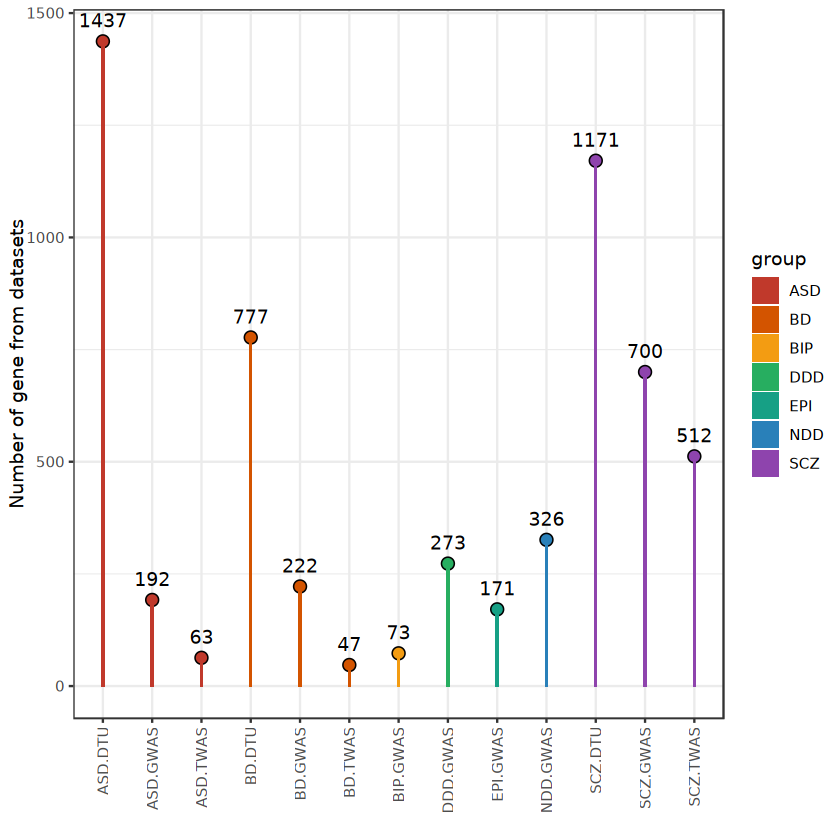

In [504]:
unique(refgdf$source)
hubsource = c('ASD.DTU','BD.DTU','SCZ.DTU','ASD.GWAS','BD.GWAS','SCZ.GWAS','NDD.GWAS','DDD.GWAS','BIP.GWAS','EPI.GWAS','ASD.TWAS','BD.TWAS',"SCZ.TWAS")
refgdf = refgdf[refgdf$gene_id %in% cmgeneid,]
refgdf.hub = refgdf[refgdf$source %in% hubsource,]
refgdf.hubst = refgdf.hub %>% group_by(source,group) %>% summarise(genen = length(unique(gene_id)))
p1.1 = ggplot(refgdf.hubst,aes(x = source,fill = group, y = genen)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_text(aes(label = genen),vjust = -1) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        scale_fill_flatui() +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + 
        ylab("Number of gene from datasets")
p1.1
ggexport(p1.1,filename = "result/figure5/Disease_datasets_genestat_25_03_19.pdf",width = 5,height = 4)

In [6]:
#total DTU stat
dtumkdf.hub = qread("result/figure3/class_DTU_by_subclass_ttest_24_11_05.qs")
head(dtumkdf.hub)
colnames(dtumkdf.hub)[5] = "areatr"
head(dtumkdf.hub)

gene_id transcript_id  pvalue      dr         cluster qvalue
16  ABCC5   XM_005546512.2 0.001969214  0.1571313 GLU     1     
182 ANAPC4  XM_005554612.2 0.014178056  0.1214028 GLU     1     
248 APBB3   XM_005557979.2 0.048700128 -0.1000114 GLU     1     
286 ARFIP2  XM_005578789.2 0.000655739 -0.1232940 GLU     1     
350 ARVCF   XM_005567964.2 0.017739128 -0.1075129 GLU     1     
357 ASH2L   XM_005563066.2 0.000149255 -0.1061145 GLU     1

gene_id transcript_id  pvalue      dr         areatr qvalue
16  ABCC5   XM_005546512.2 0.001969214  0.1571313 GLU    1     
182 ANAPC4  XM_005554612.2 0.014178056  0.1214028 GLU    1     
248 APBB3   XM_005557979.2 0.048700128 -0.1000114 GLU    1     
286 ARFIP2  XM_005578789.2 0.000655739 -0.1232940 GLU    1     
350 ARVCF   XM_005567964.2 0.017739128 -0.1075129 GLU    1     
357 ASH2L   XM_005563066.2 0.000149255 -0.1061145 GLU    1

In [7]:
summary(dtumkdf.hub$dr)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.294365 -0.130595 -0.101313 -0.007196  0.122961  0.368333 

In [8]:
#total DTU stat
isosigst = NULL
for(i in c(1:4,6)){
    isosigt = isosigls[[i]]
    isosigt = isosigt[isosigt$sig != "N",]
    isosigst = rbind(isosigst,isosigt[,c("gene_id","transcript_id","dr")])
    
}
isosigst = rbind(isosigst,dtumkdf.hub[,c("gene_id","transcript_id","dr")])
length(unique(isosigst$gene_id))
length(unique(isosigst$transcript_id))

[1] 4685

[1] 8796

In [11]:
mkls = qread(file = "result/figure2/gene_marker_list_25_04_14.qs")
mkls.cl = qread(file = "result/figure3/gene_marker_list_cell_24_12_09.qs")
names(mkls.cl)
mkgenet = NULL
for(i in 1:length(mkls)){
    mklsi = mkls[[i]]
    colnames(mklsi)[6:7] = c("areaid","gene_id")
    mklsi = mklsi[mklsi$avg_log2FC > 1 & mklsi$p_val_adj < 0.05 & mklsi$pct.1 > 0.1, ]
    mkgenet = c(mkgenet,unique(mklsi$gene_id))
}
for(i in 1:length(mkls.cl)){
    mklsi = mkls.cl[[i]]
    colnames(mklsi)[6:7] = c("areaid","gene_id")
    mklsi = mklsi[mklsi$avg_log2FC > 1 & mklsi$p_val_adj < 0.05 & mklsi$pct.1 > 0.1, ]
    mkgenet = c(mkgenet,unique(mklsi$gene_id))
}
mkgenet = unique(mkgenet)
length(mkgenet)

[1] "subclass" "class"

[1] 6063

In [ ]:
length(unique(isosigst[isosigst$gene_id %in% mkgenet,]$gene_id))

In [466]:
#refGWAS = refGWAS[refGWAS$source %in% c(""),]

#isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_dedup_24_09_04.qs")

In [18]:
hubsource = c('ASD.DTU','BD.DTU','SCZ.DTU','ASD.GWAS','BD.GWAS','SCZ.GWAS','NDD.GWAS','DDD.GWAS',
              'BIP.GWAS','EPI.GWAS','ASD.TWAS','BD.TWAS',"SCZ.TWAS")

DiseaseEnrich = function(isosigt,refgdf){
    isosigt = isosigt[substr(isosigt$gene_id,1,9) != "BambuGene",]
    areatrs = unique(isosigt$areatr)
    goana = NULL
    refgdfi = refgdf
    sourceid = unique(refgdfi$source)
    for(i in 1:length(areatrs)){
        isosigii = isosigt[isosigt$areatr == areatrs[i],]
        hubgene = unique(isosigii$gene_id)
        for(j in 1:length(sourceid)){
            refgene = unique(refgdfi[refgdfi$source == sourceid[j],]$gene_id)
            goanai = FishEnrich(hubgene,refgene,cmgenen)
            goanai$group = sourceid[j]
            goanai$areatr = areatrs[i]
            goana = rbind(goana,goanai)
        }
    }
    goana$fdr = p.adjust(goana$p.value)
    goanaf = goana[goana$group %in% hubsource,]
    #goanaf
    #goanaf$group = MySplit(goanaf$group,"\\.",1)
    goanaf$group = factor(goanaf$group,levels = hubsource)
    goanaf$stars <- cut(goanaf$p.value, breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), label=c("***", "**", "*", ""))  # Create column of significance labels
    return(goanaf)
}
#subclass
isosigt = isosigls$subclass
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigt = isosigt[isosigt$gene_id %in% cmgeneid,]
goanaf.subuni = DiseaseEnrich(isosigt,refgdf)
goanaf.subuni$sample = "subclass"
#class
dtumkdf.hub = qread("result/figure3/class_DTU_by_subclass_ttest_24_11_05.qs")
head(dtumkdf.hub)
colnames(dtumkdf.hub)[5] = "areatr"
dtumkdf.hub = dtumkdf.hub[dtumkdf.hub$gene_id %in% cmgeneid,]
goanaf.class = DiseaseEnrich(dtumkdf.hub,refgdf)
goanaf.class$sample = "class"

#layer
isosigt = isosigls$layer
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
goanaf.layer = DiseaseEnrich(isosigt,refgdf)
goanaf.layer$sample = "layer"

#lobe
isosigt = isosigls$lobe
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigt = isosigt[isosigt$gene_id %in% cmgeneid,]
goanaf.lobe = DiseaseEnrich(isosigt,refgdf)
goanaf.lobe$sample = "lobe"

#subcortical
isosigt = isosigls$subcortical
isosigt = isosigt[isosigt$sig != "N",]
isosigt = isosigt %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigt = isosigt[isosigt$gene_id %in% cmgeneid,]
goanaf.subc = DiseaseEnrich(isosigt,refgdf)
goanaf.subc$sample = "subcortical"

goanaft = rbind(goanaf.subuni,goanaf.class,goanaf.layer,goanaf.lobe,goanaf.subc)


gene_id transcript_id  pvalue      dr         cluster qvalue
16  ABCC5   XM_005546512.2 0.001969214  0.1571313 GLU     1     
182 ANAPC4  XM_005554612.2 0.014178056  0.1214028 GLU     1     
248 APBB3   XM_005557979.2 0.048700128 -0.1000114 GLU     1     
286 ARFIP2  XM_005578789.2 0.000655739 -0.1232940 GLU     1     
350 ARVCF   XM_005567964.2 0.017739128 -0.1075129 GLU     1     
357 ASH2L   XM_005563066.2 0.000149255 -0.1061145 GLU     1

In [20]:
data6s$ref = refgdf
data6s$enrich = goanaft

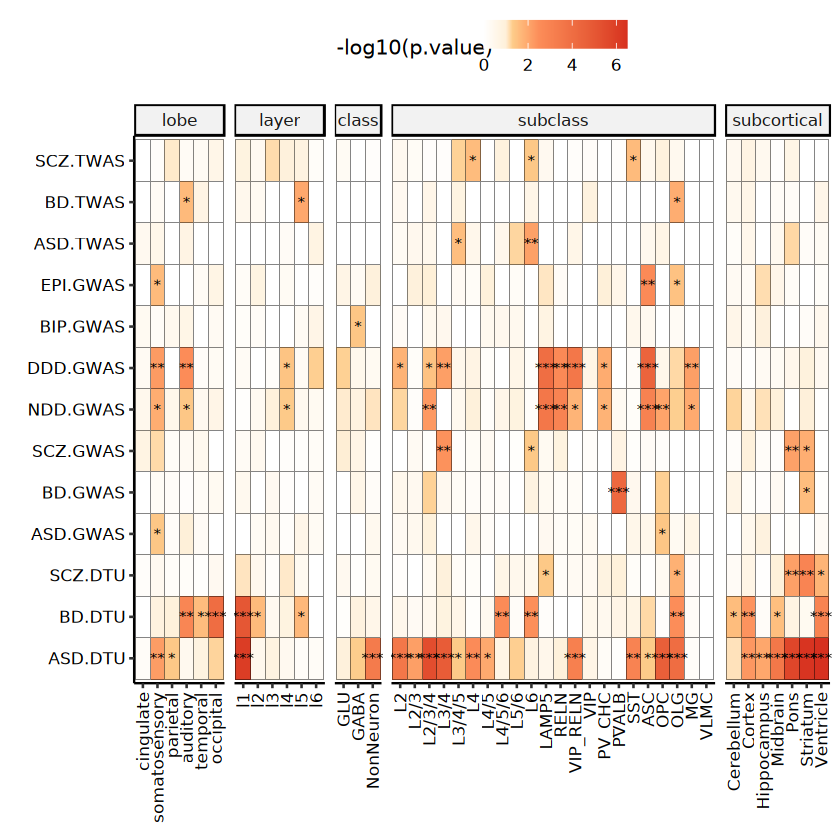

In [815]:
library(RColorBrewer)
goanaft$areatr = factor(goanaft$areatr,levels = c(lobeorder,layerorder,suborder,subcororder,"GLU","GABA","NonNeuron"))
goanaft$sample = factor(goanaft$sample,levels = c("lobe","layer","class","subclass","subcortical"))
goanaft$group = factor(goanaft$group,levels = hubsource)
maxp = max(-log10(goanaft$p.value))
ph = ggplot(goanaft,aes(x = areatr,y = group, fill = -log10(p.value))) + 
    geom_tile(color = "black") + 
    geom_text(aes(label=stars), color="black", size=3) + 
    theme_pubr() + 
    theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1,size = 10),
     axis.text.y = element_text(size = 10)) +
#    
    facet_grid(~sample,scale = "free",space = "free") +
#scale_color_gradient2(low = "blue", mid = "white",high = "red",midpoint = -log10(0.05)) + 
    scale_fill_gradientn(colours = c("white",brewer.pal(4,"OrRd")),
                        values = c(0, 1/maxp,(-log10(0.05))/maxp,2.5/maxp,1)) +
    xlab("") + ylab("")
ph
#ggexport(ph,filename = "result/figure5/Disease_enrich_analysis_25_03_19.pdf",width = 8.5,height = 4)

In [184]:
head(goanaft)

p.value      enrichscore overlap_size term_size query_size overlap_ratio
1 2.889816e-01 1.555954     6           193       321        0.03108808   
2 9.002813e-04 2.456434    16           326       321        0.04907975   
3 5.783390e-01 1.147274    16           698       321        0.02292264   
4 4.072431e-01 0.000000     0            72       321        0.00000000   
5 2.240593e-03 2.944108    10           170       321        0.05882353   
6 3.842924e-05 3.105282    17           274       321        0.06204380   
  group    areatr fdr        stars sample  
1 ASD.GWAS ASC    1.00000000       subclass
2 NDD.GWAS ASC    0.35200999 ***   subclass
3 SCZ.GWAS ASC    1.00000000       subclass
4 BIP.GWAS ASC    1.00000000       subclass
5 EPI.GWAS ASC    0.86710936 **    subclass
6 DDD.GWAS ASC    0.01521798 ***   subclass

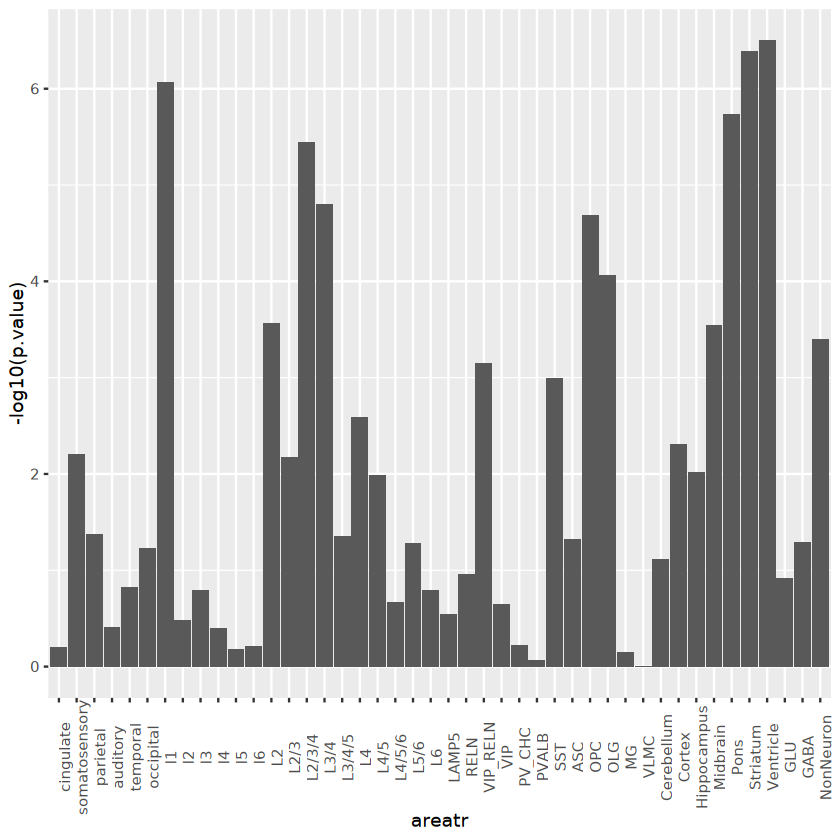

In [470]:
goanaft.hub = goanaft[goanaft$group %in% "ASD.DTU",]
ggplot(goanaft.hub,aes(x = areatr, y = -log10(p.value))) + geom_bar(stat = "identity") + 
    theme(axis.text.x = element_text(angle = 90))

#### Module explain

In [199]:
isosigt = NULL
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "subclass"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

dtumkdf.hub$group = "class"
isosigt = rbind(isosigt,dtumkdf.hub[,c("gene_id","areatr","group")])

isosigi = isosigls$layer
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "layer"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

isosigi = isosigls$lobe
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "lobe"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig != "N",]
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(unique(areatr)) == 1)
isosigi$group = "subcortical"
isosigt = rbind(isosigt,isosigi[,c("gene_id","areatr","group")])

[1] "FXR1"      "PSMA4"     "SETD6"     "GLYCTK"    "DNAJA3"    "JKAMP"    
  [7] "RERE"      "ASPHD1"    "MPPED2"    "TYW5"      "AKT3"      "IGSF9B"   
 [13] "PBXIP1"    "PARD6A"    "CORO7"     "CLCN3"     "LMAN2L"    "NDUFAF2"  
 [19] "FNDC4"     "DYNC1I2"   "NOL4"      "LY6H"      "GGNBP2"    "SNX1"     
 [25] "RABEP1"    "AGA"       "STAU2"     "GOPC"      "TMCC3"     "CROCC"    
 [31] "YIPF1"     "ZNF112"    "EIF4B"     "SUGP2"     "SLC12A2"   "FAM107B"  
 [37] "ELOVL1"    "MYO9A"     "PSME4"     "SMG6"      "ST6GAL1"   "PCDHB4"   
 [43] "ITGAE"     "NSFL1C"    "MRPS33"    "NUDC"      "HSP90AB1"  "IFT74"    
 [49] "PACSIN2"   "SDR39U1"   "EFS"       "CINP"      "ACTR5"     "RIOK3"    
 [55] "GGA2"      "TRPS1"     "NUCB1"     "MPP6"      "AIMP2"     "NSMCE4A"  
 [61] "ACBD5"     "DHRS11"    "LAMTOR3"   "DNAJC4"    "ARPC3"     "FAM65B"   
 [67] "HMGCR"     "NPRL2"     "RTN4"      "STRN"      "SPR"       "RBBP5"    
 [73] "MED28"     "PCDH17"    "CCDC92"    "HSDL2"     "CHRNA2"    "LRIF1"    
 [79] "SLC25A51"  "STAMBP"    "TUBGCP6"   "FAM98C"    "OSBPL2"    "TRAF3"    
 [85] "RAMP2"     "PPFIA1"    "PPP1R1B"   "IQCA1"     "DCLK1"     "DYDC2"    
 [91] "DUSP26"    "PSRC1"     "DZIP1"     "TPP2"      "SDS"       "NAT10"    
 [97] "B4GALNT1"  "KDELR2"    "MYCBPAP"   "TUBB2B"    "ARHGAP20"  "THUMPD2"  
[103] "PLCE1"     "CARF"      "GLCE"      "TDG"       "GIT2"      "ZSCAN29"  
[109] "GTF2A2"    "USP3"      "EMP3"      "ZNF687"    "CHAC2"     "ST6GAL2"  
[115] "CPLX2"     "FAM57B"    "ANO4"      "HOMER1"    "ZSCAN1"    "GPD1L"    
[121] "GRM1"      "GDPD1"     "PLCL2"     "NUP205"    "VPS8"      "FMNL2"    
[127] "FAIM"      "EPB41"     "RLTPR"     "CCDC117"   "FDPS"      "PAQR6"    
[133] "ACOX1"     "TNFSF13"   "KLHL21"    "SMARCAD1"  "ARHGEF3"   "GRM2"     
[139] "GRPEL2"    "CAMLG"     "REEP3"     "ZFYVE1"    "ZNF641"    "SRR"      
[145] "C2CD3"     "GNG4"      "CHTF8"     "NTSR2"     "METTL15"   "KCNAB3"   
[151] "COL24A1"   "ANO5"      "PAIP1"     "COPRS"     "ALG14"     "FAM192A"  
[157] "SNX32"     "DPY19L1"   "WDR25"     "TMEM80"    "MB21D2"    "PSMG4"    
[163] "NPM1"      "GPR3"      "LIMK2"     "TNFAIP8L3" "HMCES"     "METTL7A"  
[169] "KLHDC8B"   "GLDN"      "MITF"      "ERC2"      "UROS"      "CD47"     
[175] "MVB12B"    "KPNA5"     "PDLIM7"    "ZNF470"    "SPTAN1"    "EME2"     
[181] "RPS6KL1"   "ZNF583"    "ECI2"      "PRMT6"     "RUFY2"     "BAG6"     
[187] "ACOT6"     "SRA1"      "TMEM110"   "ZSWIM7"    "ZNF883"    "B3GALT4"  
[193] "GATSL3"    "ZNF512"    "KIAA1456"

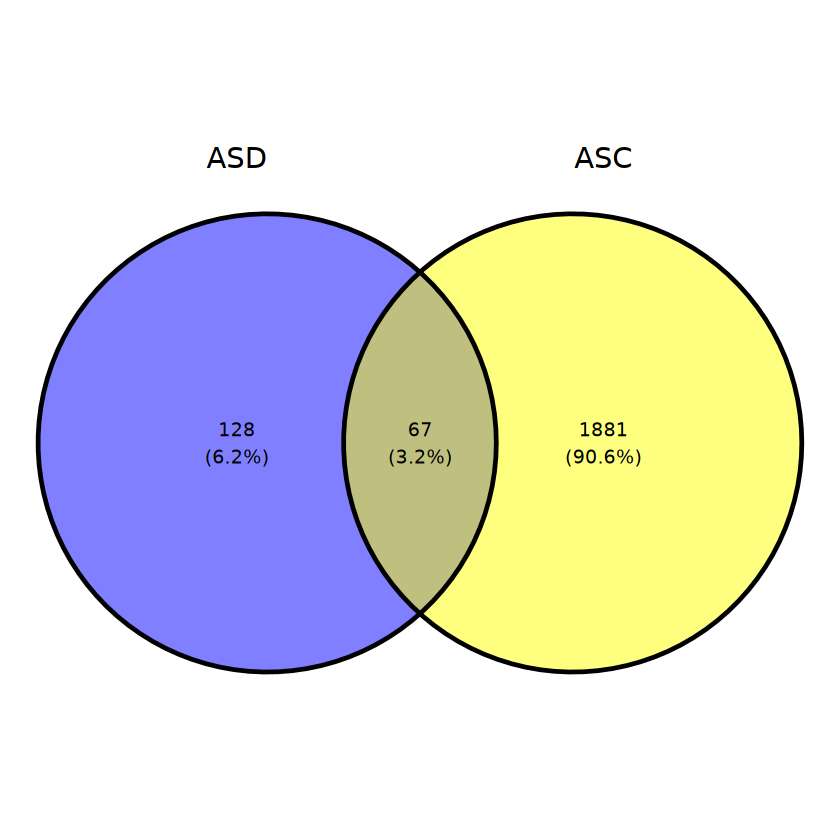

In [209]:
library(ggvenn)
isosigi = isosigls$subclass
hubgene1 = refgdf[refgdf$source == "SCZ.TWAS",]$gene_id
hubgene1 = hubgene1[hubgene1 %in% isosigi$gene_id]
hubgene1
#hubgene1
hubgene = isosigi[isosigi$sig != "N",]$gene_id
ggvenn(list("ASD" = hubgene1,"ASC" = hubgene))

In [33]:
casect = fsraw.cor[fsraw.cor$subclass != "",] %>% group_by(class,subclass,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(class,subclass,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)

`summarise()` has grouped output by 'class', 'subclass', 'gene_id'. You can
override using the `.groups` argument.


In [211]:
#stat top gene
isosigi = isosigls$subclass
hubgene = isosigi[isosigi$sig != "N",]$gene_id
hubsource2 = c('ASD.GWAS','SCZ.GWAS','NDD.GWAS','DDD.GWAS','BIP.GWAS','EPI.GWAS',"SCZ.TWAS",'ASD.TWAS','BD.TWAS')
refgdf.hub = refgdf[refgdf$gene_id %in% hubgene & refgdf$source %in% hubsource2,]
genest = refgdf.hub %>% group_by(gene_id) %>% summarise(sourcenum = length(unique(source)))
genest = genest[order(-genest$sourcenum),]
hubgene1 = unique(refgdf[refgdf$source %in% c("NDD.GWAS","DDD.GWAS"),]$gene_id)
genest = genest[genest$gene_id %in% hubgene1,] 
genest
# isosigt = isosigt[isosigt$gene_id %in% hubgene1,]

# genest = isosigt %>% group_by(gene_id) %>% summarise(sourcenum = length(unique(group)))
# genest = genest[order(-genest$sourcenum),]
# genest

gene_id  sourcenum
1  DYRK1A   4        
2  POGZ     4        
3  ADNP     3        
4  AKT3     3        
5  BCL11A   3        
6  CTNNB1   3        
7  DNM1     3        
8  EHMT1    3        
9  KMT2C    3        
10 KMT2E    3        
11 MBD5     3        
12 MYT1L    3        
13 RERE     3        
14 SETD5    3        
15 SPEN     3        
16 SPTAN1   3        
17 SYT1     3        
18 TCF7L2   3        
19 TLK2     3        
20 ZNF292   3        
21 AUTS2    2        
22 CAMK2B   2        
23 CAMTA1   2        
24 CLTC     2        
25 CTBP1    2        
26 DNM1L    2        
27 EP300    2        
28 ERF      2        
29 FBXW7    2        
30 FGF12    2        
⋮  ⋮        ⋮        
69 COL4A3BP 1        
70 DDX3X    1        
71 EIF5A    1        
72 FGFR1    1        
73 GSK3B    1        
74 HDAC8    1        
75 IQSEC2   1        
76 JAG1     1        
77 KDM5C    1        
78 KLHL20   1        
79 MFN2     1        
80 NFIB     1        
81 PAK1     1        
82 PCBP2    1        
83 PDE4D    1        
84 PRKAR1A  1        
85 PTPRD    1        
86 RORA     1        
87 SLC35A2  1        
88 SMARCE1  1        
89 SPTBN1   1        
90 SYNCRIP  1        
91 TAF1     1        
92 TCF12    1        
93 TMEM106B 1        
94 TRPM3    1        
95 USP9X    1        
96 WDR37    1        
97 ZC4H2    1        
98 ZMYND8   1

In [514]:
# hubgene = isosigt[isosigt$areatr == "l4" & isosigt$gene_id %in% refgdf$gene_id,]$gene_id
# hubgene
isosigi = isosigls$subclass
hubgene = isosigi[isosigi$sig != "N" & isosigi$areatr %in% c("RELN","ASC"),]$gene_id
genest = genest[genest$gene_id %in% hubgene,]
genest
caseg = genest[1:20,]$gene_id
caseg
caseg = c('DYRK1A','ADNP','AKT3','MYT1L','RERE','SETD5','SYT1','CDC42')

gene_id sourcenum
1  DYRK1A  4        
2  POGZ    4        
3  ADNP    3        
4  AKT3    3        
5  CTNNB1  3        
6  EHMT1   3        
7  KMT2C   3        
8  MYT1L   3        
9  RERE    3        
10 SETD5   3        
11 SPTAN1  3        
12 SYT1    3        
13 TCF7L2  3        
14 TLK2    3        
15 ZNF292  3        
16 AUTS2   2        
17 CAMTA1  2        
18 DNM1L   2        
19 EP300   2        
20 GNAO1   2        
21 GNB1    2        
22 GRIN1   2        
23 KAT6B   2        
24 KIF1A   2        
25 KRAS    2        
26 MARK2   2        
27 NSD1    2        
28 RFX3    2        
29 SETBP1  2        
30 SMARCB1 2        
31 SRRM2   2        
32 UBE3A   2        
33 ZBTB20  2        
34 ZEB2    2        
35 ANK3    1        
36 CDC42   1        
37 DDX3X   1        
38 EIF5A   1        
39 GSK3B   1        
40 KLHL20  1        
41 MFN2    1        
42 NFIB    1        
43 PAK1    1        
44 PCBP2   1        
45 PTPRD   1        
46 RORA    1        
47 SMARCE1 1        
48 SYNCRIP 1        
49 TRPM3   1        
50 USP9X   1        
51 ZC4H2   1        
52 ZMYND8  1

[1] "DYRK1A" "POGZ"   "ADNP"   "AKT3"   "CTNNB1" "EHMT1"  "KMT2C"  "MYT1L" 
 [9] "RERE"   "SETD5"  "SPTAN1" "SYT1"   "TCF7L2" "TLK2"   "ZNF292" "AUTS2" 
[17] "CAMTA1" "DNM1L"  "EP300"  "GNAO1"

class subclass gene_id 1         2         groupid geneidn
1 GABA  LAMP5    ADNP    0.5833333 0.4166667 11      2      
2 GABA  LAMP5    AKT3    0.8000000 0.1500000 11      3      
3 GABA  LAMP5    CDC42   0.8461538 0.1538462 11      8      
4 GABA  LAMP5    DYRK1A  0.7692308 0.1538462 11      1      
5 GABA  LAMP5    MYT1L   0.2941176 0.6470588 11      4      
6 GABA  LAMP5    RERE    0.4545455 0.2272727 11      5

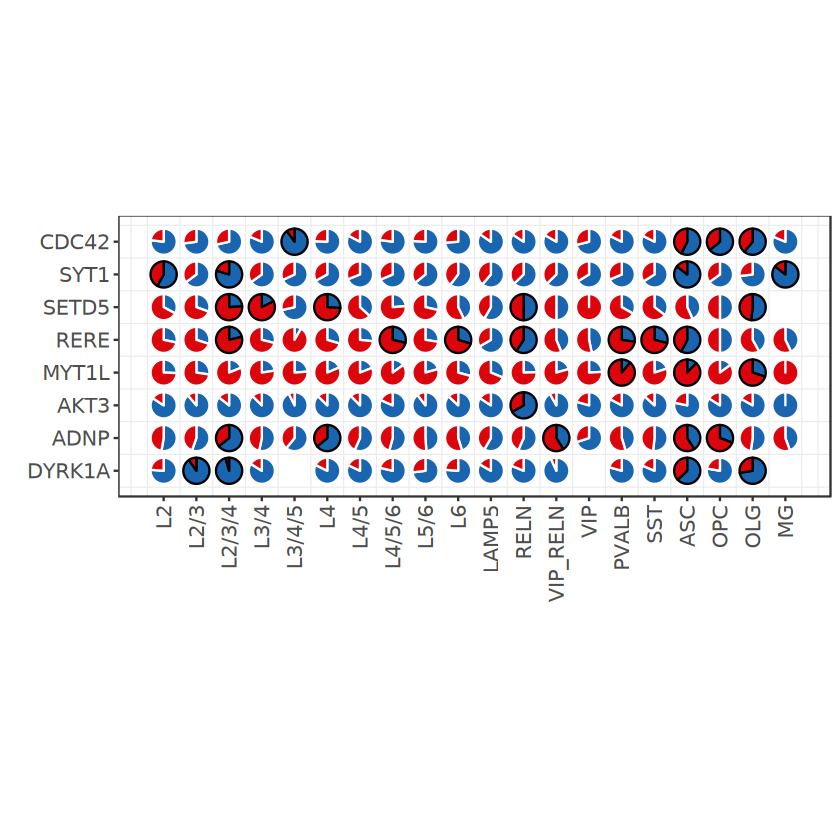

In [225]:
#caseg = genest[1:20,]$gene_id
#caseg = colnames(isosigimx)
isosigi = rbind(isosigls$subclass,isosigls$layer,isosigls$lobe,isosigls$subcortical)
isosigi = isosigi[isosigi$sig != "N",]
isosigi2 = rbind(isosigls$subclass,isosigls$layer,isosigls$lobe,isosigls$subcortical)
isosigi2 = isosigi2[isosigi2$meanrelative > 0.1,]

casecti = casect[casect$gene_id %in% caseg & casect$transcript_id %in% isosigi2$transcript_id,]

casecti = casecti[casecti$genecount > 10,]
casecti = casecti[!casecti$subclass %in% c("PV_CHC"),]

casecti = casecti %>% group_by(gene_id) %>% mutate(id = as.character(as.numeric(as.factor(transcript_id))))
casecti$gene_tran = paste0(casecti$gene_id,"-",casecti$id)
library(scatterpie)
casectl = dcast(casecti,class+subclass+gene_id~id,value.var = "rate")
casectl[is.na(casectl)] = 0
casectl = casectl[order(casectl$class,casectl$subclass),]
casectl$groupid = as.numeric(factor(casectl$subclass,levels = suborder[suborder %in% casectl$subclass]))
casectl$geneidn = as.numeric(factor(casectl$gene_id,levels = caseg))
head(casectl)

library(patchwork)
ison = casecti %>% group_by(gene_id) %>% summarise(transn = length(unique(transcript_id)))
ison = max(ison$transn)
casectl$sig = 'N'
casectl[paste0(casectl$subclass,casectl$gene_id) %in% paste0(isosigi$areatr,isosigi$gene_id),]$sig = "Y"
#caseg = c("INTU",'DNAJC7',"TUSC3","GRIP1","CACNB4","FAM173A","KLC1","MPG","MTG2","EIF5A","ARID4A","SIVA1","IDH3B")
#caseg = c("MYL6",'NTRK2',"DBNDD2","DDRGK1","ARPP19","ARPP21")
casectl$gene_id = factor(casectl$gene_id,levels = caseg)
plt = ggplot() + 
      geom_scatterpie(data = casectl[casectl$gene_id %in% caseg, ],
                      aes(x = groupid, y = geneidn, group = groupid,color = sig,
                                           r = 0.4),
                      cols=colnames(casectl)[4:(4+ison-1)]) + 
      coord_fixed() +
      scale_x_continuous(breaks = c(1:length(unique(casectl$subclass))),labels = suborder[suborder %in% casectl$subclass]) +
      scale_y_continuous(breaks = c(1:length(caseg)),labels = caseg) +
      scale_color_manual(values = c("white","black")) +
      # geom_smooth(data = tem2, aes(x=x, y=y), se = F, method = 'loess',color = "black") +
      scale_fill_discreterainbow() +
      #annotate("text", x = 8, y = 7, label = caseg[i], hjust = 1.1, vjust = 1.1, size = 5, angle = 90) +
      ylab("") + xlab("") +
      theme_bw() + theme(legend.position="none",axis.text = element_text(size = 12),panel.grid.major = element_blank(),
                         axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
                        strip.background =element_rect(fill="white"))
plt
#ggexport(plt,filename = "result/figure4/case_subclass_isoform_rate_stat_pie_24_12_09.pdf",width = 6,height = 8)

In [510]:
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
#refgdf = refgdf[refgdf$gene_id %in% fsraw.cor$gene_id,]
length(unique(refgdf[refgdf$source %in% c("NDD.GWAS","DDD.GWAS"),]$gene_id))
length(unique(refgdf[refgdf$source %in% c("ASD.DTU"),]$gene_id))

hubgene = refgdf[refgdf$source %in% c("NDD.GWAS","DDD.GWAS"),]$gene_id
isosig.wgi = isosigi[isosigi$gene_id %in% hubgene,]
length(unique(isosig.wgi$gene_id))
unique(isosig.wgi$gene_id)

hubgene = refgdf[refgdf$source %in% c("ASD.DTU"),]$gene_id
isosig.wgi = isosigi[isosigi$gene_id %in% hubgene,]
length(unique(isosig.wgi$gene_id))


[1] 387

[1] 1437

[1] 98

[1] "ADNP"      "AKT3"      "ALG13"     "ANK3"      "AUTS2"     "BCL11A"   
 [7] "CAMK2B"    "CAMTA1"    "CASK"      "CBX5"      "CDC42"     "CLTC"     
[13] "CNKSR2"    "COL4A3BP"  "CTBP1"     "CTNNB1"    "DDX3X"     "DNM1"     
[19] "DNM1L"     "DYRK1A"    "EHMT1"     "EIF5A"     "EP300"     "ERF"      
[25] "FBXW7"     "FGF12"     "FGFR1"     "GNAO1"     "GNB1"      "GRIN1"    
[31] "GSK3B"     "HDAC8"     "HNRNPU"    "HRAS"      "IQSEC2"    "JAG1"     
[37] "KAT6B"     "KDM5C"     "KIDINS220" "KIF1A"     "KLHL20"    "KMT2C"    
[43] "KMT2E"     "KRAS"      "MARK2"     "MBD5"      "MEF2C"     "MFN2"     
[49] "MYT1L"     "NF1"       "NFIB"      "NFIX"      "NSD1"      "PAK1"     
[55] "PCBP2"     "PDE4D"     "PIK3CA"    "PIK3R1"    "POGZ"      "PPP2CA"   
[61] "PRKAR1A"   "PSMC5"     "PTPRD"     "QRICH1"    "RERE"      "RFX3"     
[67] "RORA"      "SETBP1"    "SETD5"     "SLC35A2"   "SMARCB1"   "SMARCE1"  
[73] "SMC1A"     "SON"       "SPEN"      "SPTAN1"    "SPTBN1"    "SRRM2"    
[79] "SYNCRIP"   "SYT1"      "TAF1"      "TANC2"     "TCF12"     "TCF7L2"   
[85] "TLK2"      "TMEM106B"  "TRPM3"     "TRRAP"     "UBE3A"     "USP9X"    
[91] "WDR37"     "ZBTB20"    "ZC4H2"     "ZEB2"      "ZMYND8"    "ZNF292"   
[97] "ZNF462"    "ZNF644"

[1] 284

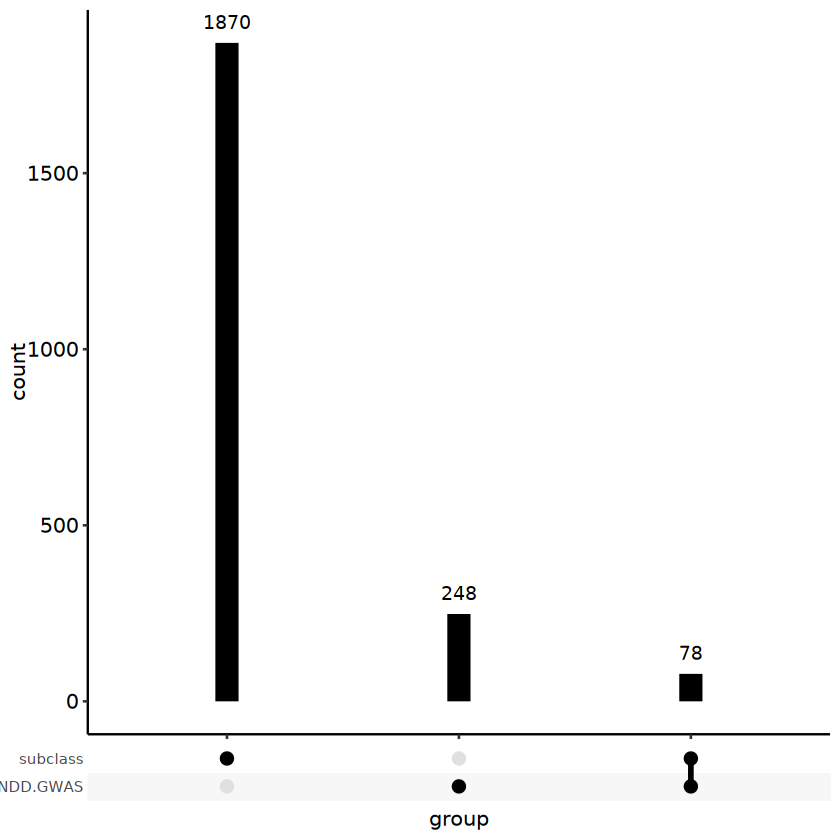

In [511]:
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",];isosigi = unique(isosigi[,c("gene_id","areatr")]);colnames(isosigi)[2] = "group"
isosigi$group = "subclass";isosigi1 = isosigi
# isosigi = isosigls$subcortical
# isosigi = isosigi[isosigi$sig != "N",];isosigi = unique(isosigi[,c("gene_id","areatr")]);colnames(isosigi)[2] = "group"
# isosigi$group = "subcortical";isosigi2 = isosigi
# isosigi = isosigls$region
# isosigi = isosigi[isosigi$sig != "N",];isosigi = unique(isosigi[,c("gene_id","areatr")]);colnames(isosigi)[2] = "group"
# isosigi$group = "region";isosigi3 = isosigi

refgdf.hub = refgdf[refgdf$source %in% c("NDD.GWAS"),]

refgdf.hub = refgdf.hub[,c("gene_id","source")]
colnames(refgdf.hub)[2] = "group"
dtustdf = rbind(refgdf.hub,isosigi1)
library(ggupset)
dtustdfup = unique(dtustdf[,c("gene_id","group")])
dtustdfup = dtustdfup %>%
  group_by(gene_id) %>%
  summarize(group = list(group))

pisonup2 = ggplot(data = dtustdfup,
            aes(x = group)) +
  scale_x_upset() + 
 geom_bar(fill = "black",width = 0.1) + 
 geom_text(stat = "count",aes(label=after_stat(count)),vjust = -1) + 
    theme_pubr()
pisonup2

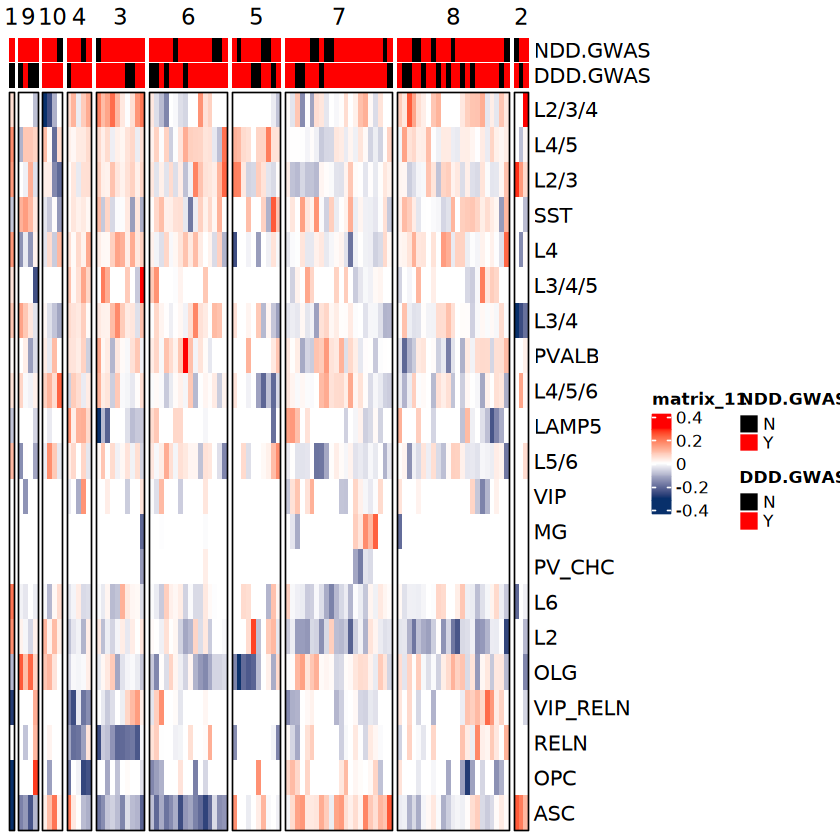

In [197]:
#DTU analysis of ASD
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
#isosigi = isosigi %>% group_by(transcript_id) %>% filter(length(unique(areatr)) == 1)
hubtrans = isosigi$transcript_id
hubgene = refgdf[refgdf$source %in% c("NDD.GWAS","DDD.GWAS"),]$gene_id
#hubgene = refgdf[refgdf$source %in% c("NDD.Talkowski","DDD.Retterer"),]$gene_id
#c("BD.DTU","SCZ.DTU")
isosigi = isosigls$subclass
isosig.wgi = isosigi[isosigi$gene_id %in% hubgene & isosigi$transcript_id %in% hubtrans,]
isosig.wgi = isosig.wgi %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
#isosig.wgi = isosig.wgi[isosig.wgi$count > 10,]

# isosigi = isosigls$layer
# isosig.wgi2 = isosigi[isosigi$gene_id %in% hubgene & isosigi$transcript_id %in% hubtrans,]
# isosig.wgi2 = isosig.wgi2 %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
# isosig.wgi2 = isosig.wgi2[isosig.wgi2$count > 10,]
# isosig.wgi = rbind(isosig.wgi,isosig.wgi2)
#turquoise
#table(isosig.wgi[,c("sig","areatr")])
isosigimx = dcast(isosig.wgi,gene_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigimx) = isosigimx$gene_id;isosigimx = isosigimx[,-1]
#isosigimx = isosigimx[,c("NonNeuron","GLU","GABA",paste0("l",1:6))]
#isosigimx = isosigimx[order(isosigimx$NonNeuron,isosigimx$GLU,isosigimx$GABA,isosigimx$l1),]
isosigimx = t(isosigimx)


myType = data.frame("gene_id" = colnames(isosigimx),
                    "NDD.GWAS" = "N",
                   "DDD.GWAS" = "N")
myType[myType$gene_id %in% refgdf[refgdf$source %in% c("NDD.GWAS"),]$gene_id,]$NDD.GWAS = "Y"
myType[myType$gene_id %in% refgdf[refgdf$source %in% c("DDD.GWAS"),]$gene_id,]$DDD.GWAS = "Y"
#myType[myType$gene_id %in% refgdf[refgdf$source %in% c("ASD.DTU"),]$gene_id,]$ASD.DTU = "Y"
rownames(myType) = myType$gene_id;myType = myType[,-1]
# 绘制热图
#pdf(outFile,height=5,width=8)
ha = HeatmapAnnotation(
    NDD.GWAS = myType$NDD.GWAS, 
    DDD.GWAS = myType$DDD.GWAS,
    col = list(NDD.GWAS = c("Y" = "red", "N" = "black"),
               DDD.GWAS = c("Y" = "red", "N" = "black"))
)
#pdf("result/figure5/ASD_disease_dtu_cases_24_11_21.pdf",width = 10,height = 3)
Heatmap(isosigimx,show_column_names = F,border = TRUE,column_km = 10,
        show_row_dend = F,show_column_dend = F,top_annotation = ha,
       colorRamp2(c(-0.3,0,0.3), c("#08306B", "white", "red")))

#dev.off()

In [ ]:
cellan[cellan$class == "GABA",]$subclass

In [ ]:
#DTU analysis of DDD
#DTU analysis of ASD
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
nrow(isosigi)
isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(areatr) == 1)
isosigi = isosigi[isosigi$areatr %in% cellan[cellan$class == "GABA",]$subclass & isosigi$count > 20,]
nrow(isosigi)
#isosigi = isosigi[isosigi$areatr %in% cellan[cellan$class == "GABA",]$subclass & isosigi$count > 40,]
hubtrans = unique(isosigi$transcript_id)
hubgene = refgdf[refgdf$source %in% c("NDD.Talkowski","DDD.Retterer","EPI.Neale"),]$gene_id
#hubgene = refgdf[refgdf$source %in% c("NDD.Talkowski","DDD.Retterer"),]$gene_id
#c("BD.DTU","SCZ.DTU")
isosigi = isosigls$subclass
isosig.wgi = isosigi[isosigi$gene_id %in% hubgene & isosigi$transcript_id %in% hubtrans,]
isosig.wgi = isosig.wgi %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
isosig.wgi = isosig.wgi[isosig.wgi$count > 10,]
#turquoise
#table(isosig.wgi[,c("sig","areatr")])
isosigimx = dcast(isosig.wgi,gene_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigimx) = isosigimx$gene_id;isosigimx = isosigimx[,-1]
#isosigimx = isosigimx[,c("NonNeuron","GLU","GABA",paste0("l",1:6))]
#isosigimx = isosigimx[order(isosigimx$GABA,isosigimx$NonNeuron,isosigimx$GLU,isosigimx$l1),]
isosigimx = t(isosigimx)

myType = data.frame("gene_id" = colnames(isosigimx),
                    "NDD.Talkowski" = "N",
                   "DDD.Retterer" = "N",
                   "EPI.Neale" = "N")
myType[myType$gene_id %in% refgdf[refgdf$source %in% c("NDD.Talkowski"),]$gene_id,]$NDD.Talkowski = "Y"
myType[myType$gene_id %in% refgdf[refgdf$source %in% c("DDD.Retterer"),]$gene_id,]$DDD.Retterer = "Y"
myType[myType$gene_id %in% refgdf[refgdf$source %in% c("EPI.Neale"),]$gene_id,]$EPI.Neale = "Y"
rownames(myType) = myType$gene_id;myType = myType[,-1]
# 绘制热图
#pdf(outFile,height=5,width=8)
ha = HeatmapAnnotation(
    NDD.Talkowski = myType$NDD.Talkowski, 
    DDD.Retterer = myType$DDD.Retterer,
    EPI.Neale = myType$EPI.Neale,
    col = list(NDD.Talkowski = c("Y" = "red", "N" = "black"),
               DDD.Retterer = c("Y" = "red", "N" = "black"),
              EPI.Neale = c("Y" = "red", "N" = "black"))
)
#pdf("result/figure5/ASD_disease_dtu_cases_24_11_21.pdf",width = 10,height = 3)
pt2 = Heatmap(isosigimx,show_column_names = F,cluster_columns = F,border = TRUE,cluster_rows = F,
        show_row_dend = F,show_column_dend = F,top_annotation = ha,
       colorRamp2(c(-0.3,0,0.3), c("#08306B", "white", "red")))

#dev.off()


In [ ]:
# pt2 = Heatmap(isosigimx,show_column_names = F,cluster_columns = F,border = TRUE,cluster_rows = F,
#         show_row_dend = F,show_column_dend = F,top_annotation = ha,
#        colorRamp2(c(-0.3,0,0.3), c("#08306B", "white", "red")))
pt2 = Heatmap(isosigimx,show_column_names = F,border = TRUE,
        show_row_dend = F,show_column_dend = F,top_annotation = ha,
       colorRamp2(c(-0.3,0,0.3), c("#08306B", "white", "red")))
pt2

In [32]:
casect = fsraw.cor[fsraw.cor$subclass != "",] %>% group_by(class,subclass,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(class,subclass,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)

`summarise()` has grouped output by 'class', 'subclass', 'gene_id'. You can
override using the `.groups` argument.


In [ ]:
casect2 = fsraw.cor %>% group_by(lobe,gene_id,transcript_id) %>% 
                summarise(count = length(readid)) %>% 
                group_by(lobe,gene_id) %>% 
                mutate(genecount = sum(count),rate = count/genecount)

class subclass gene_id 1         2         groupid geneidn
1 GABA  LAMP5    ADNP    0.5833333 0.4166667 11      2      
2 GABA  LAMP5    AKT3    0.8000000 0.1500000 11      6      
3 GABA  LAMP5    CDC42   0.8461538 0.1538462 11      8      
4 GABA  LAMP5    DYRK1A  0.7692308 0.1538462 11      1      
5 GABA  LAMP5    MYT1L   0.2941176 0.6470588 11      3      
6 GABA  LAMP5    RERE    0.4545455 0.2272727 11      7

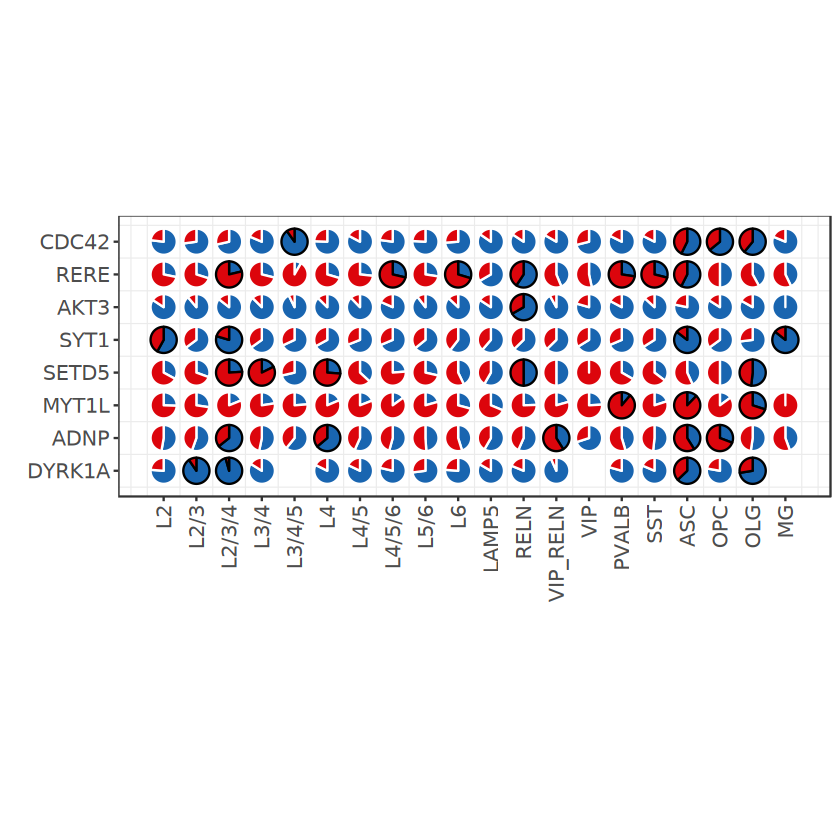

In [550]:
caseg = c('DYRK1A','ADNP','MYT1L','SETD5','SYT1','AKT3','RERE','CDC42')
#caseg = colnames(isosigimx)
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$sig != "N",]
isosigi2 = isosigls$subclass
isosigi2 = isosigi2[isosigi2$meanrelative > 0.1,]

casecti = casect[casect$gene_id %in% caseg & casect$transcript_id %in% isosigi2$transcript_id,]

casecti = casecti[casecti$genecount > 10,]
casecti = casecti[!casecti$subclass %in% c("PV_CHC"),]

casecti = casecti %>% group_by(gene_id) %>% mutate(id = as.character(as.numeric(as.factor(transcript_id))))
casecti$gene_tran = paste0(casecti$gene_id,"-",casecti$id)
library(scatterpie)
casectl = dcast(casecti,class+subclass+gene_id~id,value.var = "rate")
casectl[is.na(casectl)] = 0
casectl = casectl[order(casectl$class,casectl$subclass),]
casectl$groupid = as.numeric(factor(casectl$subclass,levels = suborder[suborder %in% casectl$subclass]))
casectl$geneidn = as.numeric(factor(casectl$gene_id,levels = caseg))
head(casectl)

library(patchwork)
ison = casecti %>% group_by(gene_id) %>% summarise(transn = length(unique(transcript_id)))
ison = max(ison$transn)
casectl$sig = 'N'
casectl[paste0(casectl$subclass,casectl$gene_id) %in% paste0(isosigi$areatr,isosigi$gene_id),]$sig = "Y"
#caseg = c("INTU",'DNAJC7',"TUSC3","GRIP1","CACNB4","FAM173A","KLC1","MPG","MTG2","EIF5A","ARID4A","SIVA1","IDH3B")
#caseg = c("MYL6",'NTRK2',"DBNDD2","DDRGK1","ARPP19","ARPP21")
casectl$gene_id = factor(casectl$gene_id,levels = caseg)
plt = ggplot() + 
      geom_scatterpie(data = casectl[casectl$gene_id %in% caseg, ],
                      aes(x = groupid, y = geneidn, group = groupid,color = sig,
                                           r = 0.4),
                      cols=colnames(casectl)[4:(4+ison-1)]) + 
      coord_fixed() +
      scale_x_continuous(breaks = c(1:length(unique(casectl$subclass))),labels = suborder[suborder %in% casectl$subclass]) +
      scale_y_continuous(breaks = c(1:length(caseg)),labels = caseg) +
      scale_color_manual(values = c("white","black")) +
      # geom_smooth(data = tem2, aes(x=x, y=y), se = F, method = 'loess',color = "black") +
      scale_fill_discreterainbow() +
      #annotate("text", x = 8, y = 7, label = caseg[i], hjust = 1.1, vjust = 1.1, size = 5, angle = 90) +
      ylab("") + xlab("") +
      theme_bw() + theme(legend.position="none",axis.text = element_text(size = 12),panel.grid.major = element_blank(),
                         axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
                        strip.background =element_rect(fill="white"))
plt
#ggexport(plt,filename = "result/figure6/case_subclass_isoform_rate_stat_pie_25_03_16.pdf",width = 6,height = 8)

Using gene_id as id variables

file saved to result/figure5/NDD_DTU_GABA_case_pieplot_25_03_19.pdf



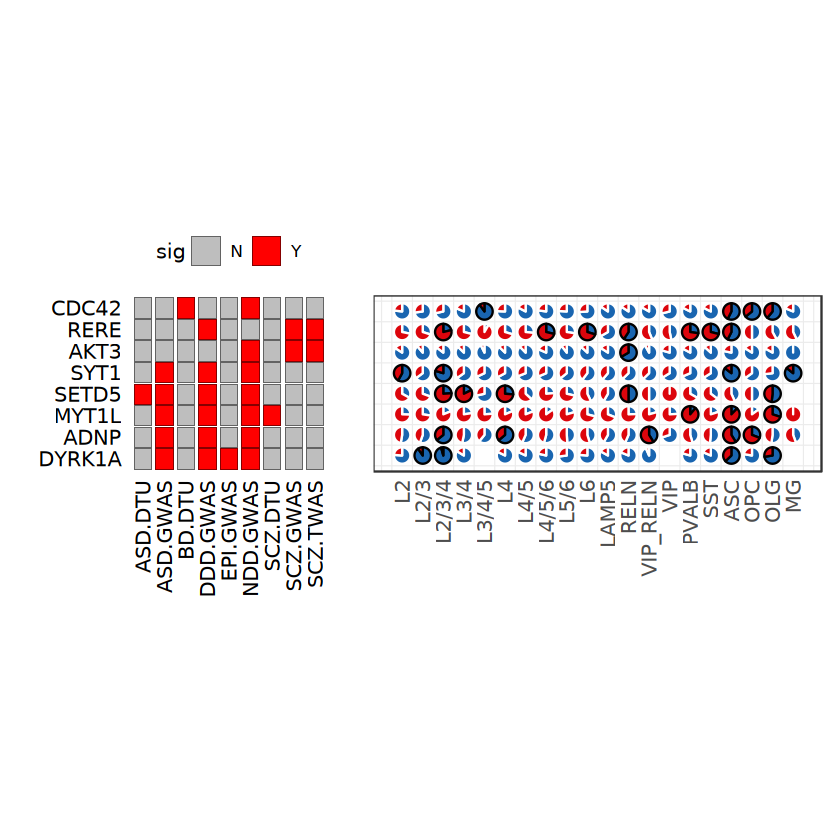

In [551]:
refgdf.hub = refgdf[refgdf$source %in% hubsource,]
refgdf.hubp = refgdf.hub[refgdf.hub$gene_id %in% caseg,]
refgdf.hubp = dcast(refgdf.hubp,gene_id~source, value.var = "source", 
                        fun.aggregate = function(x) length(unique(x)))
refgdf.hubp = melt(refgdf.hubp)
refgdf.hubp$sig = "N"
refgdf.hubp[refgdf.hubp$value > 0,]$sig = "Y"
refgdf.hubp$group = "source"
refgdf.hubp$gene_id = factor(refgdf.hubp$gene_id,levels = caseg)
p1.0 = ggplot(refgdf.hubp,aes(x = variable,y = gene_id,fill = sig)) + 
    geom_tile(width = 0.8,height = 0.95,color = "black") + 
#scale_x_discrete(position = "top") +
    scale_fill_manual(values = c("grey","red")) +
    theme_pubr() + 
    theme(axis.line=element_blank(),axis.ticks = element_blank(),axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
     strip.text.x = element_text(margin = margin(0.5,0,0.5,0, "cm"))) +
coord_fixed() + 
    xlab("") + ylab("")
plt2 = p1.0 + plt + theme(axis.line=element_blank(),axis.ticks = element_blank(),
     axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),axis.text.y = element_blank()) + 
    xlab("") + ylab("")
plt2
ggexport(plt2,filename = "result/figure5/NDD_DTU_GABA_case_pieplot_25_03_19.pdf",width = 8,height = 6)

In [ ]:
genels = unique(refgdf.hub[refgdf.hub$sourcen > 3,]$gene_id)
pcls = list()
for(i in 1:length(genels)){
    grtdfl = BuildPlotBed(fsraw.cor,longbed,"layer",genels[i],NULL)
    pcls[[i]] = tryCatch(IsoformReadPlot(gtf, grtdfl,genels[i],onlyhub = T), 
                                                  error = function(e) NULL)
}
ggexport(pcls,filename = "result/figure5/dtu_case_ls_disease_24_11_17.pdf",
           width = 5,height = 6)

In [ ]:
# hubgene = isosigt[isosigt$areatr == "l4" & isosigt$gene_id %in% refgdf$gene_id,]$gene_id
# hubgene
isosigi = isosigls$subclass
hubgene = isosigi[isosigi$sig != "N",]$gene_id
hubgene1 = refgdf[refgdf$gene_id %in% hubgene & refgdf$group == "NDD",]$gene_id
hubgene2 = refgdf[refgdf$gene_id %in% hubgene & refgdf$group == "DDD",]$gene_id
hubgene3 = refgdf[refgdf$gene_id %in% hubgene & refgdf$source == "EPI.Neale",]$gene_id
hubgene1[order(hubgene1)]
hubgene2[order(hubgene2)]
hubgene3[order(hubgene3)]

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 15 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."


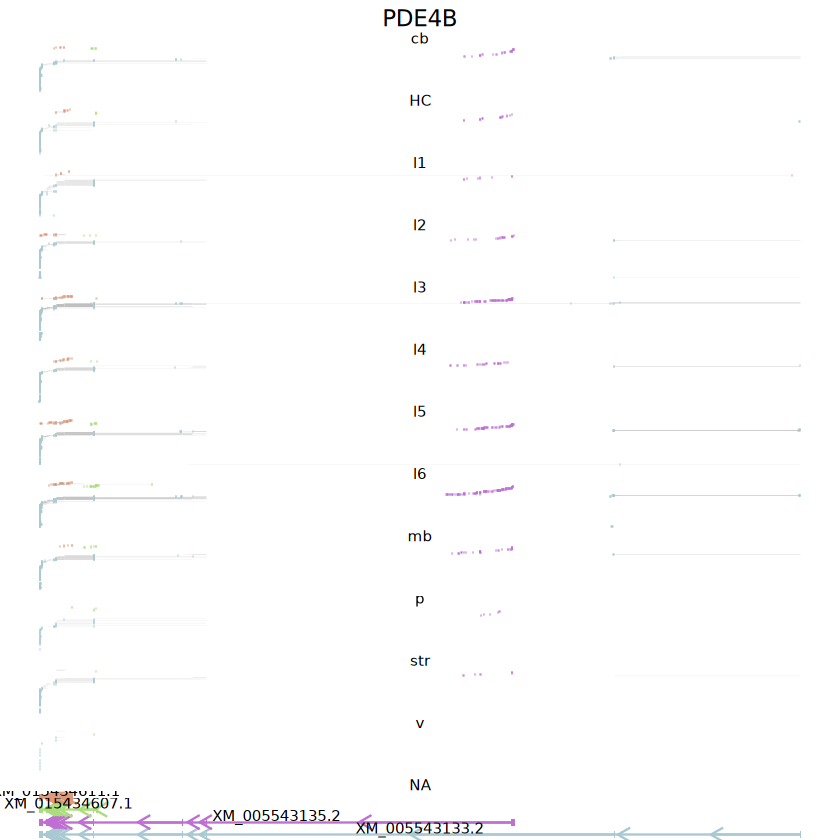

In [541]:
geneex = "PDE4B"
#fsraw.cor.hub = fsraw.cor[fsraw.cor$subclass %in% c("L4","VIP","ASC","OPC","OLG"),]
grtdfl = BuildPlotBed(fsraw.cor,longbed,"layer",geneex,NULL)
#grtdfl = grtdfl[grtdfl$transcript_id %in% c("NM_001283865.1","XM_005571070.2"),]
#grtdfl = grtdfl %>% group_by(readid) %>% filter(n()> 3)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = T), error = function(e) NULL)
pci
 # ggexport(pci,filename = "result/figure5/dtu_case_ls_disease_RBP_gene_readsplice_24_11_17.pdf",
 #           width = 5,height = 3)

In [ ]:
# black'INTS1'blue'TMEM56'brown'BambuGene53716'green'MAU2'greenyellow'SPRYD3'magenta'SMARCB1'pink'EEF1E1'purple'TPD52'red'SLC12A5'tan'ZRANB2'turquoise'ITSN2'yellow'ALS2'
geneex = c('AUTS2','CAMTA1','CBX5','CDC42','CLTC','CTNNB1','DYRK1A','EHMT1')

RefCase = function(isosig.wgi,refgdf.hub,geneex,hubtrans){
    refgdf.hubp = refgdf.hub[refgdf.hub$gene_id %in% geneex,]
    refgdf.hubp = dcast(refgdf.hubp,gene_id~group, value.var = "source", 
                        fun.aggregate = function(x) length(unique(x)))
    refgdf.hubp = melt(refgdf.hubp)
    refgdf.hubp$sig = "N"
    refgdf.hubp[refgdf.hubp$value > 0,]$sig = "Y"
    refgdf.hubp$group = "source"
    p1.0 = ggplot(refgdf.hubp,aes(x = variable,y = gene_id,fill = sig)) + 
    geom_tile(width = 0.8,height = 0.95) + 
#scale_x_discrete(position = "top") +
    scale_fill_manual(values = c("grey","red")) +
    facet_grid(~group) +
    theme_pubr() + 
    theme(axis.line=element_blank(),axis.ticks = element_blank(),axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
     strip.text.x = element_text(margin = margin(0.5,0,0.5,0, "cm"))) +
#coord_fixed() + 
    xlab("") + ylab("")
    p1.0

   # isosig.wgi = merge(isodf,netinfo.iso,by = "gene_id")
    isosig.wgi = isosig.wgi[isosig.wgi$gene_id %in% geneex,]
    isosig.wgi$group = "none"
    isosig.wgi[isosig.wgi$areatr %in% isosigls$layer$areatr,]$group = "layer"
    isosig.wgi[isosig.wgi$areatr %in% isosigls$lobe$areatr,]$group = "lobe"
    #isosig.wgi[isosig.wgi$areatr %in% isosigls$subclass$areatr,]$group = "subclass"
    isosig.wgi = isosig.wgi[isosig.wgi$transcript_id %in% hubtrans,]
    isosig.wgi = isosig.wgi %>% group_by(group,gene_id) %>% filter(meanrelative == max(meanrelative))
    
    suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OPC','OLG','MG','EC','VLMC')
    lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
    layerorder = paste0("l",1:6)
    isosig.hub = isosig.wgi[isosig.wgi$gene_id %in% geneex,]
    isosig.hub$areatr = factor(isosig.hub$areatr,levels = c(lobeorder,layerorder,suborder))
    isosig.hub$group = factor(isosig.hub$group,levels = c("lobe","layer","subclass"))
    p1.1 = ggplot(isosig.hub,aes(y = gene_id,x = areatr,fill = dr)) + geom_tile()+
    facet_grid(~group,scales = "free",space = "free") + 
    scale_fill_gradient2(low = "#08306B",mid = "white", high = "red",midpoint = 0,na.value = "grey") + 
    theme_pubr()  +
    theme(axis.line=element_blank(),axis.ticks = element_blank(),
     axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),axis.text.y = element_blank()) + 
    xlab("") + ylab("")
    p1.1
    
    pt = ggarrange(p1.0,p1.1,nrow = 1,widths = c(0.5,1),heights = c(0.5,1))
    return(pt)
}
geneex = c("BCL11A","SPEN","GPR137","THRA","CTNNB1","ZSCAN26","KRAS","SRSF7","FASTKD1","HNRNPA2B1")
isosig.wgi = rbind(isosigls$layer,isosigls$lobe)
hubgene = unique(refgdf[refgdf$source %in% c("NDD.Talkowski","DDD.Retterer"),]$gene_id)
#geneex = c('SMARCC2','ADNP','CTNNB1','CTBP1','GPR137','KCNA6','HNRNPA2B1')
# prc1 = RefCase(refgdf.hub,geneex)
# prc1
# geneex = c('HNRNPA1','HNRNPA2B1','HNRNPA3','HNRNPF','HNRNPH2')
isosigi = isosigls$layer[isosigls$layer$sig == "Up",]
hubgene = hubgene[hubgene %in% isosigi$gene_id]
geneex = hubgene
isosig.wgi = isosig.wgi[isosig.wgi$gene_id %in% hubgene,]
hubtrans = isosigi$transcript_id
refgdf.hub = refgdf
prc2 = RefCase(isosig.wgi,refgdf.hub,geneex,hubtrans)
prc2

In [ ]:
geneex = "SOX5"
#fsraw.cor.hub = fsraw.cor[!fsraw.cor$subclass %in% c("PV_CHC","VLMC"),]
grtdfl = BuildPlotBed(fsraw.cor,longbed,"layer",geneex,NULL)
#grtdfl = grtdfl %>% group_by(readid) %>% filter(n()> 1)
#grtdfl$group = factor(grtdfl$group,levels = suborder)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = F), error = function(e) NULL)
pci

In [ ]:
geneex = c('HNRNPA1','HNRNPA2B1','HNRNPA3','HNRNPF','HNRNPH2')
isodft = rbind(isosigls$lobe,isosigls$layer,isosigls$subclass)
isosig.wgi = merge(isodft,netinfo.iso,by = "gene_id")
#isosig.wgi = isosig.wgi[isosig.wgi$transcript_id %in% hubtrans,]
isosig.wgi$group = "none"
isosig.wgi[isosig.wgi$areatr %in% isosigls$layer$areatr,]$group = "layer"
isosig.wgi[isosig.wgi$areatr %in% isosigls$lobe$areatr,]$group = "lobe"
isosig.wgi[isosig.wgi$areatr %in% isosigls$subclass$areatr,]$group = "subclass"


suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OPC','OLG','MG','EC','VLMC')
lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
layerorder = paste0("l",1:6)
isosig.hub = isosig.wgi[isosig.wgi$gene_id %in% geneex,]
isosig.hub$areatr = factor(isosig.hub$areatr,levels = c(lobeorder,layerorder,suborder))
isosig.hub$group = factor(isosig.hub$group,levels = c("lobe","layer","subclass"))
head(isosig.hub)

isosig.hub = isosig.hub %>% group_by(gene_id) %>% 
mutate(transid = as.character(as.numeric(as.factor(transcript_id))))
p1.1 = ggplot(isosig.hub,aes(y = relative,x = areatr,fill = transid,color = sig)) + 
    geom_bar(stat = "identity",size = 0.5)+
    facet_grid(gene_id~group,scales = "free",space = "free") + 
    scale_color_manual(values = c("red","grey","blue")) + 
    scale_fill_discreterainbow()  + 
    theme_pubr()  +
    theme(axis.line=element_blank(),axis.ticks = element_blank(),
     axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),axis.text.y = element_blank()) + 
    xlab("") + ylab("")
p1.1
ggexport(p1.1,filename = "result/figure5/dtu_case_ls_disease_RBP_gene_24_11_17.pdf",
           width = 6,height = 6)

In [ ]:
geneex = c('SF1','SRRM1','SRSF10','SRSF3','SRSF4','SRSF7' )
isodft = rbind(isosigls$lobe,isosigls$layer,isosigls$subclass)
isosig.wgi = merge(isodft,netinfo.iso,by = "gene_id")
#isosig.wgi = isosig.wgi[isosig.wgi$transcript_id %in% hubtrans,]
isosig.wgi$group = "none"
isosig.wgi[isosig.wgi$areatr %in% isosigls$layer$areatr,]$group = "layer"
isosig.wgi[isosig.wgi$areatr %in% isosigls$lobe$areatr,]$group = "lobe"
isosig.wgi[isosig.wgi$areatr %in% isosigls$subclass$areatr,]$group = "subclass"


suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OPC','OLG','MG','EC','VLMC')
lobeorder = c('cingulate','somatosensory','parietal','auditory','temporal','occipital')
layerorder = paste0("l",1:6)
isosig.hub = isosig.wgi[isosig.wgi$gene_id %in% geneex,]
isosig.hub$areatr = factor(isosig.hub$areatr,levels = c(lobeorder,layerorder,suborder))
isosig.hub$group = factor(isosig.hub$group,levels = c("lobe","layer","subclass"))
head(isosig.hub)

isosig.hub = isosig.hub %>% group_by(gene_id) %>% 
mutate(transid = as.character(as.numeric(as.factor(transcript_id))))
p1.1 = ggplot(isosig.hub,aes(y = relative,x = areatr,fill = transid,color = sig)) + 
    geom_bar(stat = "identity",size = 0.5)+
    facet_grid(gene_id~group,scales = "free",space = "free") + 
    scale_color_manual(values = c("red","grey","blue")) + 
    scale_fill_discreterainbow()  + 
    theme_pubr()  +
    theme(axis.line=element_blank(),axis.ticks = element_blank(),
     axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),axis.text.y = element_blank()) + 
    xlab("") + ylab("")
p1.1
# ggexport(p1.1,filename = "result/figure5/dtu_case_ls_disease_SP_gene_24_11_17.pdf",
#            width = 6,height = 6)

#### Cross species cases

In [ ]:
cd /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/ref/cross_species/
liftoff -g gencode.v19.annotation.gtf GCF_000364345.1_Macaca_fascicularis_5.0_genomic.fa GRCh37.p13.genome.fa  -o gencode.v19.annotation.liftover.gtf -p 10
gffcompare -R  bambu_extended_annotations_novelname_fil_04_30.gtf -r gencode.v19.annotation.liftover.gtf -o bambu_macaca_vs_hg19lifted_25_03_16.gtf


In [244]:
###compare human and mac5 isoform make modified mcaque gtf
# 人类GRCh38的注释文件路径
human_gtf <- "../../software/refdata/GRCh38_gencode/genes/genes.gtf"
# 鼠mm10的注释文件路径
mouse_gtf <- "../../software/refdata/refdata-gex-mm10-2020-A/genes/genes.gtf"
# 读取注释文件
human_txdb <- makeTxDbFromGFF(file = human_gtf,format = "gtf")
mouse_txdb <- makeTxDbFromGFF(file = mouse_gtf,format = "gtf")

GRanges object with 6 ranges and 8 metadata columns:
         seqnames    ranges strand |   source       type     score     phase
            <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1] NC_012670.1  620-2452      + |    Bambu transcript        NA      <NA>
  [2] NC_012670.1  620-1566      + |    Bambu exon              NA      <NA>
  [3] NC_012670.1 1633-2452      + |    Bambu exon              NA      <NA>
  [4] NC_012670.1 1637-2483      - |    Bambu transcript        NA      <NA>
  [5] NC_012670.1 1637-2300      - |    Bambu exon              NA      <NA>
  [6] NC_012670.1 2354-2483      - |    Bambu exon              NA      <NA>
              gene_id          transcript_id        transcript_name exon_number
          <character>            <character>            <character> <character>
  [1] BambuGene146379 BambuGene146379-WeiL.. BambuGene146379-WeiL..        <NA>
  [2] BambuGene146379 BambuGene146379-WeiL.. BambuGene146379-WeiL..           1
  [3] Bambu

V1   V2         V3          V4          V5   V6
1 chr1 CM001919.1 NC_022272.1 227,556,264 41.5 28
2 chr2 CM001920.1 NC_022273.1 192,460,366 39.5 20
3 chr3 CM001921.1 NC_022274.1 192,294,377 40.5 41
4 chr4 CM001922.1 NC_022275.1 170,955,103 39.5 69
5 chr5 CM001923.1 NC_022276.1 189,454,096 38.0 22
6 chr6 CM001924.1 NC_022277.1 181,584,905 39.5 15

[1] 1152247

[1] 1137349

ERROR: Error in getSeqlevelsReplacementMode(value, seqlevels(x)): the supplied 'seqlevels' must be a character vector with no NAs and no
  duplicates


In [276]:
library(readxl)
path = "ref/disease_gene/science.aat8127/aat8127_table_s1.xlsx"
disref = multiplesheets(path)
names(disref)

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
Warning message:
"Expecting numeric in N22318 / R22318C14: got 'NA'"
Warning message:
"Expecting numeric in O22318 / R22318C15: got 'NA'"
Warning message:
"Expecting numeric in P22318 / R22318C16: got 'NA'"
Warning message:
"Expecting numeric in Q22318 / R22318C17: got 'NA'"
Warning message:
"Expecting numeric in R22318 / R22318C18: got 'NA'"
Warning message:
"Expecting numeric in S22318 / R22318C19: got 'NA'"
Warning message:
"Expecting numeric in T22318 / R22318C20: got 'NA'"
Warning message:
"Expecting numeric in U22318 / R22318C21: got 'NA'"
Warning message:
"Expecting numeric in V22318 / R22318C22: got 'NA'"
Warning message:
"Expecting numeric in W22318 / R22318C23: got 'NA'"
Warning message:
"Expecting numeric in X22318 / R22318C24: got 'NA'"
Warning message:
"Expecting nu

[1] "README"               "DGE"                  "DTE"                 
[4] "DTU"                  "isoformOnlyDE"        "CellTypeEnrichment"  
[7] "RiskGeneEnrichment"   "sLDSR"                "CrossDisorderOverlap"

In [22]:
gtf.fil = rtracklayer::import("ref/cross_species/bambu_extended_annotations_novelname_fil_04_30.gtf")

In [23]:
#load human vs macaque
hgvmac.tmap = read.table("ref/cross_species/bambu_macaca_vs_hg19lifted_25_03_16.gtf.bambu_extended_annotations_novelname_fil_04_30.gtf.tmap",
                        header = T)
hgvmac.tmapf = hgvmac.tmap[hgvmac.tmap$class_code == "=",]
hgvmac.tmapf$ref_id = substr(hgvmac.tmapf$ref_id,1,nchar(hgvmac.tmapf$ref_id)-2)
trnumt = length(unique(gtf.fil$transcript_id))
trnumhit = length(unique(hgvmac.tmapf$qry_id))
trnumhit
trnumhit/trnumt
# hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "MYL6",]
# hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "CDC42",]
# hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "RWDD1",]

[1] 20837

[1] 0.2215901

In [25]:
data6s$cross_species = hgvmac.tmapf

In [476]:
d2[d2$external_gene_id == "DDRGK1",
            c("external_gene_id","ensembl_transcript_id",
              "external_transcript_id","DTU.ASD.Value","DTU.SCZ.Value","DTU.BD.Value","DTU.ASD.p.value","DTU.BD.p.value"
             ,"DTU.SCZ.p.value")]
hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "DDRGK1",]

external_gene_id ensembl_transcript_id external_transcript_id
1299  DDRGK1           ENST00000354488       DDRGK1-001            
8521  DDRGK1           ENST00000380201       DDRGK1-004            
34889 DDRGK1           ENST00000470203       DDRGK1-003            
48296 DDRGK1           ENST00000496781       DDRGK1-002            
      DTU.ASD.Value DTU.SCZ.Value DTU.BD.Value DTU.ASD.p.value DTU.BD.p.value
1299   0.3942321    -1.50258025   -0.60588201  0.7882769       0.3824556     
8521   0.5527702     0.95504345    0.49712410  0.4976270       0.1752681     
34889 -0.4007986    -0.06528516   -0.06394686  0.5639960       0.8514045     
48296 -0.5988560     0.63804902    0.18541196  0.5307475       0.6482499     
      DTU.SCZ.p.value
1299  0.002004574    
8521  0.000263401    
34889 0.782172352    
48296 0.031630395

ref_gene_id       ref_id          class_code qry_gene_id qry_id        
49035 ENSG00000198171.8 ENST00000354488 =          DDRGK1      XM_005568473.2
      num_exons FPKM TPM cov len  major_iso_id   ref_match_len
49035 9         0    0   0   1318 XM_005568473.2 1306

[1] NA                "ENST00000496781" "ENST00000354488" "ENST00000470203"
[5] "ENST00000380201"

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


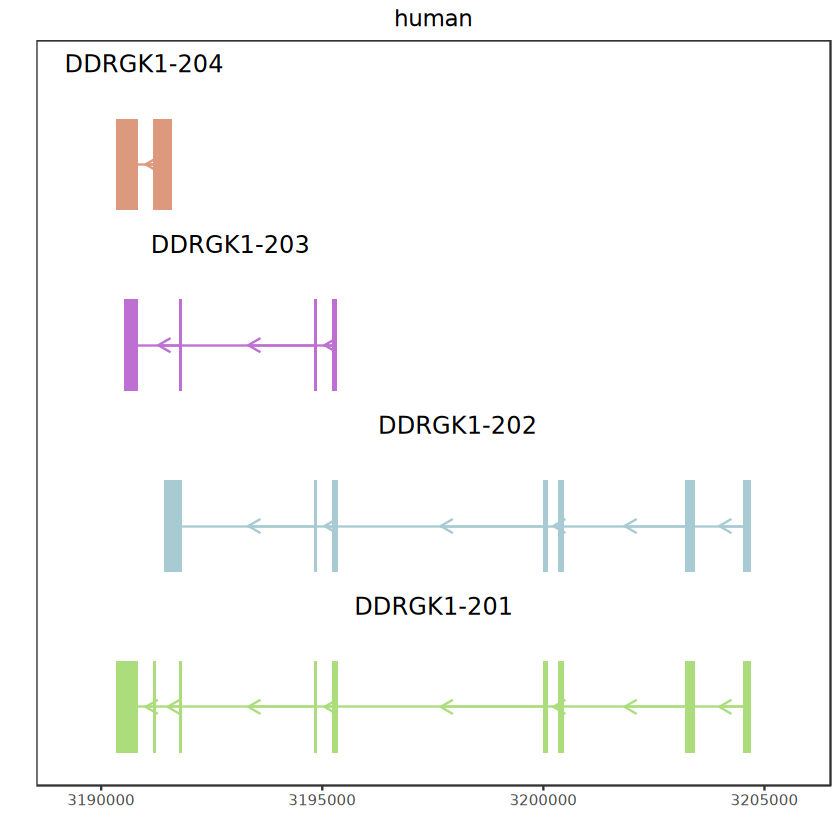

In [485]:
#hubtrans = c("ENST00000354488","ENST00000380201")
gtf.hp$transcript_id_st = substr(gtf.hp$transcript_id,1,15)
gtfdf.hp = as.data.frame(gtf.hp[gtf.hp$gene_name == "DDRGK1",])
gtfdf.hp$transcript_name = as.factor(gtfdf.hp$transcript_name)
unique(gtfdf.hp$transcript_id_st)
groupid = "human"
pc3 = Txrefplot(gtfdf.hp,groupid)
pc3

In [539]:
d2 = disref$DTU
d2g.ASD = d2[abs(d2$DTU.ASD.Value)> 1 & d2$DTU.ASD.p.value< 0.01,]$ensembl_transcript_id
d2g.SCZ = d2[abs(d2$DTU.SCZ.Value)> 1 & d2$DTU.SCZ.p.value < 0.01,]$ensembl_transcript_id
d2g.BD = d2[abs(d2$DTU.BD.Value)> 1 & d2$DTU.BD.p.value < 0.01,]$ensembl_transcript_id
length(d2g.ASD)
d2g.ASD = d2g.ASD[d2g.ASD %in% hgvmac.tmapf$ref_id]
length(d2g.ASD)
d2g.SCZ = d2g.SCZ[d2g.SCZ %in% hgvmac.tmapf$ref_id]
d2g.BD = d2g.BD[d2g.BD %in% hgvmac.tmapf$ref_id]
d2gls = list("ASD" = d2g.ASD,"SCZ" = d2g.SCZ, "BD" = d2g.BD)

Mydtuvsref = function(isosigi,d2gls){
    isosigi = merge(isosigi,hgvmac.tmapf[,c("ref_id","qry_id")],by.x = "transcript_id",by.y = "qry_id")
    isosigi.hub = isosigi[isosigi$sig != "N",]
    isosigi = isosigi[isosigi$transcript_id %in% isosigi.hub$transcript_id,]
    isosigcmp = NULL
    for(i in 1:length(d2gls)){
        isosigj = isosigi[isosigi$ref_id %in% d2gls[[i]],]
        d2.hub = d2[d2$ensembl_transcript_id %in% d2gls[[i]],
            c("external_gene_id","ensembl_transcript_id","DTU.ASD.Value",
              "DTU.SCZ.Value","DTU.BD.Value","DTU.ASD.p.value")]
        isosigcmpi = merge(d2.hub,isosigj,by.x = "ensembl_transcript_id",by.y = "ref_id")
        isosigcmpi$group = names(d2gls)[i]
        isosigcmp = rbind(isosigcmp,isosigcmpi)
    }
    return(isosigcmp)
}
isosigi = isosigls$subclass
isosigcmp.sb = Mydtuvsref(isosigi,d2gls)
isosigcmp.sb$level = "subclass"
isosigi = isosigls$subcortical
isosigcmp.sbc = Mydtuvsref(isosigi,d2gls)
isosigcmp.sbc$level = "subcortical"
isosigi = isosigls$layer
isosigcmp.ly = Mydtuvsref(isosigi,d2gls)
isosigcmp.ly$level = "layer"
isosigi = isosigls$region
isosigcmp.rg = Mydtuvsref(isosigi,d2gls)
isosigcmp.rg$level = "region"
isosigi = isosigls$lobe
isosigcmp.lb = Mydtuvsref(isosigi,d2gls)
isosigcmp.lb$level = "lobe"

length(unique(isosigcmp.rg$gene_id))
#isosigcmpt = rbind(isosigcmp.sb,isosigcmp.sbc)
isosigcmpt = rbind(isosigcmp.sb,isosigcmp.sbc,isosigcmp.ly,isosigcmp.rg,isosigcmp.lb)
length(unique(isosigcmpt$gene_id))
isosigcmpt %>% group_by(group) %>% summarise(genenum = length(unique(gene_id)))
isosigcmpt %>% group_by(level) %>% summarise(genenum = length(unique(gene_id)))
isosigcmpt.st2 = isosigcmpt %>% group_by(gene_id) %>% summarise(groupn = length(unique(group)))
nrow(isosigcmpt.st2[isosigcmpt.st2$groupn > 1,])
isosigcmpt.st2[isosigcmpt.st2$groupn > 2,]
##length(unique(isosigcmp$gene_id))
# isosigcmp.st = isosigcmp %>% group_by(areatr) %>% summarise(cor = cor(DTU.ASD.Value,dr),trannum = length(unique(transcript_id)))
# isosigcmp.st
unique(isosigcmpt$gene_id)

[1] 1991

[1] 543

[1] 197

[1] 366

group genenum
1 ASD   117    
2 BD    119    
3 SCZ   164

level       genenum
1 layer        77    
2 lobe         51    
3 region      197    
4 subclass    148    
5 subcortical 186

[1] 31

gene_id groupn
1 MDK     3     
2 PDE4B   3     
3 PLPP2   3

[1] "LTA4H"           "RPN2"            "MBD2"            "AP4B1"          
  [5] "THRA"            "SHPRH"           "TATDN1"          "NIPBL"          
  [9] "MED21"           "RPL22L1"         "MFSD3"           "DDX54"          
 [13] "SNX32"           "MRFAP1L1"        "CRADD"           "PDE4B"          
 [17] "SMARCE1"         "COPS8"           "UBA5"            "WDR55"          
 [21] "DLC1"            "RPE"             "ANGEL2"          "PPARD"          
 [25] "PJA1"            "ENAH"            "GPATCH2"         "PLEKHA1"        
 [29] "TMEM56"          "SLC25A25"        "SLC2A8"          "NTRK2"          
 [33] "XRN2"            "FAM216A"         "ACTR2"           "APOO"           
 [37] "CDK14"           "RWDD1"           "TDG"             "ALG13"          
 [41] "CLTA"            "TMEM106B"        "JMJD1C"          "SLC35A2"        
 [45] "YWHAH"           "VGLL4"           "VPS8"            "PDZD2"          
 [49] "IL1RAP"          "FDPS"            "OSBPL9"          "CCDC136"        
 [53] "LOC102118851"    "FAM92A1"         "PHB2"            "LATS1"          
 [57] "MYL6"            "SMARCC2"         "SEC11A"          "ST6GAL1"        
 [61] "HSCB"            "APMAP"           "RAMP3"           "WDR83"          
 [65] "RSRP1"           "SNRPC"           "ZNF337"          "APC"            
 [69] "HACE1"           "DGKG"            "GFOD2"           "SLC39A3"        
 [73] "KAT6B"           "RNF126"          "AP2M1"           "ARHGEF3"        
 [77] "RGL1"            "NINJ2"           "CEP89"           "ZNF471"         
 [81] "EDEM3"           "LOC102130734"    "HMGCS1"          "SIVA1"          
 [85] "BambuGene113631" "ACTR8"           "EIF5A"           "CLDND1"         
 [89] "MIA3"            "DDRGK1"          "MIER1"           "GDA"            
 [93] "KIFAP3"          "DPCD"            "RCAN2"           "TEX30"          
 [97] "SEPT8"           "AURKAIP1"        "ACSL6"           "ASPH"           
[101] "VLDLR"           "RPH3A"           "EEF1B2"          "KIAA0430"       
[105] "FBXO7"           "ZDHHC8"          "PPP1R7"          "ARRB1"          
[109] "NEK1"            "JMJD6"           "TTC19"           "RNF130"         
[113] "DERL2"           "MTMR7"           "GMIP"            "ACOT8"          
[117] "ARL2BP"          "RPS12"           "CPSF3"           "MECR"           
[121] "XPO5"            "MAPKAP1"         "CDC42"           "CCDC88A"        
[125] "PCID2"           "CAPRIN1"         "MTMR2"           "SLC25A26"       
[129] "NMRK1"           "PACRG"           "PNISR"           "ADGRB3"         
[133] "LOC101925321"    "NDUFS5"          "PLXDC2"          "C11H12orf73"    
[137] "CCP110"          "COPS2"           "RYR3"            "MTERF4"         
[141] "FAM172A"         "SUPT5H"          "DAPK1"           "CAB39L"         
[145] "SPG20"           "MFN2"            "BEND5"           "INPP4B"         
[149] "RHBDL1"          "VASP"            "AIF1L"           "BFAR"           
[153] "MAP3K13"         "RGS20"           "BCCIP"           "FABP5"          
[157] "CLTB"            "ANO6"            "ZADH2"           "INO80C"         
[161] "TCAIM"           "DPYSL3"          "PDE10A"          "LOC102134966"   
[165] "C15H9orf9"       "MPZL1"           "AGBL5"           "SMYD2"          
[169] "DCLK1"           "PSIP1"           "SNCA"            "BAIAP2"         
[173] "OXSM"            "NT5C3A"          "MED31"           "BECN1"          
[177] "CHPF2"           "TMEM161A"        "EFS"             "NUTF2"          
[181] "DECR1"           "ARAP3"           "ACVR2A"          "TTC21B"         
[185] "GCHFR"           "TMEM206"         "ARFGEF1"         "CD44"           
[189] "CALB1"           "B3GAT3"          "EXOSC7"          "FBXO3"          
[193] "SRI"             "SAT2"            "PTS"             "TRIM36"         
[197] "LOC102114773"    "LOC102128802"    "STOX2"           "KLHL3"          
[201] "PMP22"           "SNAPC5"          "MID1"            "AGPAT4"         
[205] "SNX10"           

In [966]:
length(unique(isosigcmpt$transcript_id))

[1] 401

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


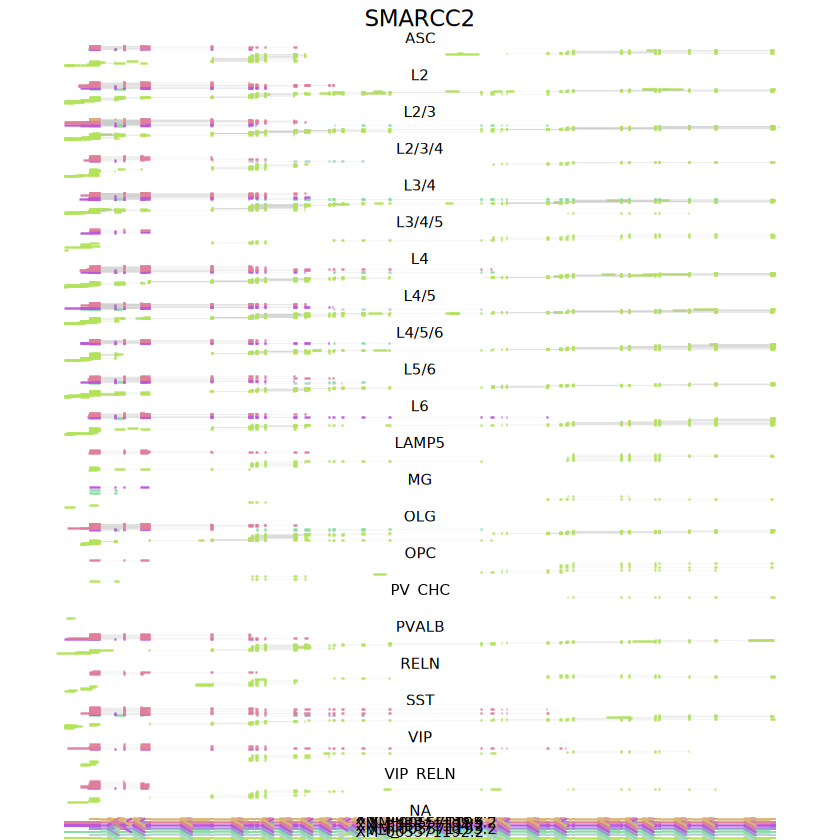

In [624]:
geneex = "SMARCC2"
#fsraw.cor.hub = fsraw.cor[fsraw.cor$subclass %in% c("L4","VIP","ASC","OPC","OLG"),]
grtdfl = BuildPlotBed(fsraw.cor,longbed,"subclass",geneex,NULL)
#grtdfl = grtdfl[grtdfl$transcript_id %in% c("NM_001283865.1","XM_005571070.2"),]
#grtdfl = grtdfl %>% group_by(readid) %>% filter(n()> 3)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = T), error = function(e) NULL)
pci
 # ggexport(pci,filename = "result/figure5/dtu_case_ls_disease_RBP_gene_readsplice_24_11_17.pdf",
 #           width = 5,height = 3)

`summarise()` has grouped output by 'level'. You can override using the
`.groups` argument.
file saved to result/figure5/Disease_conserve_dtu_stat_bar_25_03_20.pdf



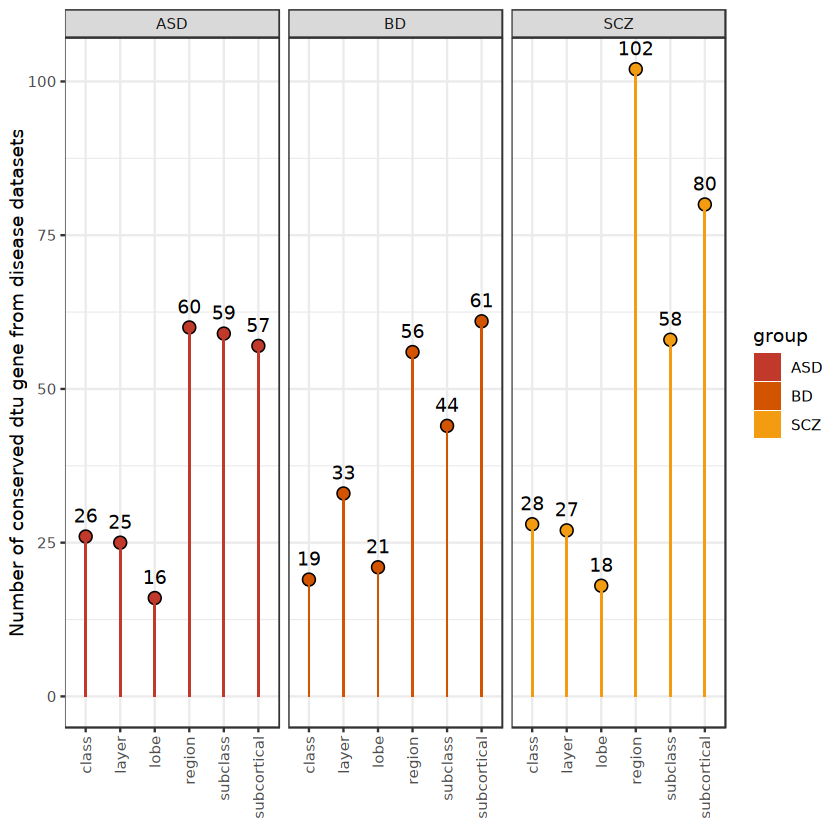

file saved to result/figure5/Disease_conserve_dtu_stat_tile_25_03_20.pdf

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


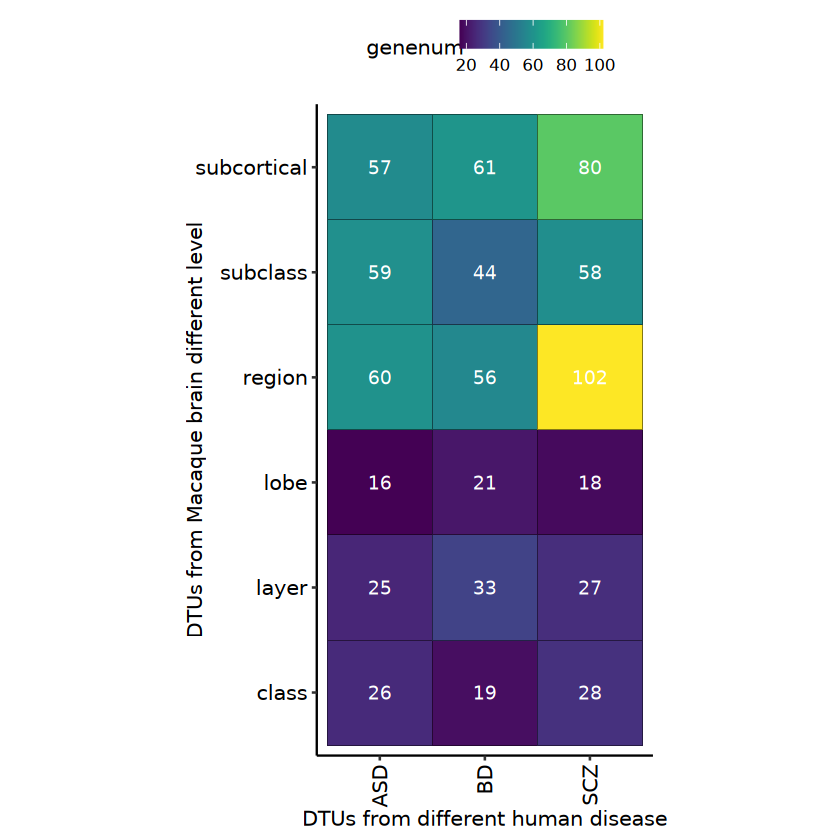

file saved to result/figure5/Disease_conserve_dtu_stat_venn_25_03_20.pdf



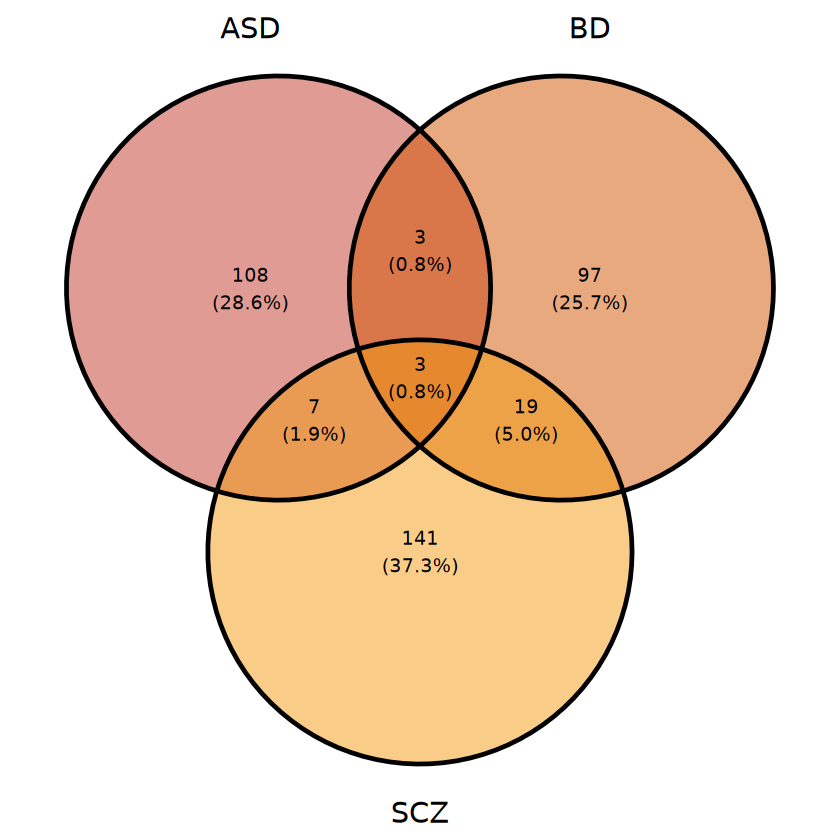

In [781]:
#disease associated FS DTU gene stat
isosigcmpt.st = isosigcmpt %>% group_by(level,group) %>% summarise(genenum = length(unique(gene_id)))
#ggplot(isosigcmpt.st,aes(x = level,fill = group,y = genenum)) + geom_bar(stat = "identity",position = "dodge")
p1.2 = ggplot(isosigcmpt.st,aes(x = level,fill = group,y = genenum)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_text(aes(label = genenum),vjust = -1) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        facet_grid(~group) +
        scale_fill_flatui() +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + 
        ylab("Number of conserved dtu gene from disease datasets")
p1.2
ggexport(p1.2,filename = "result/figure5/Disease_conserve_dtu_stat_bar_25_03_20.pdf",width = 5,height = 4)

p1.2.1 = ggplot(isosigcmpt.st,aes(y = level,x = group,fill = genenum)) + 
        geom_tile(color = "black") +
        geom_text(aes(label = genenum),color = "white") +
        scale_fill_viridis(option = "D") +
        coord_fixed() +
        theme_pubr() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + ylab("DTUs from Macaque brain different level") + 
        xlab("DTUs from different human disease")
p1.2.1
ggexport(p1.2.1,filename = "result/figure5/Disease_conserve_dtu_stat_tile_25_03_20.pdf",width = 5,height = 4)


fsdtuds = list("ASD" = unique(isosigcmpt[isosigcmpt$group == "ASD",]$gene_id),
              "BD" = unique(isosigcmpt[isosigcmpt$group == "BD",]$gene_id),
              "SCZ" = unique(isosigcmpt[isosigcmpt$group == "SCZ",]$gene_id))
p1.3 = ggvenn(fsdtuds) + scale_fill_flatui()
p1.3
ggexport(p1.3,filename = "result/figure5/Disease_conserve_dtu_stat_venn_25_03_20.pdf",width = 5,height = 4)

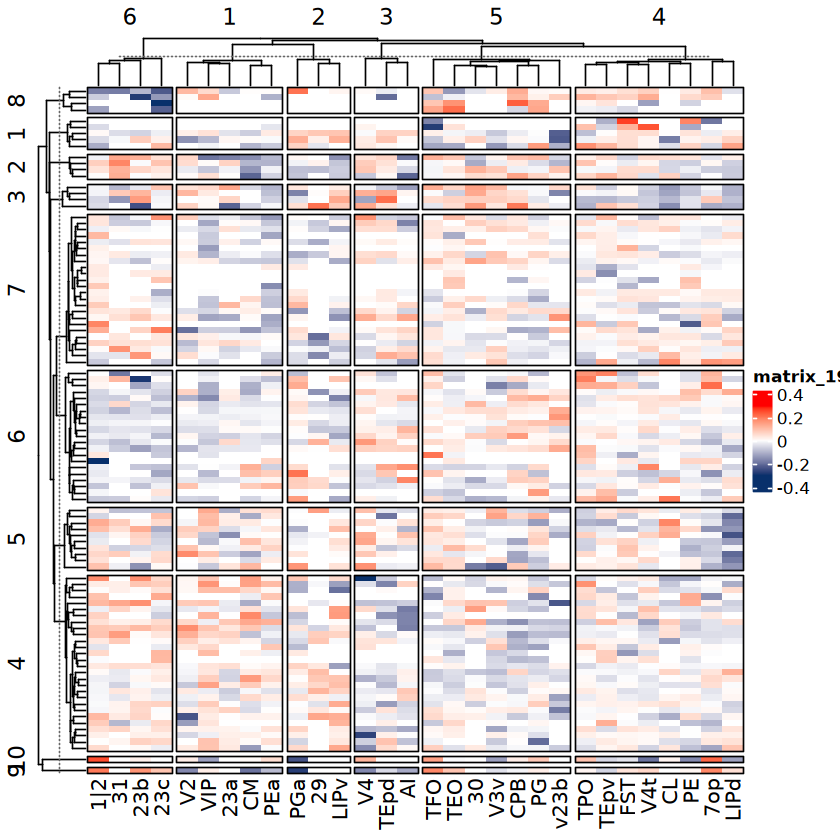

In [842]:
isosigi = isosigls$region
hubtrans = isosigcmpt[isosigcmpt$sig != "N" & isosigcmpt$group == "SCZ" & isosigcmpt$level == "region",]$transcript_id
isosigi = isosigi[isosigi$transcript_id %in% hubtrans,]
isosigi = isosigi %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
isosigimx = dcast(isosigi,gene_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigimx) = isosigimx$gene_id;isosigimx = isosigimx[,-1]

#pdf("result/figure5/ASD_disease_dtu_cases_24_11_21.pdf",width = 10,height = 3)
Heatmap(isosigimx,show_row_names = F,border = TRUE,column_km = 6,row_km = 10,
       colorRamp2(c(-0.3,0,0.3), c("#08306B", "white", "red")))


In [843]:
isosigi[order(-isosigi$genecount),]

gene_id      transcript_id  areatr count genecount relative   meanrelative
1    SNRPN        XM_005558943.2 TEO    3333  7009      0.4755315  0.5214119   
2    SNRPN        XM_005558943.2 1|2    3304  6600      0.5006061  0.5214119   
3    SNRPN        XM_005558943.2 TEpv   2425  5067      0.4785869  0.5214119   
4    SNRPN        XM_005558943.2 FST    1900  3667      0.5181347  0.5214119   
5    SNRPN        XM_005558943.2 PE     1945  3651      0.5327308  0.5214119   
6    SNRPN        XM_005558943.2 TFO    1492  3271      0.4561296  0.5214119   
7    DDRGK1       XM_005568473.2 1|2    1291  2863      0.4509256  0.4328460   
8    DDRGK1       XM_005568473.2 TEO    1305  2854      0.4572530  0.4328460   
9    SNRPN        XM_005558943.2 V4t    1346  2763      0.4871516  0.5214119   
10   SNRPN        XM_005558943.2 TPO    1388  2616      0.5305810  0.5214119   
11   SNRPN        XM_005558943.2 23c    1434  2585      0.5547389  0.5214119   
12   SNRPN        XM_005558943.2 7op    1465  2530      0.5790514  0.5214119   
13   SNRPN        XM_005558943.2 PEa    1440  2482      0.5801773  0.5214119   
14   DDRGK1       XM_005568473.2 TEpv    960  2082      0.4610951  0.4328460   
15   EEF1B2       NM_001284704.1 TEO    1387  2049      0.6769156  0.6509412   
16   SEPT8        XM_005557741.2 TEO    1656  2034      0.8141593  0.7906472   
17   SNRPN        XM_005558943.2 CPB     974  2000      0.4870000  0.5214119   
18   SNRPN        XM_005558943.2 PG      973  1955      0.4976982  0.5214119   
19   EEF1B2       NM_001284704.1 1|2    1199  1899      0.6313849  0.6509412   
20   SNRPN        XM_005558943.2 VIP    1114  1876      0.5938166  0.5214119   
21   SNRPN        XM_005558943.2 V3v     845  1778      0.4752531  0.5214119   
22   MORF4L1      XM_005560222.2 TEO    1312  1753      0.7484313  0.7150802   
23   SEPT8        XM_005557741.2 1|2    1297  1689      0.7679100  0.7906472   
24   EEF1B2       NM_001284704.1 TEpv   1123  1681      0.6680547  0.6509412   
25   SNRPN        XM_005558943.2 LIPd    930  1659      0.5605787  0.5214119   
26   SNRPN        XM_005558943.2 23b     856  1602      0.5343321  0.5214119   
27   DDRGK1       XM_005568473.2 FST     773  1578      0.4898606  0.4328460   
28   SNRPN        XM_005558943.2 TEpd    713  1571      0.4538511  0.5214119   
29   DDRGK1       XM_005568473.2 23c     558  1559      0.3579217  0.4328460   
30   SEPT8        XM_005557741.2 TEpv   1232  1510      0.8158940  0.7906472   
⋮    ⋮            ⋮              ⋮      ⋮     ⋮         ⋮          ⋮           
2451 CTDSPL2      XM_005559393.2 CL     21    21        1.00000000 0.9772008   
2452 DDX55        XM_005572576.2 VIP    18    21        0.85714286 0.7605871   
2453 EDEM3        XM_005540225.2 CM     17    21        0.80952381 0.6675687   
2454 EMP3         XM_005589756.2 PE     21    21        1.00000000 0.9699219   
2455 FBXO3        NM_001283335.1 29     12    21        0.57142857 0.5674790   
2456 GALM         XM_005576081.2 LIPd   21    21        1.00000000 0.9682904   
2457 GDA          XM_005581927.2 23b     1    21        0.04761905 0.3118472   
2458 GEMIN8       XM_005593002.1 23a    18    21        0.85714286 0.8327200   
2459 GMDS         NM_001284855.1 V2     20    21        0.95238095 0.9359225   
2460 GNG4         XR_272895.1    30      1    21        0.04761905 0.1484061   
2461 GNG4         XR_272895.1    V2      2    21        0.09523810 0.1484061   
2462 GPR85        XM_005550559.2 VIP     2    21        0.09523810 0.1282591   
2463 IBTK         XM_005552484.2 23a    17    21        0.80952381 0.7814667   
2464 KAT6B        XM_005565422.2 23a    19    21        0.90476190 0.8712163   
2465 KLHL3        XM_005557860.2 PGa     7    21        0.33333333 0.2110314   
2466 KLHL3        XM_005557860.2 V3v     1    21        0.04761905 0.2110314   
2467 LOC102122672 XM_005557724.2 31     16    21        0.76190476 0.8508685   
2468 LOC102122910 XM_015444627.1 LIPd    3    21        0.14285714 0.1662112   
2469 

In [611]:
fsdtudsdf = data.frame("gene_id" = c(fsdtuds$ASD,fsdtuds$BD,fsdtuds$SCZ),
                      "group" = rep(c("ASD","BD","SCZ"),c(length(fsdtuds$ASD),length(fsdtuds$BD),length(fsdtuds$SCZ))))
write.csv(fsdtudsdf,file = "result/figure5/Disease_conserve_dtu_list.csv",row.names =F,quote = F)

In [844]:
# fsdtudsdf[fsdtudsdf$gene_id %in% refgdf[refgdf$source == "ASD.TWAS",]$gene_id,]
# fsdtudsdf[fsdtudsdf$gene_id %in% refgdf[refgdf$source == "BD.TWAS",]$gene_id,]
# fsdtudsdf[fsdtudsdf$gene_id %in% refgdf[refgdf$source == "SCZ.TWAS",]$gene_id,]
#fsdtudsdf[fsdtudsdf$group == "BD",]$gene_id
fsdtudsdf[fsdtudsdf$group == "SCZ",]$gene_id[order(fsdtudsdf[fsdtudsdf$group == "SCZ",]$gene_id)]
#d2[abs(d2$DTU.SCZ.Value)> 1 & d2$DTU.SCZ.p.value < 0.01 & d2$external_gene_id == "CTLA",]
hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "SNRPN",]
#refgdf[refgdf$gene_id %in% c("CLTA","CLTB"),]

[1] "ABCG2"           "ACSL6"           "ACTR8"           "ACVR2A"         
  [5] "AFAP1"           "AGPAT4"          "AP2M1"           "APC"            
  [9] "APMAP"           "ARAP3"           "ARFGEF1"         "ARHGEF3"        
 [13] "ARL6"            "ARRB1"           "ASPH"            "ATF1"           
 [17] "ATP1B3"          "AUP1"            "AURKAIP1"        "B3GAT3"         
 [21] "BambuGene113631" "BCAS4"           "BOLA1"           "C8H8orf82"      
 [25] "CAB39L"          "CALB1"           "CALML4"          "CD44"           
 [29] "CDK14"           "CEP89"           "CHPF2"           "CLDND1"         
 [33] "CNTNAP4"         "CTDSPL2"         "CXCL12"          "DDRGK1"         
 [37] "DDX55"           "DECR1"           "DGKG"            "DPCD"           
 [41] "EDEM3"           "EEF1B2"          "EFS"             "EIF5A"          
 [45] "ELOVL1"          "EMP3"            "EXOSC7"          "FADS3"          
 [49] "FBXO3"           "FBXO7"           "FGF9"            "FZR1"           
 [53] "GALM"            "GCHFR"           "GDA"             "GEMIN8"         
 [57] "GFOD2"           "GMDS"            "GNG4"            "GPR85"          
 [61] "HACE1"           "HMGCS1"          "HSCB"            "IBTK"           
 [65] "JMJD6"           "KAT6B"           "KIAA0430"        "KIFAP3"         
 [69] "KLHL3"           "LOC102114773"    "LOC102114950"    "LOC102115867"   
 [73] "LOC102122672"    "LOC102122910"    "LOC102128802"    "LOC102130734"   
 [77] "LOC102140649"    "MARCH9"          "MDK"             "MIA3"           
 [81] "MICU2"           "MID1"            "MIER1"           "MOG"            
 [85] "MORF4L1"         "MORN1"           "MOSPD2"          "NAA16"          
 [89] "NEK1"            "NHSL1"           "NINJ2"           "NPAS4"          
 [93] "NRXN1"           "NTAN1"           "NUDT4"           "NUTF2"          
 [97] "OLFM3"           "PCNA"            "PDE4B"           "PHACTR3"        
[101] "PIK3R3"          "PLA2G5"          "PLCD1"           "PLD4"           
[105] "PLPP2"           "PMP22"           "PPP1R7"          "PROC"           
[109] "PSPC1"           "PTS"             "RAMP3"           "RCAN2"          
[113] "RGL1"            "RNF126"          "RNF130"          "RNF144A"        
[117] "RNF146"          "RNMT"            "RPH3A"           "RSRP1"          
[121] "RTBDN"           "SAT2"            "SEPT8"           "SESN1"          
[125] "SIVA1"           "SLC12A2"         "SLC25A13"        "SLC25A15"       
[129] "SLC39A3"         "SMARCC2"         "SNAPC5"          "SNRPC"          
[133] "SNRPN"           "SNX10"           "SPRED2"          "SRI"            
[137] "ST6GAL1"         "STOX2"           "SUSD3"           "TBCCD1"         
[141] "TDRD7"           "TEX30"           "TM2D3"           "TMEM106B"       
[145] "TMEM110"         "TMEM144"         "TMEM161A"        "TMEM176B"       
[149] "TMEM206"         "TMTC4"           "TRA2B"           "TRIM36"         
[153] "TRIM4"           "TTC19"           "TTC21B"          "TYROBP"         
[157] "U2AF1"           "USP19"           "VLDLR"           "WDR55"          
[161] "WDR83"           "WTAP"            "XKR4"            "ZDHHC8"         
[165] "ZFR"             "ZMYM6"           "ZNF337"          "ZNF471"         
[169] "ZNF587"          "ZNF827"

ref_gene_id        ref_id          class_code qry_gene_id qry_id        
32782 ENSG00000128739.16 ENST00000346403 =          SNRPN       XM_005558943.2
32784 ENSG00000128739.16 ENST00000390687 =          SNRPN       NM_001287684.1
      num_exons FPKM TPM cov len  major_iso_id   ref_match_len
32782 10        0    0   0   1304 XM_015452467.1 1304         
32784 10        0    0   0   1278 XM_015452467.1 1527

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


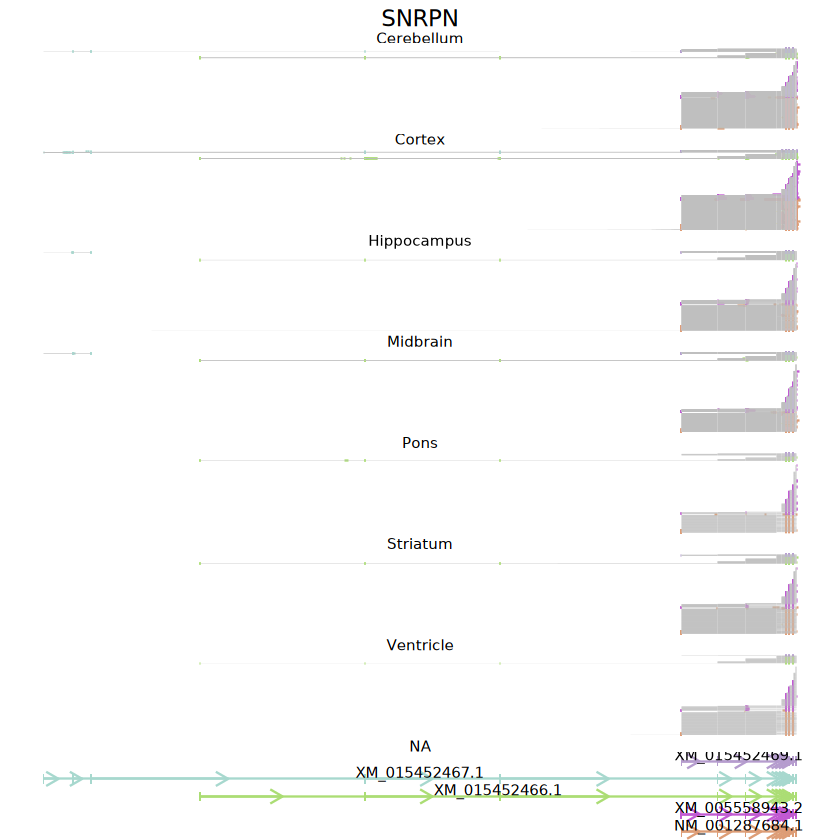

In [845]:
geneex = "SNRPN"
grtdfl = BuildPlotBed(fsraw.cor,longbed,"subcortical",geneex,NULL)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = T), error = function(e) NULL)
pci

In [574]:
#stat area conerved score
d2 = disref$DTU
d2g.ASD = d2[abs(d2$DTU.ASD.Value)> 1 & d2$DTU.ASD.p.value< 0.01,]
d2g.SCZ = d2[abs(d2$DTU.SCZ.Value)> 1 & d2$DTU.SCZ.p.value < 0.01,]
d2g.BD = d2[abs(d2$DTU.BD.Value)> 1 & d2$DTU.BD.p.value < 0.01,]

d2g.ASD = d2g.ASD[d2g.ASD$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.ASD$value = d2g.ASD$DTU.ASD.Value
d2g.SCZ = d2g.SCZ[d2g.SCZ$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.SCZ$value = d2g.SCZ$DTU.SCZ.Value
d2g.BD = d2g.BD[d2g.BD$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.BD$value = d2g.BD$DTU.BD.Value
d2gls = list("ASD" = d2g.ASD,"SCZ" = d2g.SCZ, "BD" = d2g.BD)

Mydtuvsref2 = function(isosigi,d2gls){
    isosigi = merge(isosigi,hgvmac.tmapf[,c("ref_id","qry_id")],by.x = "transcript_id",by.y = "qry_id")
    isosigi.hub = isosigi[isosigi$sig != "N",]
    isosigi = isosigi[isosigi$transcript_id %in% isosigi.hub$transcript_id,]
    isosigcmp = NULL
    
    for(i in 1:length(d2gls)){
        d2gi = d2gls[[i]]
        d2gi$sigref = "N"
        d2gi[d2gi$value > 1,]$sigref = "Up"
        d2gi[d2gi$value < (-1),]$sigref = "Down"
        d2gi = d2gi[,c("external_gene_id","ensembl_transcript_id","value","sigref")]
        isosigcmpi = merge(d2gi,isosigi,by.x = "ensembl_transcript_id",by.y = "ref_id")
        isosigcmpi$group = names(d2gls)[i]
        isosigcmpi$consist = "N"
        isosigcmpi[isosigcmpi$sigref == isosigcmpi$sig & isosigcmpi$sig %in% c("Up","Down"),]$consist = "Cons"
        isosigcmpi[isosigcmpi$sigref != isosigcmpi$sig & isosigcmpi$sig %in% c("Up","Down"),]$consist = "Rev"
        isosigcmp = rbind(isosigcmp,isosigcmpi)
    }
    return(isosigcmp)
}
isosigcmpt = NULL
for(i in 1:length(isosigls)){
    isosigi = isosigls[[i]]
    isosigcmpi = Mydtuvsref2(isosigi,d2gls)
    isosigcmpi$level = names(isosigls)[i]
    isosigcmpt = rbind(isosigcmpt,isosigcmpi)
}
isosigcmpt.st = isosigcmpt %>% group_by(level,group) %>% 
    mutate(genet = length(unique(gene_id)),
              transt = length(unique(transcript_id)))

isosigcmpt.st = isosigcmpt.st %>% group_by(level,group,areatr,consist) %>% 
    summarise(genen = length(unique(gene_id)),
              transn = length(unique(transcript_id)),
             genep = genen/genet,
             transp = transn/transt)

Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly."
`summarise()` has grouped output by 'level', 'group', 'areatr', 'consist'. You
can override using the `.groups` argument.


`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.


areatr    group cor         
1 GABA      ASD   -0.304772864
2 GABA      BD     0.023530928
3 GABA      SCZ    0.090765300
4 GLU       ASD    0.001605688
5 GLU       BD    -0.192417850
6 GLU       SCZ    0.015425195
7 NonNeuron ASD    0.155751489
8 NonNeuron BD     0.061867751
9 NonNeuron SCZ   -0.077935344

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-5.1293 -2.9193 -1.2896 -0.3222  2.2671  4.4220 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.355477 -0.071026  0.003462  0.010100  0.081237  0.342222 

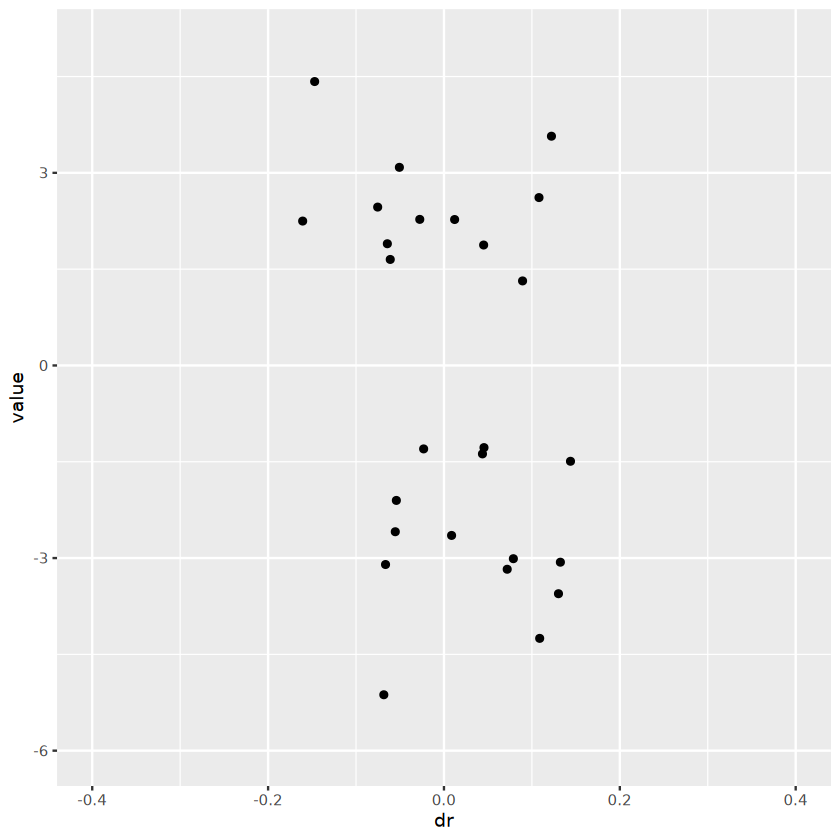

In [619]:
isosigcmpt[isosigcmpt$level == "class",] %>% group_by(areatr,group) %>% summarise(cor = cor(value,dr))

summary(isosigcmpt[isosigcmpt$areatr == "NonNeuron" & isosigcmpt$group == "ASD",]$value)
summary(isosigcmpt[isosigcmpt$areatr == "ASC" & isosigcmpt$group == "ASD",]$dr)
ggplot(isosigcmpt[isosigcmpt$areatr == "GABA" & isosigcmpt$group == "ASD",],
       aes(x = dr,y = value)) + geom_point() +
scale_x_continuous(limits = c(-0.4,0.4)) + scale_y_continuous(limits = c(-6,5))

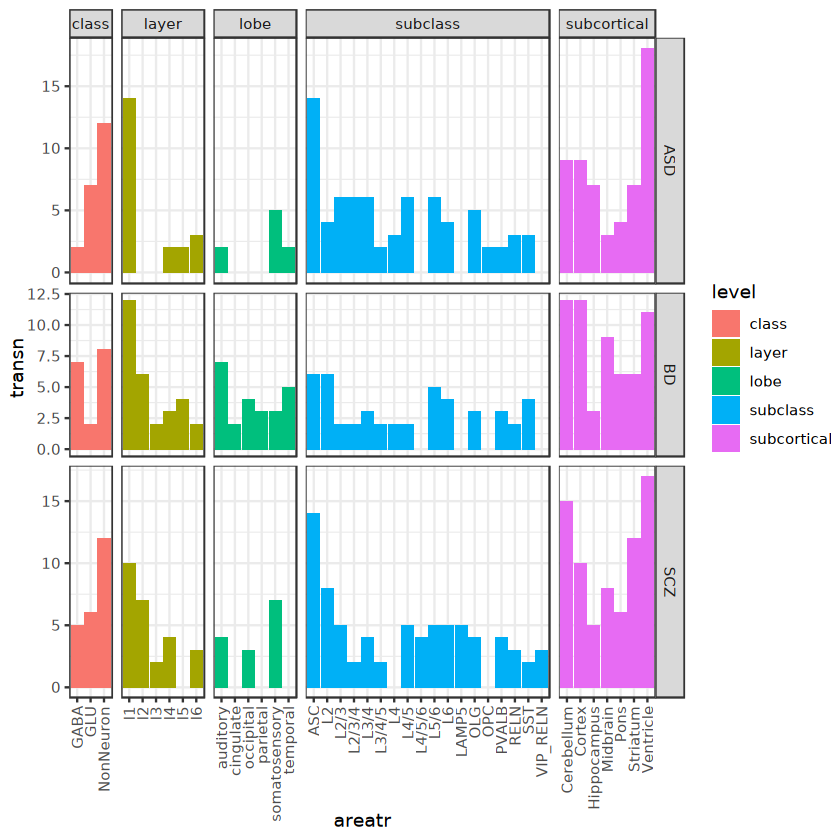

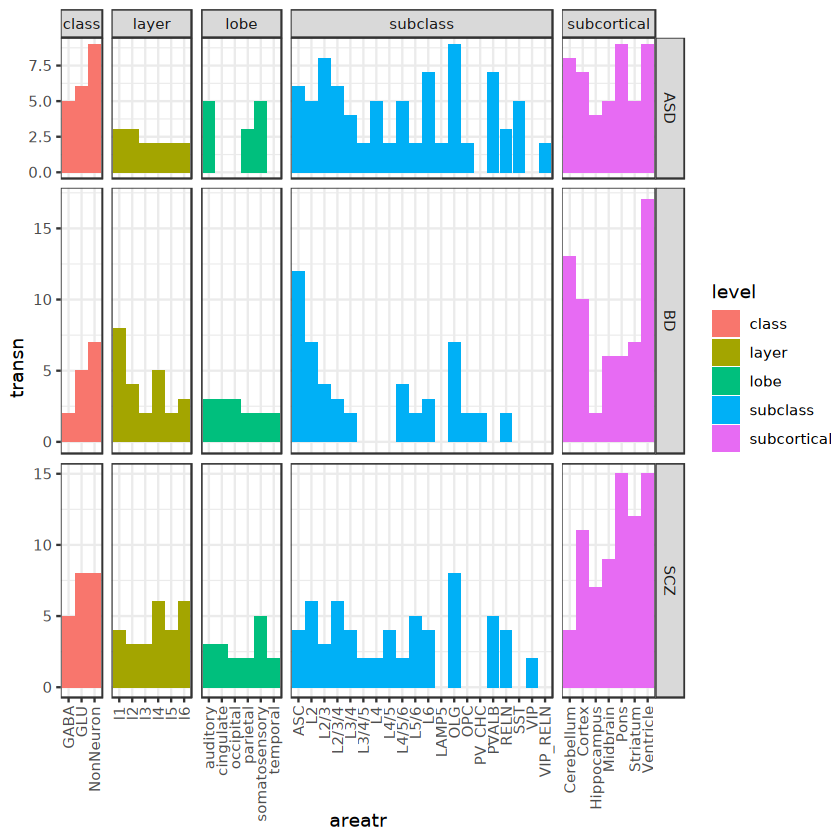

In [577]:
isosigcmpt.st.fil = isosigcmpt.st[isosigcmpt.st$genen > 1,]
ggplot(isosigcmpt.st.fil[isosigcmpt.st.fil$consist == "Cons" & !isosigcmpt.st.fil$level %in% "region",],aes(x = areatr,y = transn,fill = level)) +
    geom_bar(stat = "identity",position = "dodge") +
    facet_grid(group~level,space = "free",scales = "free") +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5,hjust = 1))
ggplot(isosigcmpt.st.fil[isosigcmpt.st.fil$consist == "Rev" & !isosigcmpt.st.fil$level %in% "region",],aes(x = areatr,y = transn,fill = level)) +
    geom_bar(stat = "identity",position = "dodge") +
    facet_grid(group~level,space = "free",scales = "free") +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5,hjust = 1))


In [893]:
ra = 200
fsraw.cor$xid = as.integer(fsraw.cor$x/(ra*2)) * ra * 2 + ra
fsraw.cor$yid = as.integer(fsraw.cor$y/(ra*2)) * ra * 2 + ra
fsraw.cor$blockid = paste0(fsraw.cor$xid,"_", fsraw.cor$yid)

In [894]:
fsraw.block = fsraw.cor %>% group_by(subcortical,layer,region,xid,yid,blockid,gene_id,transcript_id) %>% 
    summarise(readnum = length(readid))
head(fsraw.block)
fsraw.block.hub = fsraw.block[fsraw.block$transcript_id %in% hgvmac.tmapf$qry_id,]
nrow(fsraw.block)
nrow(fsraw.block.hub)

`summarise()` has grouped output by 'subcortical', 'layer', 'region', 'xid',
'yid', 'blockid', 'gene_id'. You can override using the `.groups` argument.


subcortical layer region xid  yid   blockid    gene_id   transcript_id 
1 Cerebellum  cb    cb     5800 84600 5800_84600 AARS      XM_005592535.2
2 Cerebellum  cb    cb     5800 84600 5800_84600 ABCD3     XM_005542668.2
3 Cerebellum  cb    cb     5800 84600 5800_84600 ACBD6     XM_005540148.2
4 Cerebellum  cb    cb     5800 84600 5800_84600 ADCYAP1R1 XM_015447551.1
5 Cerebellum  cb    cb     5800 84600 5800_84600 ADNP      XM_015429972.1
6 Cerebellum  cb    cb     5800 84600 5800_84600 AGTPBP1   XM_015437339.1
  readnum
1 3      
2 3      
3 3      
4 3      
5 3      
6 3

[1] 36084615

[1] 21682189

In [1062]:
isost = fsraw.block.hub %>% group_by(gene_id,transcript_id) %>% summarise(readnum = sum(readnum))
isost = isost %>% group_by(gene_id) %>% mutate(meanrelative = readnum/sum(readnum))
head(isost)

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


gene_id transcript_id  readnum meanrelative
1 A2ML1   XM_005570054.2   14    1.000000    
2 A3GALT2 XM_005544050.2   53    1.000000    
3 A4GALT  XM_015457102.1    4    1.000000    
4 AAAS    XM_005571000.2  967    1.000000    
5 AACS    NM_001284010.1 3799    0.883283    
6 AACS    XM_015430724.1  502    0.116717

In [1078]:
d1 = disref$DGE
d1g.ASD = d1[abs(d1$ASD.log2FC)> 1 & d1$ASD.p.value< 0.01,]
d1g.SCZ = d1[abs(d1$SCZ.log2FC)> 1 & d1$SCZ.p.value < 0.01,]
d1g.BD = d1[abs(d1$BD.log2FC)> 1 & d1$BD.p.value < 0.01,]
d1gls = list("ASD" = d1g.ASD,"SCZ" = d1g.SCZ, "BD" = d1g.BD)

d2 = disref$DTU
# d2g.ASD = d2[abs(d2$DTU.ASD.Value) > 1 & d2$DTU.ASD.p.value< 0.01,]
# d2g.ASD = d2[d2$external_gene_id %in% d2g.ASD$external_gene_id,]
# d2g.SCZ = d2[abs(d2$DTU.SCZ.Value) > 1 & d2$DTU.SCZ.p.value < 0.01,]
# d2g.SCZ = d2[d2$external_gene_id %in% d2g.SCZ$external_gene_id,]
# d2g.BD = d2[abs(d2$DTU.BD.Value) > 1 & d2$DTU.BD.p.value < 0.01,]
#d2g.BD = d2[d2$external_gene_id %in% d2g.BD$external_gene_id,]
d2g.ASD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.ASD$value = d2g.ASD$DTU.ASD.Value
d2g.SCZ = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.SCZ$value = d2g.SCZ$DTU.SCZ.Value
d2g.BD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.BD$value = d2g.BD$DTU.BD.Value
d2gls = list("ASD" = d2g.ASD,"SCZ" = d2g.SCZ, "BD" = d2g.BD)

CalDsscore = function(d2gi,fsraw.block.hub,isost){
    d2gi = d2gi[,c("external_gene_id","ensembl_transcript_id","value")]
    d2gi = merge(d2gi,hgvmac.tmapf,by.x = "ensembl_transcript_id",by.y = "ref_id")
    d2gi = unique(d2gi[,c("qry_gene_id","qry_id","value")])
    # spds.score = fsraw.block.hub[fsraw.block.hub$gene_id %in% d2gi$qry_gene_id,]
    # #spds.score = merge(fsraw.block.hub,d2gi,by.x = "transcript_id",by.y = "qry_id")
    # spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid,gene_id) %>% 
    #                         mutate(relative = readnum/sum(readnum))
    # spds.score = merge(spds.score,isost[,c("gene_id","transcript_id","meanrelative")],by = c("gene_id","transcript_id"))
    # spds.score$dr = spds.score$relative - spds.score$meanrelative 
    spds.score = merge(fsraw.block.hub,d2gi,by.x = "transcript_id",by.y = "qry_id")
    spds.score = spds.score[!is.na(spds.score$value),]
    spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid) %>% 
            summarise(readnumt = sum(readnum),genenum = length(unique(gene_id)),score = sum(value*readnum)/readnumt)
            #summarise(readnumt = sum(readnum),score = cor(dr,value),genenum = length(unique(gene_id)))
    # spds.score$type = "N"
    # spds.score[spds.score$value > 0,]$type = "Up"
    # spds.score[spds.score$value < 0,]$type = "Down"
    # fsraw.block.hub$score = 0
    # fsraw.block.hub[fsraw.block.hub$transcript_id %in% d2gi$qry_id,]$score = 1
    # #fsraw.block.hub[fsraw.block.hub$transcript_id %in% d2gi[d2gi$value < (-1),]$qry_id,]$score = -1
    # spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid) %>% 
    #     summarise(readnumt = sum(readnum),genenum = length(unique(gene_id)),score = sum(value*readnum)/readnumt)
    # spds.score = spds.score %>% group_by(subcortical,layer,region,xid,yid,blockid,type) %>% 
    #     summarise(readnum = sum(readnum),score = readnum/readnumt,readnumt = readnumt[1],genenum = genenum[1])
    return(spds.score)
    
}

CalDsscoreG = function(d2gi,fsraw.block.hub){
    fsraw.block.hub$score = 0
    fsraw.block.hub[fsraw.block.hub$gene_id %in% d2gi$gene_name,]$score = 1
    spds.score = fsraw.block.hub %>% group_by(subcortical,layer,region,xid,yid,blockid) %>% 
        summarise(score = sum(score*readnum)/sum(readnum),readnumt = sum(readnum),
                  genenum = length(unique(gene_id)))
    return(spds.score)
}
spds.scz = CalDsscore(d2gls$SCZ,fsraw.block.hub,isost)
spds.asd = CalDsscore(d2gls$ASD,fsraw.block.hub,isost)
spds.bd = CalDsscore(d2gls$BD,fsraw.block.hub,isost)

# spds.scz.g = CalDsscoreG(d1gls$SCZ,fsraw.block.hub)
# spds.asd.g = CalDsscoreG(d1gls$ASD,fsraw.block.hub)
# spds.bd.g = CalDsscoreG(d1gls$BD,fsraw.block.hub)

`summarise()` has grouped output by 'subcortical', 'layer', 'region', 'xid',
'yid'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'subcortical', 'layer', 'region', 'xid',
'yid'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'subcortical', 'layer', 'region', 'xid',
'yid'. You can override using the `.groups` argument.


In [1086]:
head(fsraw.cor)

readid                                                                                                               
1 00000033-e8ce-4144-8ded-93a772582329-14;st_ed:A:10616-11399;AD:A:adapterJ-adapterK;AP:A:Correct_739-763:+            
2 00000033-e8ce-4144-8ded-93a772582329-3;st_ed:A:1542-1993;AD:A:adapterD-adapterE;AP:A:Correct_413-432:+               
3 00000033-e8ce-4144-8ded-93a772582329-3;st_ed:A:1542-1993;AD:A:adapterD-adapterE;AP:A:Correct_413-432:+               
4 00000033-e8ce-4144-8ded-93a772582329-3;st_ed:A:1542-1993;AD:A:adapterD-adapterE;AP:A:Correct_413-432:+               
5 00000036-9da5-46f6-80c5-a6a0bee7474f-2;st_ed:A:646-1552;AD:A:adapterC-adapterD;AP:A:Correct_863-887:+                
6 0000009e-f52a-4eb5-97dd-4ad22c3acd50-4;st_ed:A:1918-2609;AD:A:adapterL-adapterN;AP:A:Jump|AD:A:no-split|ts-te:103-320
  origin_name cell_id cell_type_id subclass class transcript_id  gene_id x    
1 L-lv-v          NA  NA                          XM_005540610.2 NUCKS1  19690
2 L-cb-cb         NA  NA                          XM_005581643.2 MLLT3    7970
3 L-cb-cb         NA  NA                          XM_005581643.2 MLLT3    7970
4 L-cb-cb         NA  NA                          XM_005581643.2 MLLT3    7970
5 L-TEpv-l4       NA  NA                          GPX4-WeiLab-1  GPX4    37772
6 L-1|2-l5    996777  77           L4/5     GLU   XM_005582166.2 STXBP1  14185
  y     layer region lobe          subcortical readcount areatr     xid   yid  
1 62662 v     lv     NA            Ventricle    9933     Ventricle  19800 62600
2 88627 cb    cb     NA            Cerebellum   1966     Cerebellum  7800 88600
3 88627 cb    cb     NA            Cerebellum   1966     Cerebellum  7800 88600
4 88627 cb    cb     NA            Cerebellum   1966     Cerebellum  7800 88600
5 84660 l4    TEpv   temporal      Cortex       6884     Cortex     37800 84600
6 29617 l5    1|2    somatosensory Cortex      56275     Cortex     14200 29800
  blockid    
1 19800_62600
2 7800_88600 
3 7800_88600 
4 7800_88600 
5 37800_84600
6 14200_29800

In [1088]:
#in celltype
fsraw.cell = fsraw.cor[fsraw.cor$subclass != "",] %>% 
    group_by(class,subclass,gene_id,transcript_id) %>% 
    summarise(readnum = length(readid))
d2g.ASD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.ASD$value = d2g.ASD$DTU.ASD.Value
d2g.SCZ = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.SCZ$value = d2g.SCZ$DTU.SCZ.Value
d2g.BD = d2[d2$ensembl_transcript_id %in% hgvmac.tmapf$ref_id,]
d2g.BD$value = d2g.BD$DTU.BD.Value
d2gls = list("ASD" = d2g.ASD,"SCZ" = d2g.SCZ, "BD" = d2g.BD)

CalDsscoreCell = function(d2gi,fsraw.cell){
    d2gi = d2gi[,c("external_gene_id","ensembl_transcript_id","value")]
    d2gi = merge(d2gi,hgvmac.tmapf,by.x = "ensembl_transcript_id",by.y = "ref_id")
    d2gi = unique(d2gi[,c("qry_gene_id","qry_id","value")])
  
    spds.score = merge(fsraw.cell,d2gi,by.x = "transcript_id",by.y = "qry_id")
    spds.score = spds.score[!is.na(spds.score$value),]
    spds.score = spds.score %>% group_by(class,subclass) %>% 
            summarise(readnumt = sum(readnum),genenum = length(unique(gene_id)),score = sum(value*readnum)/readnumt)
    return(spds.score)
}
spds.scz.c = CalDsscoreCell(d2gls$SCZ,fsraw.cell)
spds.asd.c = CalDsscoreCell(d2gls$ASD,fsraw.cell)
spds.bd.c = CalDsscoreCell(d2gls$BD,fsraw.cell)

`summarise()` has grouped output by 'class', 'subclass', 'gene_id'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'class'. You can override using the
`.groups` argument.


In [ ]:
spds.scz.c$group = "SCZ"
spds.asd.c$group = "ASD"
spds.bd.c$group = "BD"
spdst.c = rbind(spds.scz.c,spds.asd.c,spds.bd.c)

groupid = c("ASD","SCZ","BD")
ptls = list()
for(i in 1:length(groupid)){
    pti = ggplot(spdst.c[spdst.c$readnumt > 1000 & spdst.c$group == groupid[i],],aes(x = class, y = score,fill = group))+
     # geom_jitter(shape=21,size=1,width=0.1) +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~group) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform disease similarity score(IDS)") + xlab("")
    ptls[[i]] = pti
}

ptt = ggarrange(plotlist = ptls,nrow = 1)
ptt

file saved to result/figure5/spatial_isoform_disease_associated_point_SCZ_25_03_20.pdf



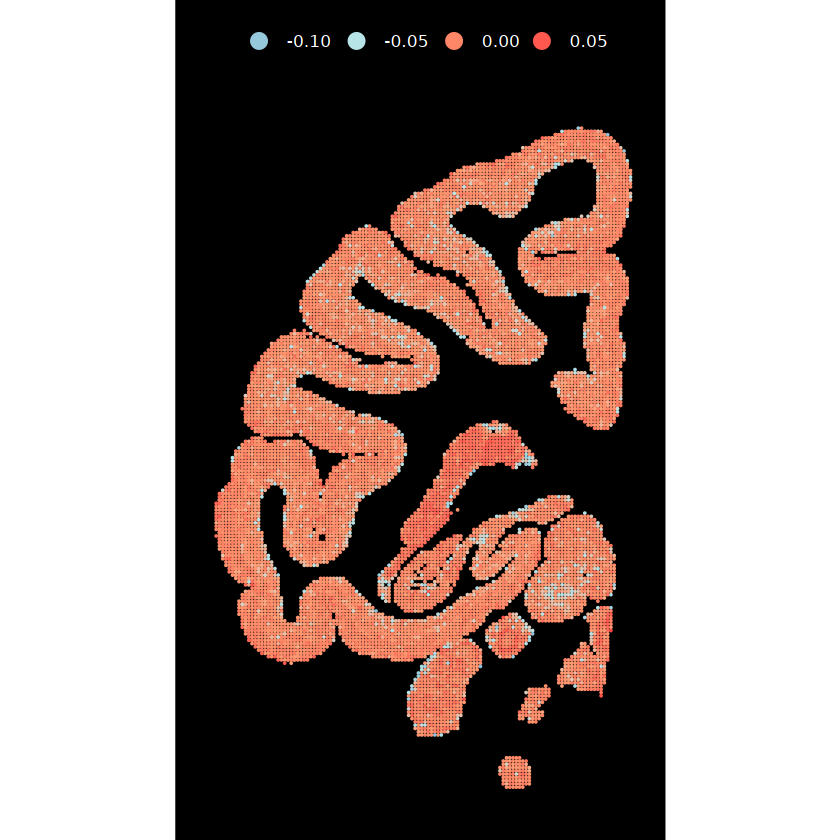

file saved to result/figure5/spatial_isoform_disease_associated_point_ASD_25_03_20.pdf



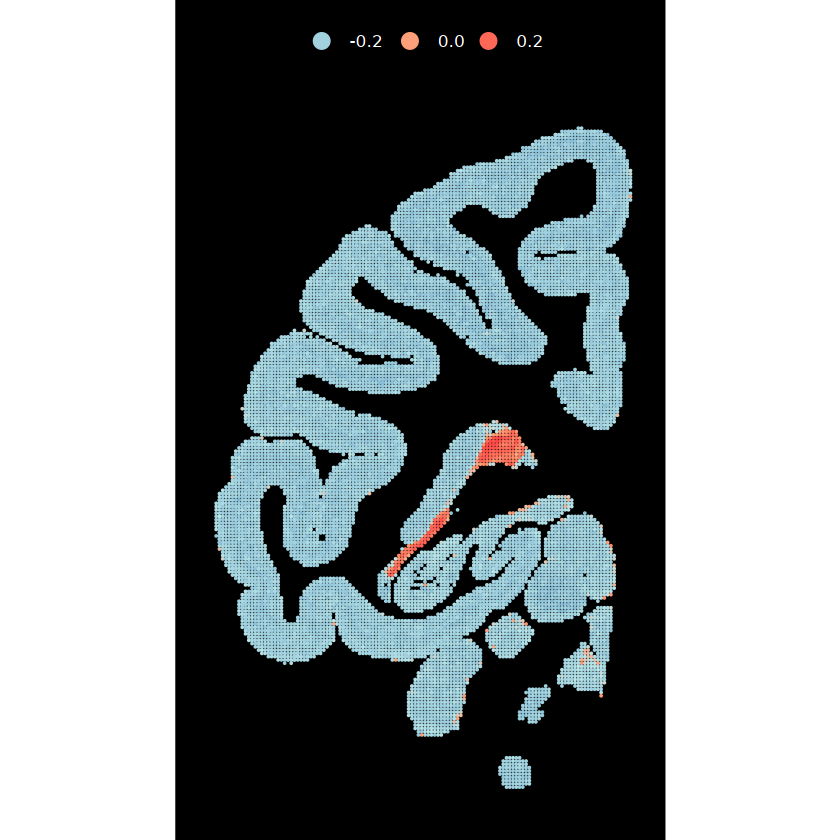

file saved to result/figure5/spatial_isoform_disease_associated_point_BD_25_03_20.pdf



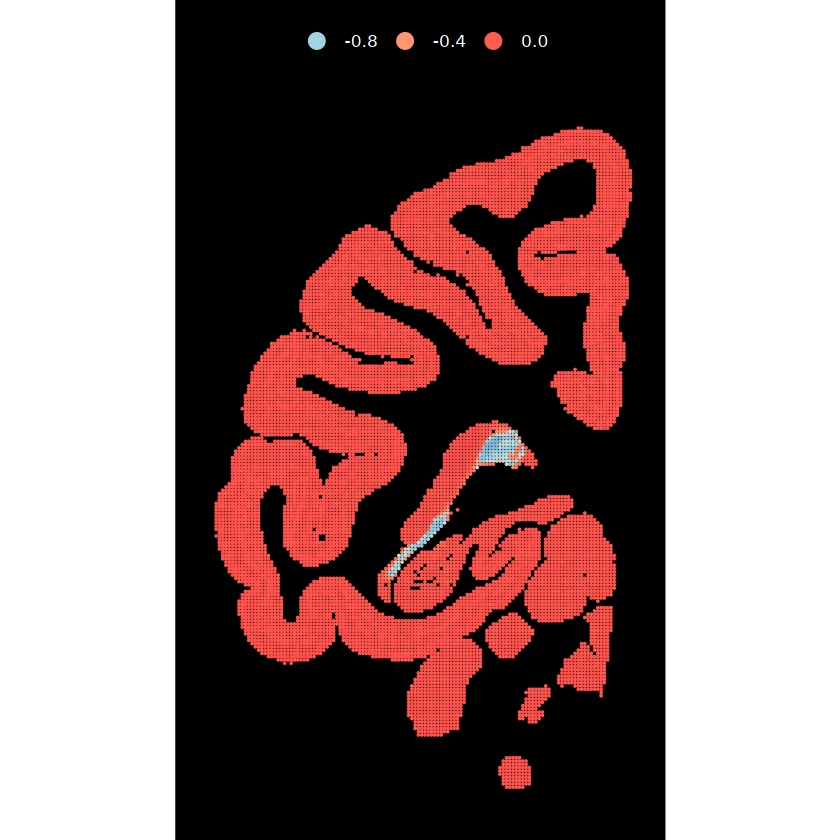

In [1079]:
colfunc1 <- colorRampPalette(c("#7AB2D3", "#B9E5E8"))
col1 = colfunc1(5)
colfunc2 <- colorRampPalette(c("#FF9C73", "#FF4545"))
col2 = colfunc2(5)

pmkpti = ggplot(spds.scz[spds.scz$readnumt > 1000,],aes(x = xid, y = yid,color = score)) +
      geom_point(size = 0.001) +
      theme_void() + 
      scale_colour_gradientn(colours = c(col1,col2)) +
        #limits = c(-0.5, 0.25) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 1),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
      coord_fixed()
pmkpti
ggexport(pmkpti,filename = "result/figure5/spatial_isoform_disease_associated_point_SCZ_25_03_20.pdf", width = 4,height = 6)

pmkpti = ggplot(spds.asd[spds.asd$readnumt > 1000,],aes(x = xid, y = yid,color = score)) +
      geom_point(size = 0.001) +
      theme_void() + 
      scale_colour_gradientn(colours = c(col1,col2)) +
        #limits = c(-0.5, 0.25) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 1),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
      coord_fixed()
pmkpti
ggexport(pmkpti,filename = "result/figure5/spatial_isoform_disease_associated_point_ASD_25_03_20.pdf", width = 4,height = 6)

pmkpti = ggplot(spds.bd[spds.bd$readnumt > 1000,],aes(x = xid, y = yid,color = score)) +
      geom_point(size = 0.001) +
      theme_void() + 
      scale_colour_gradientn(colours = c(col1,col2)) +
        #limits = c(-0.5, 0.25) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 10)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 1),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
      coord_fixed()
pmkpti
ggexport(pmkpti,filename = "result/figure5/spatial_isoform_disease_associated_point_BD_25_03_20.pdf", width = 4,height = 6)

file saved to result/figure5/spatial_isoform_disease_associated_point_total_boxplot_25_03_20.pdf



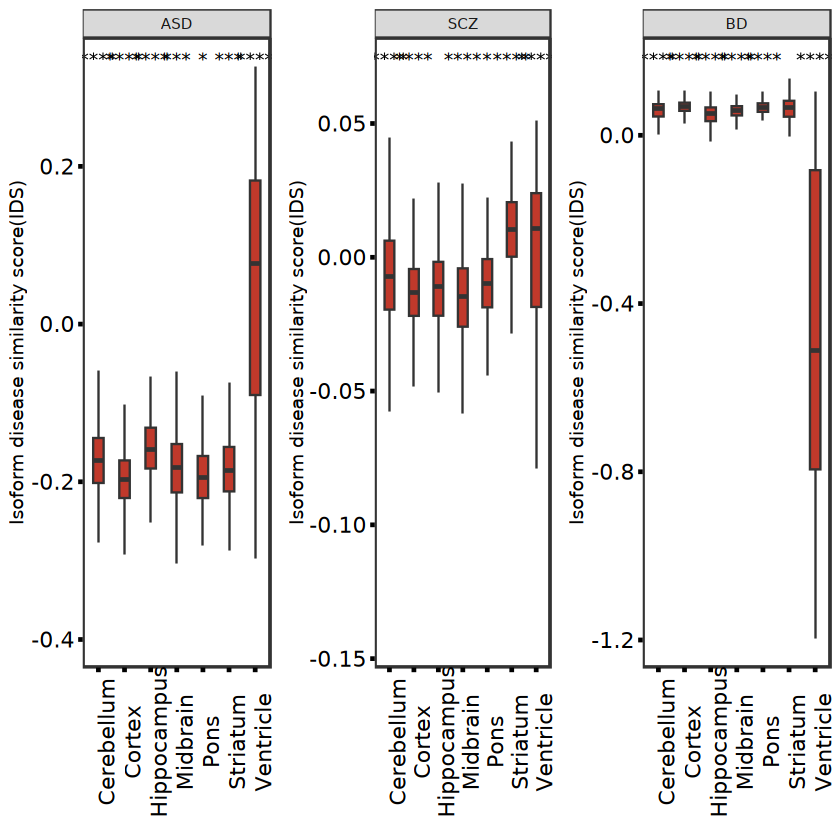

In [1080]:
#spds.score.st = spds.score %>% group_by(subcortical) %>% summarise(scorem = mean(score))
spds.scz$group = "SCZ"
spds.asd$group = "ASD"
spds.bd$group = "BD"
spdst = rbind(spds.scz,spds.asd,spds.bd)

groupid = c("ASD","SCZ","BD")
ptls = list()
for(i in 1:length(groupid)){
    pti = ggplot(spdst[spdst$readnumt > 1000 & spdst$group == groupid[i],],aes(x = subcortical, y = score,fill = group))+
     # geom_jitter(shape=21,size=1,width=0.1) +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~group) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform disease similarity score(IDS)") + xlab("")
    ptls[[i]] = pti
}

ptt = ggarrange(plotlist = ptls,nrow = 1)
ptt
ggexport(ptt,filename = "result/figure5/spatial_isoform_disease_associated_point_total_boxplot_25_03_20.pdf", width = 8,height = 4)

file saved to result/figure5/spatial_isoform_disease_associated_point_total_layer_boxplot_25_03_20.pdf



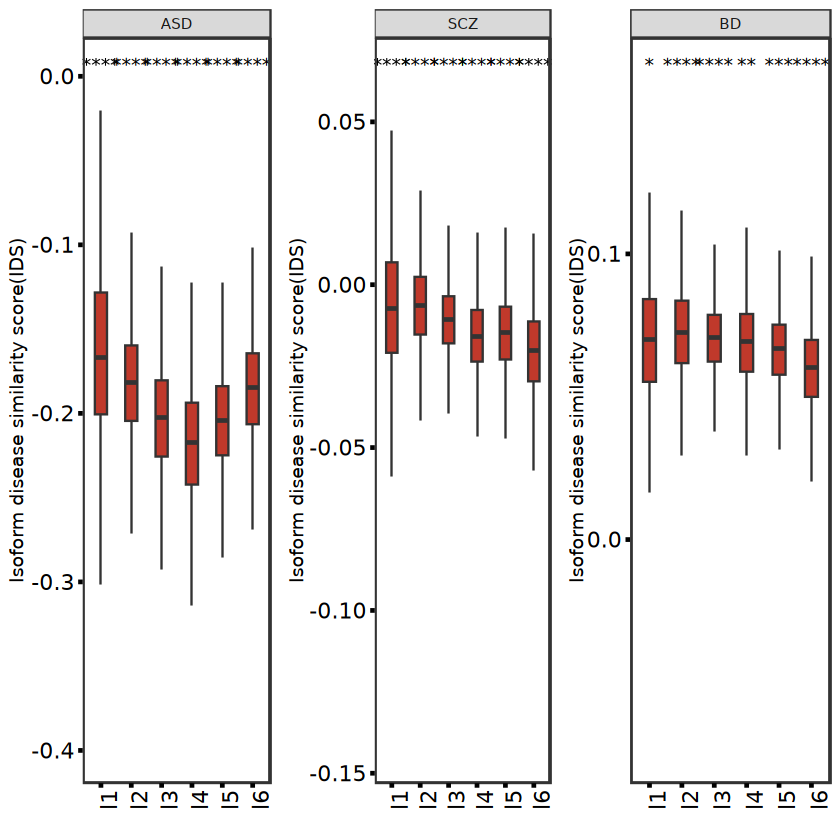

In [1081]:
#spds.score.st = spds.score %>% group_by(subcortical) %>% summarise(scorem = mean(score))
ptls = list()
for(i in 1:length(groupid)){
    pti = ggplot(spdst[spdst$readnumt > 1000 & spdst$group == groupid[i] & spdst$layer %in% paste0("l",1:6),],
                 aes(x = layer, y = score,fill = group))+
     # geom_jitter(shape=21,size=1,width=0.1) +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~group) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform disease similarity score(IDS)") + xlab("")
    ptls[[i]] = pti
}

ptt = ggarrange(plotlist = ptls,nrow = 1)
ptt
ggexport(ptt,filename = "result/figure5/spatial_isoform_disease_associated_point_total_layer_boxplot_25_03_20.pdf", width = 8,height = 4)

file saved to result/figure5/spatial_isoform_disease_associated_point_total_lobe_boxplot_25_03_20.pdf



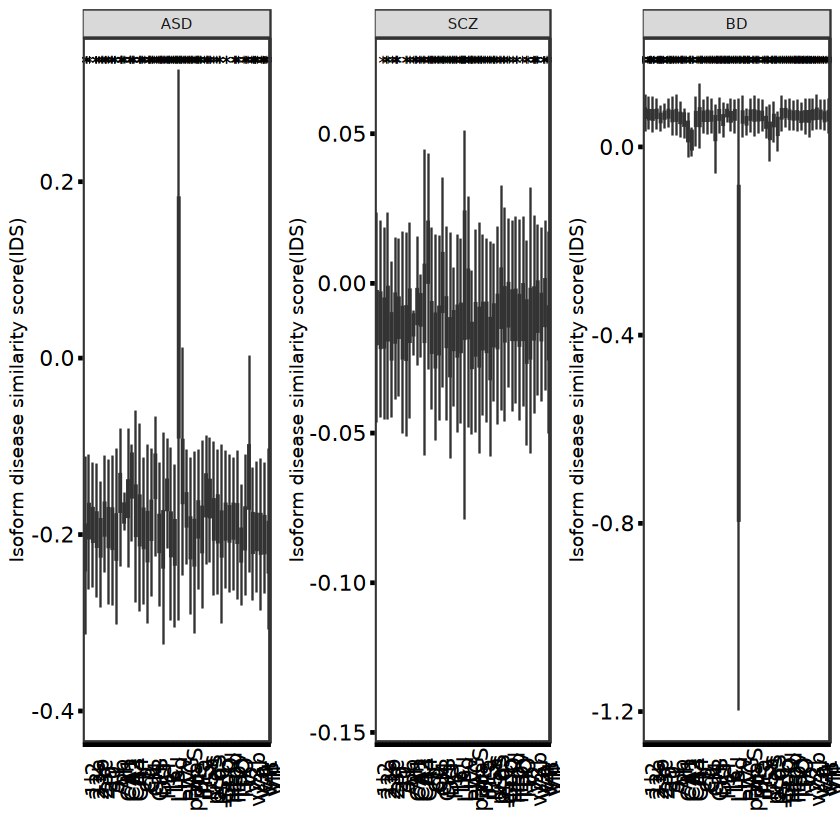

In [1084]:
#spds.score.st = spds.score %>% group_by(subcortical) %>% summarise(scorem = mean(score))
ptls = list()
for(i in 1:length(groupid)){
    pti = ggplot(spdst[spdst$readnumt > 1000 & spdst$group == groupid[i],],
                 aes(x = region, y = score,fill = group))+
     # geom_jitter(shape=21,size=1,width=0.1) +
      #geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      facet_grid(~group) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform disease similarity score(IDS)") + xlab("")
    ptls[[i]] = pti
}

ptt = ggarrange(plotlist = ptls,nrow = 1)
ptt
ggexport(ptt,filename = "result/figure5/spatial_isoform_disease_associated_point_total_lobe_boxplot_25_03_20.pdf", width = 8,height = 4)

##### Spatial and single cell case of MYL6 and CDC42

In [753]:
transtls = qread("data/reads_full_anotation/read_trans_stat_list_dedup_fsrawcor_24_09_04.qs")

In [ ]:
regionorder = c("29","30","23a","23b","31","23c","1|2","PE","PEa","VIP","LIPv","LIPd","PG","7op","CM","AI","CL","CPB","TPO",
               "PGa","FST","V4t","V4","TEO","TEpd","TEpv","TFO","V3v","V2","v23b")

In [840]:
TotalIsouse = function(transt){
    transt = transt[!is.na(transt$areatr),]
    transt = transt[transt$areatr != "",]
    transt$relative = transt$count/transt$genecount
    transtf = transt[transt$genecount > 10,]
    transtf = transt %>% group_by(transcript_id) %>% 
      mutate(meanrelative = mean(relative),
             otherrelative = (sum(relative) - relative)/(n() - 1))
    #transtf = transtf[which(transtf$meanrelative > 0.05),]

    # transtf = transtf %>% group_by(transcript_id) %>% 
    #    filter(length(unique(areatr)) > 1)
    # transtf = transtf %>% group_by(gene_id) %>% 
    #   filter(length(unique(transcript_id))>1)

    transtf$dr = transtf$relative - transtf$otherrelative
    return(transtf)
}

isosigi1 = TotalIsouse(transtls$subclass)
isosigi1$group = "subclass"
isosigi2 = TotalIsouse(transtls$class)
isosigi2$group = "class"
isosigi3 = TotalIsouse(transtls$layer)
isosigi3$group = "layer"
isosigi4 = TotalIsouse(transtls$subcortical)
isosigi4$group = "subcortical"
isosigi5 = TotalIsouse(transtls$region)
isosigi5$group = "region"
isosigi5$areatr = paste0("region-",isosigi5$areatr)
isosigt = rbind(isosigi1,isosigi2,isosigi3,isosigi4,isosigi5)
isosigt$areatr = factor(isosigt$areatr,c(suborder,c("GLU","GABA","NonNeuron"),layerorder,
                                         subcororder,paste0("region-",regionorder)))
isosigt = merge(isosigt,hgvmac.tmapf[,c("ref_id","qry_id")],by.x = "transcript_id",by.y = "qry_id")

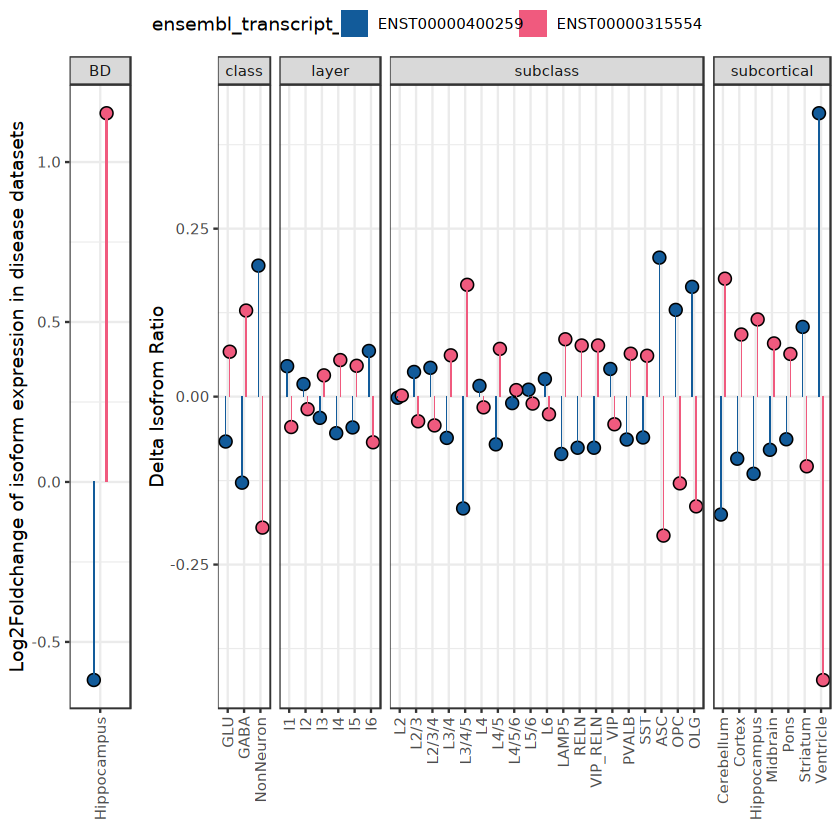

file saved to result/figure5/cross_species_case_subclass_stat_CDC42_25_03_15.pdf

file saved to result/figure5/cross_species_case_subclass_stat_MYL6_25_03_15.pdf



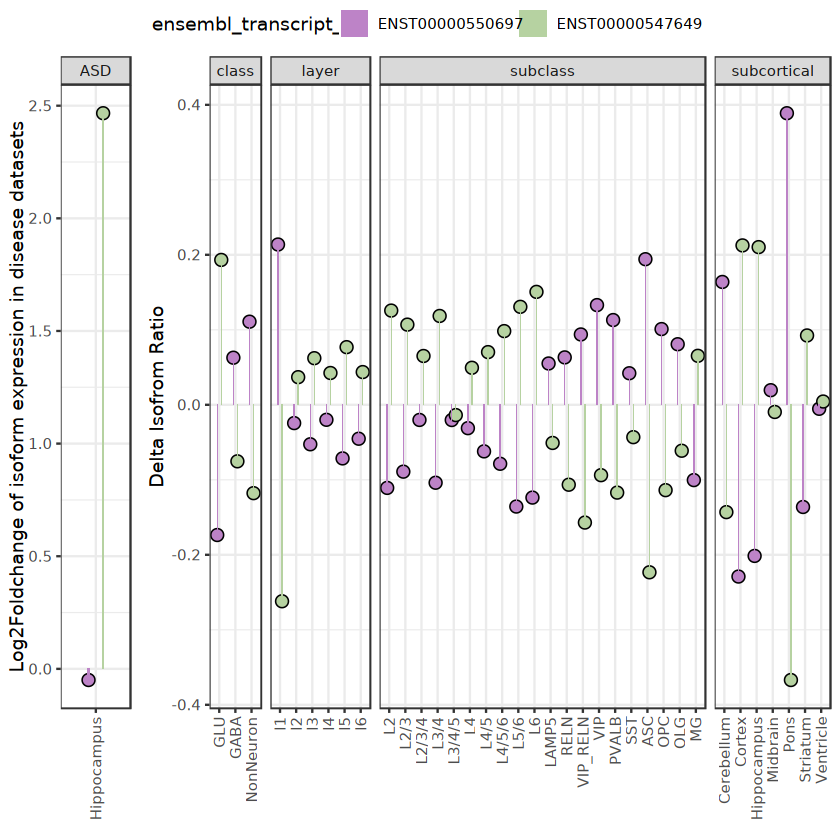

In [752]:

CrossSplicePlot = function(d2,geneid,transidref,isosigi,mycolors,diseaseid){
    refcase = d2[d2$ensembl_transcript_id %in% transidref,]
    refcase = refcase[,c("external_gene_id","ensembl_transcript_id","value")]
    #refcase = melt(refcase)
    refcase$xid = "Hippocampus"
    refcase$ensembl_transcript_id = factor(refcase$ensembl_transcript_id,levels = transidref)
    refcase$group = diseaseid
    p1.0 = ggplot(refcase,aes(x = xid,y = value,fill = ensembl_transcript_id)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        scale_fill_manual(values = mycolors) +
        facet_grid(~group,scales = "free",space = "free") +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) +
        xlab("") + 
    ylab("Log2Foldchange of isoform expression in disease datasets")
    #print(p1.0)

    isosigi = isosigi[isosigi$ref_id %in% transidref,]
    isosigi$ref_id = factor(isosigi$ref_id,levels = transidref)
    isosigi = isosigi[order(isosigi$ref_id),]
    isosigi$transcript_id = factor(isosigi$transcript_id,levels = unique(isosigi$transcript_id))
    
    p1.1 = ggplot(isosigi,aes(x = areatr,fill = transcript_id, y = dr)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        facet_grid(~group,scales = "free",space = "free") +
        scale_fill_manual(values = mycolors) +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + ylab("Delta Isofrom Ratio")
    p1.t = ggarrange(p1.0,p1.1,widths = c(0.3,1.5),common.legend = T)
    return(p1.t)
    
}
d2$value = d2$DTU.BD.Value
geneid = "CDC42"
mycolors = c("#125B9A","#F05A7E")
transidref = c("ENST00000400259","ENST00000315554")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt,mycolors,"BD")
pt1

d2$value = d2$DTU.ASD.Value
geneid = "MYL6"
mycolors = c("#BD83C7","#B6D2A1")
transidref = c("ENST00000550697","ENST00000547649")
pt2 = CrossSplicePlot(d2,geneid,transidref,isosigt,mycolors,"ASD")
pt2

ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CDC42_25_03_15.pdf",width = 7,height = 3)
ggexport(pt2,filename = "result/figure5/cross_species_case_subclass_stat_MYL6_25_03_15.pdf",width = 7,height = 3)

In [806]:
#isosigls$subclass[isosigls$subclass$gene_id == "CLTB",]
transidref = c("ENST00000397265","ENST00000305108")
unique(isosigt[isosigt$ref_id %in% transidref,c("transcript_id","ref_id")])

transcript_id  ref_id         
463760 XM_005569730.2 ENST00000305108
463826 XM_005569731.2 ENST00000397265

file saved to result/figure5/cross_species_case_subclass_stat_CLTA_ASD_25_03_15.pdf



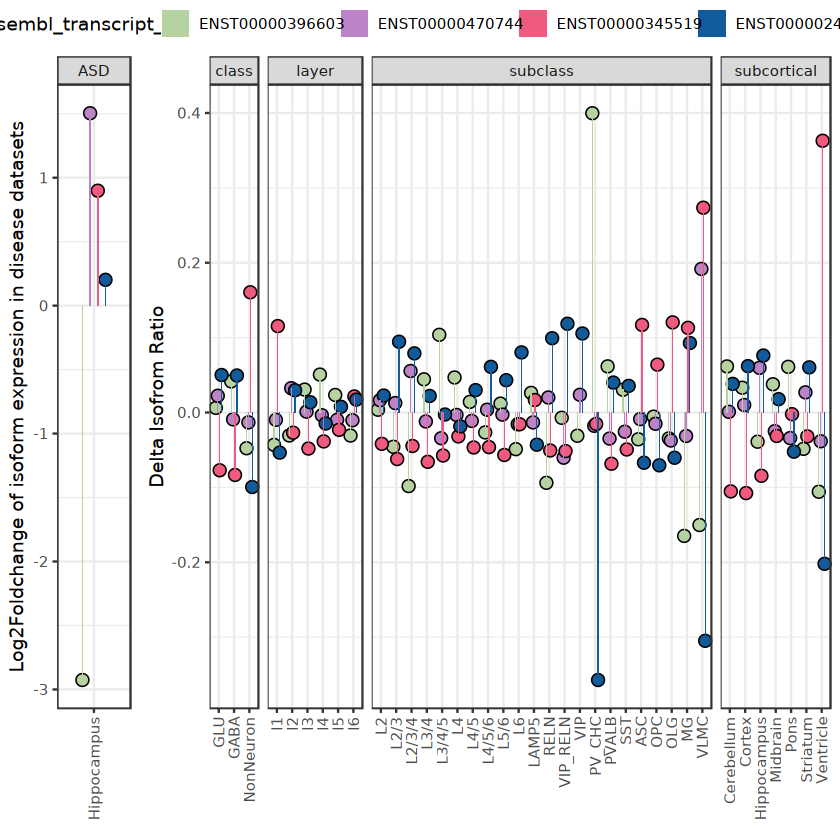

file saved to result/figure5/cross_species_case_subclass_stat_CLTA_BD_25_03_15.pdf



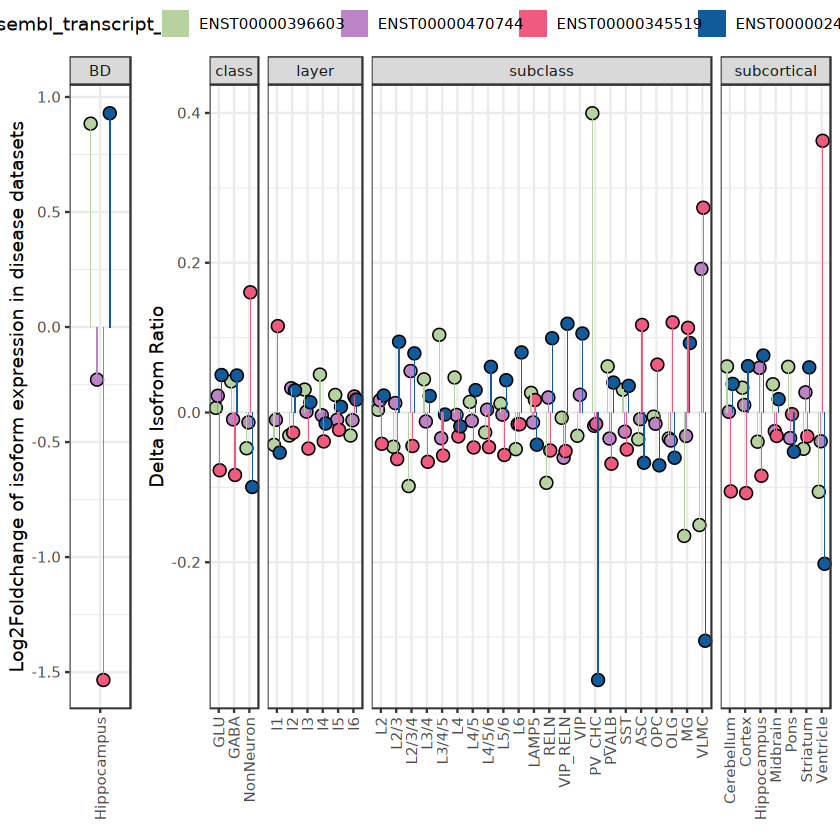

file saved to result/figure5/cross_species_case_subclass_stat_CLTB_ASD_25_03_15.pdf



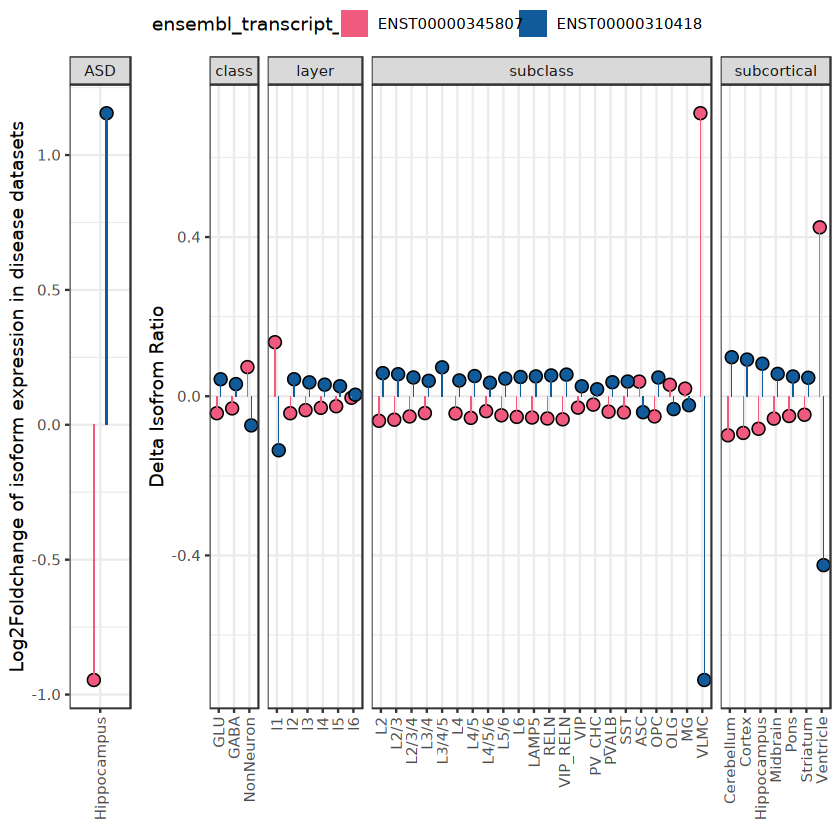

file saved to result/figure5/cross_species_case_subclass_stat_NINJ2_SCZ_25_03_15.pdf



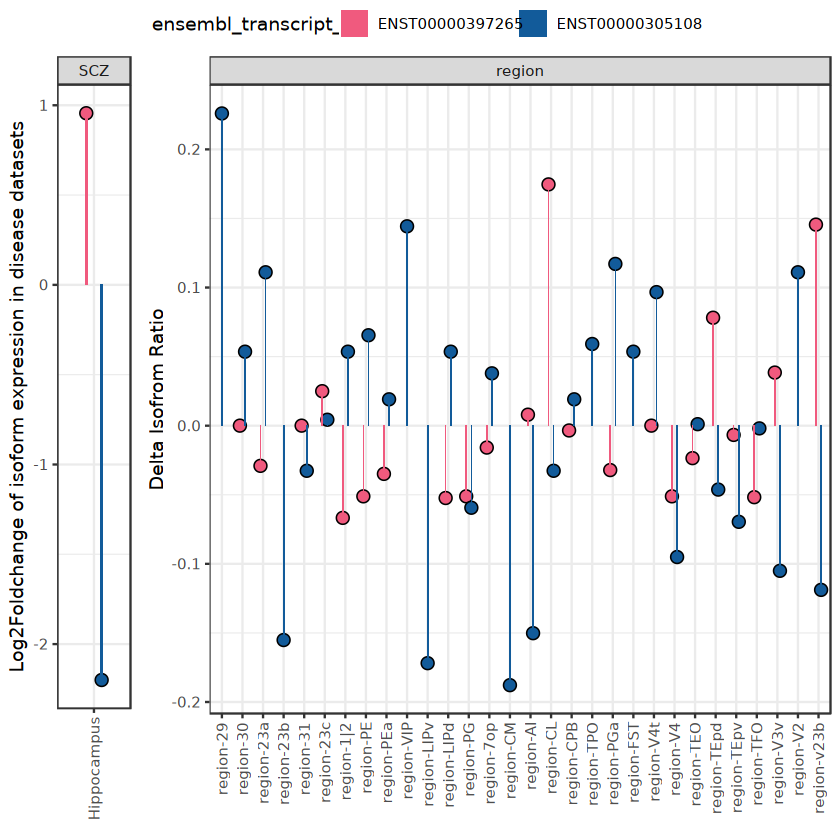

In [863]:
d2$value = d2$DTU.ASD.Value
geneid = "CLTA"
mycolors = c("#B6D2A1","#BD83C7","#F05A7E","#125B9A")
transidref = c("ENST00000396603","ENST00000470744","ENST00000345519","ENST00000242285")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group != "region",],mycolors,"ASD")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CLTA_ASD_25_03_15.pdf",width = 12,height = 4)

d2$value = d2$DTU.BD.Value
transidref = c("ENST00000396603","ENST00000470744","ENST00000345519","ENST00000242285")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group != "region",],mycolors,"BD")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CLTA_BD_25_03_15.pdf",width = 12,height = 4)

geneid = "CLTB"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000345807","ENST00000310418")
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group != "region",],mycolors,"ASD")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_CLTB_ASD_25_03_15.pdf",width = 12,height = 4)

geneid = "NINJ2"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000397265","ENST00000305108")
d2$value = d2$DTU.SCZ.Value
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group == "region",],mycolors,"SCZ")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_NINJ2_SCZ_25_03_15.pdf",width = 12,height = 4)


# d2$value = d2$DTU.ASD.Value
# geneid = "RWDD1"
# mycolors = c("#F05A7E","#125B9A")
# transidref = c("ENST00000487832","ENST00000392526")
# pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt,mycolors,"BD")
# pt1


file saved to result/figure5/cross_species_case_region_stat_SNRPN_SCZ_25_03_15.pdf



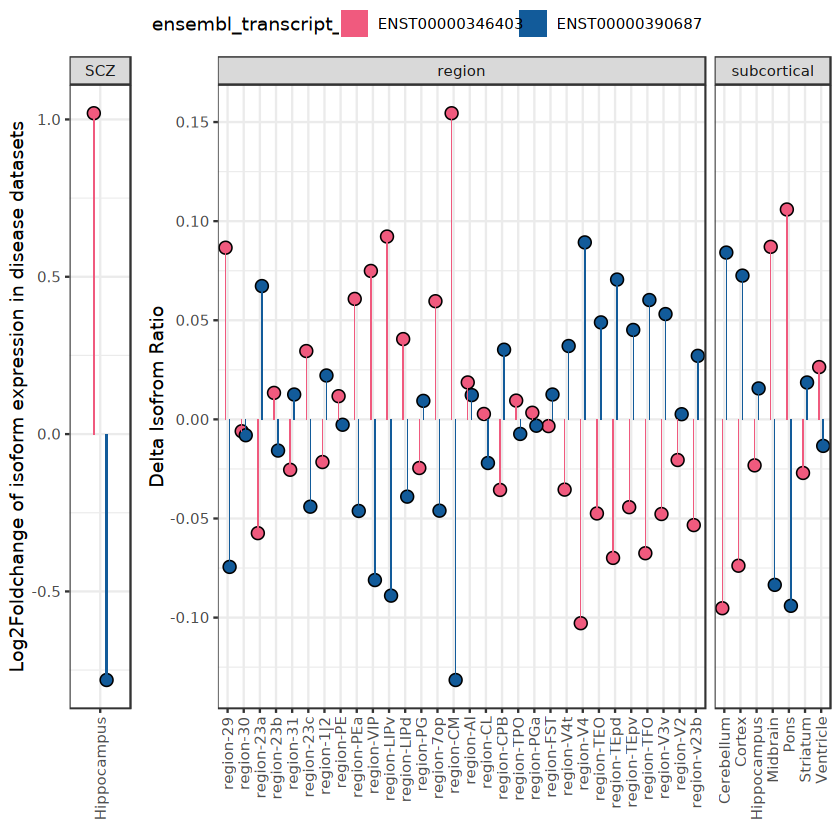

file saved to result/figure5/cross_species_case_subclass_stat_SNRPN_SCZ_25_03_15.pdf



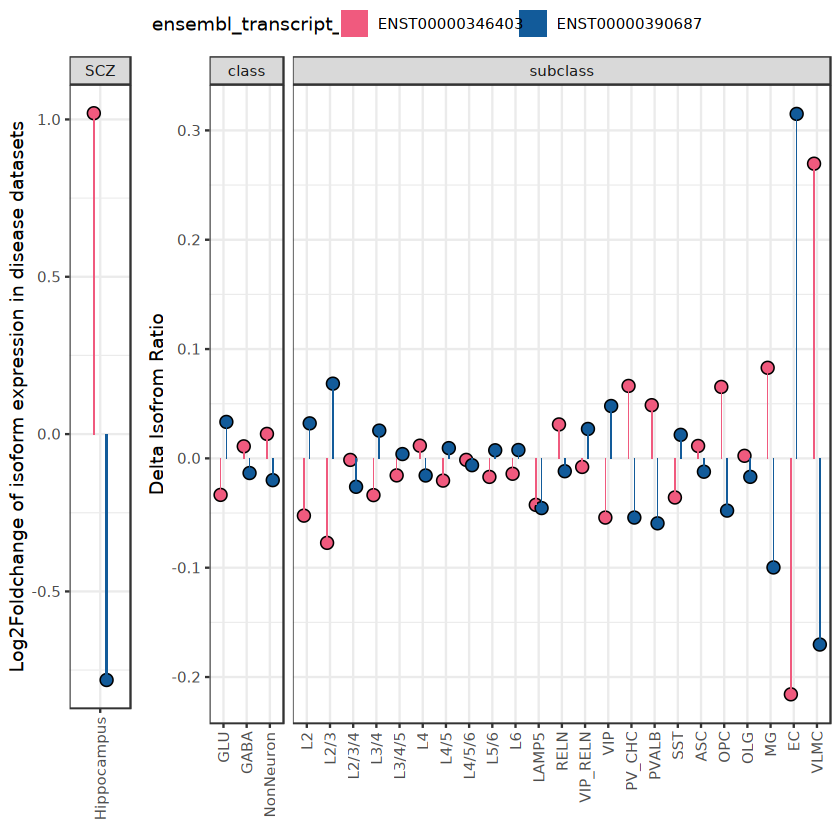

In [865]:
geneid = "SNRPN"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000346403","ENST00000390687")
d2$value = d2$DTU.SCZ.Value
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group %in% c("region","subcortical"),],mycolors,"SCZ")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_region_stat_SNRPN_SCZ_25_03_15.pdf",width = 12,height = 4)

geneid = "SNRPN"
mycolors = c("#F05A7E","#125B9A")
transidref = c("ENST00000346403","ENST00000390687")
d2$value = d2$DTU.SCZ.Value
pt1 = CrossSplicePlot(d2,geneid,transidref,isosigt[isosigt$group %in% c("subclass","class"),],mycolors,"SCZ")
pt1
ggexport(pt1,filename = "result/figure5/cross_species_case_subclass_stat_SNRPN_SCZ_25_03_15.pdf",width = 10,height = 4)


In [846]:
#unique(isosigcmpt[isosigcmpt$gene_id %in% "RSRP1",c("transcript_id","ref_id")])
hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "SNRPN",]

ref_gene_id        ref_id          class_code qry_gene_id qry_id        
32782 ENSG00000128739.16 ENST00000346403 =          SNRPN       XM_005558943.2
32784 ENSG00000128739.16 ENST00000390687 =          SNRPN       NM_001287684.1
      num_exons FPKM TPM cov len  major_iso_id   ref_match_len
32782 10        0    0   0   1304 XM_015452467.1 1304         
32784 10        0    0   0   1278 XM_015452467.1 1527

file saved to result/figure5/SNRPN-spatial_reads_point_25_03_18.pdf



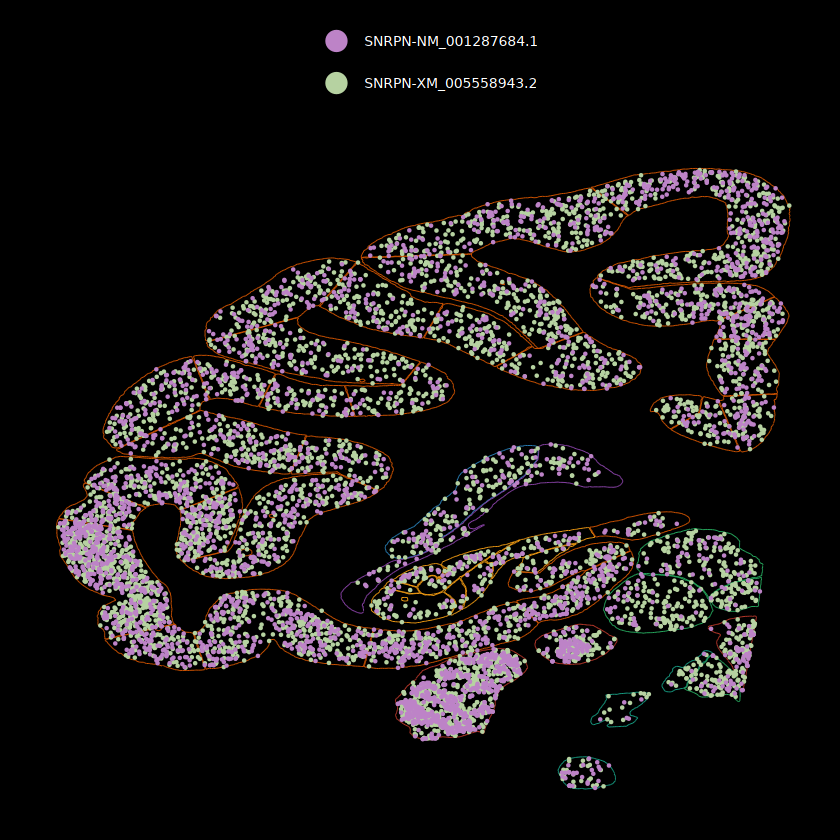

In [852]:
mycolor =  c('#BD83C7','#B6D2A1')
geneex = "SNRPN"
hubtrans = c("SNRPN-NM_001287684.1","SNRPN-XM_005558943.2")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 1,mycolor,0.1)
pci
ggexport(pci,filename = "result/figure5/SNRPN-spatial_reads_point_25_03_18.pdf", width = 4,height = 6)

Using external_gene_id, ensembl_transcript_id as id variables



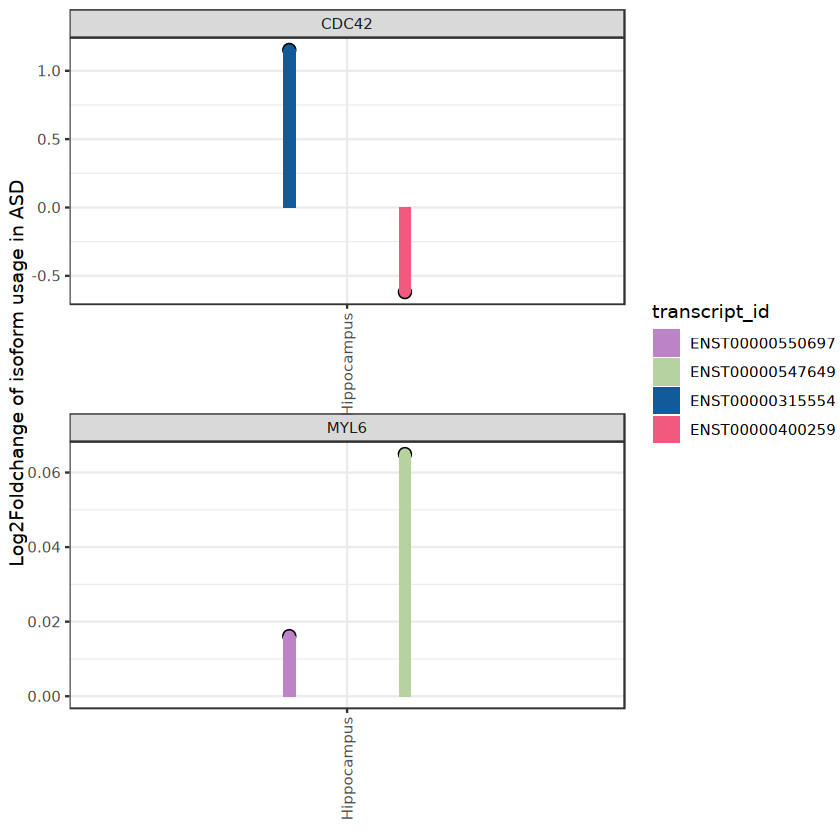

In [620]:
refcase = d2[d2$ensembl_transcript_id %in% c("ENST00000547649","ENST00000550697","ENST00000400259","ENST00000315554"),]
#MYL6-WeiLab-2 CDC42-WeiLab-1
mycolors = c("#B6D2A1","#BD83C7","#F05A7E","#125B9A")
names(mycolors) = c("ENST00000547649","ENST00000550697","ENST00000400259","ENST00000315554")

refcase = refcase[,c("external_gene_id","ensembl_transcript_id","DTU.BD.Value")]
refcase = melt(refcase)
colnames(refcase) = c("gene_id","transcript_id","sample","value")
refcase$xid = "Hippocampus"
refcase$transcript_id = factor(refcase$transcript_id,levels = c("ENST00000550697","ENST00000547649",
                                                                "ENST00000315554","ENST00000400259"))
p1.0 = ggplot(refcase,aes(x = xid,y = value,fill = transcript_id)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        scale_fill_manual(values = mycolors) +
        facet_wrap(~gene_id,ncol = 1,scales = "free") +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) +
        xlab("") + 
    ylab("Log2Foldchange of isoform usage in ASD")
p1.0
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
#isosigi


file saved to result/figure5/cross_species_case_subclass_stat_25_03_15.pdf



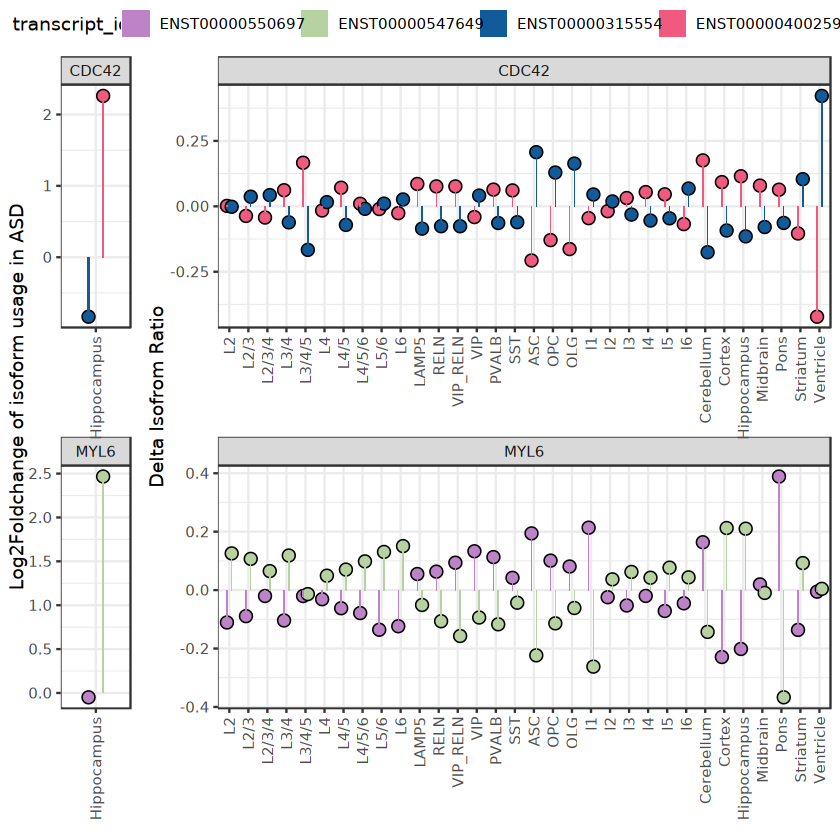

In [283]:
names(mycolors) = c("MYL6-WeiLab-2","MYL6-WeiLab-1", "CDC42-WeiLab-1", "NM_001283401.1")
isosigi = isosigls$subclass
isosigi = isosigi[isosigi$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
isosigi = isosigi %>% group_by(areatr) %>% filter(length(unique(transcript_id)) == 4)
isosigi$group = "subclass"

isosigi2 = isosigls$layer
isosigi2 = isosigi2[isosigi2$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
isosigi2$group = "layer"

isosigi3 = isosigls$subcortical
isosigi3 = isosigi3[isosigi3$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2", "CDC42-WeiLab-1", "NM_001283401.1"),]
isosigi3$group = "subcortical"

isosigi = rbind(isosigi,isosigi2,isosigi3)
isosigi$areatr = factor(isosigi$areatr,c(suborder,layerorder,subcororder))
p1.1 = ggplot(isosigi,aes(x = areatr,fill = transcript_id, y = dr)) + 
        geom_point(shape = 21,size = 3,position = position_dodge(0.5)) +
        geom_bar(stat = "identity",width = 0.05,color = NA,position = position_dodge(0.5)) +
        facet_wrap(~gene_id,ncol = 1,scales = "free") +
        scale_fill_manual(values = mycolors) +
        theme_bw() + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1)) + xlab("") + ylab("Delta Isofrom Ratio")
p1.t = ggarrange(p1.0,p1.1,widths = c(0.3,1.5),common.legend = T)
p1.t
ggexport(p1.t,filename = "result/figure5/cross_species_case_subclass_stat_25_03_15.pdf",width = 7,height = 5.5)

In [290]:
gtf.ms = rtracklayer::import("ref/mouse.gencode.vM36.annotation.gtf.gz")
hubtrans = c("ENST00000550697.6","ENST00000547649.5")
#"gencode.v19.annotation.gtf.gz"
gtf.hp = rtracklayer::import("ref/human.gencode.v47.annotation.gtf.gz")
hubtrans = c("ENST00000550697.6","ENST00000547649.5")
gtf.hp[gtf.hp$gene_name == "MYL6" & gtf.hp$transcript_id %in% hubtrans,]
unique(gtf.ms[gtf.ms$gene_name == "Myl6",]$transcript_name)

GRanges object with 36 ranges and 22 metadata columns:
       seqnames            ranges strand |   source        type     score
          <Rle>         <IRanges>  <Rle> | <factor>    <factor> <numeric>
   [1]    chr12 56158359-56161579      + |   HAVANA transcript         NA
   [2]    chr12 56158359-56158404      + |   HAVANA exon               NA
   [3]    chr12 56158402-56158404      + |   HAVANA CDS                NA
   [4]    chr12 56158402-56158404      + |   HAVANA start_codon        NA
   [5]    chr12 56158684-56158711      + |   HAVANA exon               NA
   ...      ...               ...    ... .      ...         ...       ...
  [32]    chr12 56161387-56161574      + |   HAVANA  exon              NA
  [33]    chr12 56161387-56161412      + |   HAVANA  CDS               NA
  [34]    chr12 56161413-56161415      + |   HAVANA  stop_codon        NA
  [35]    chr12 56158362-56158401      + |   HAVANA  UTR               NA
  [36]    chr12 56161413-56161574      + |   HAVANA  UTR 

[1] NA         "Myl6-201" "Myl6-213" "Myl6-212" "Myl6-202" "Myl6-206"
 [7] "Myl6-209" "Myl6-211" "Myl6-205" "Myl6-203" "Myl6-214" "Myl6-208"
[13] "Myl6-215" "Myl6-207" "Myl6-210" "Myl6-204"

In [292]:
library(ggbio)
library(ggtranscript)

#Txrefplot(gtfdf)
Txrefplot = function(gtfdf,groupid,mycolor = NULL){
    tartrans = gtfdf[gtfdf$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_name),]
    tartrans$orid = as.numeric(tartrans$transcript_name)
#    tartrans$group = NA
    tartranstx = tartrans %>% group_by(transcript_name,orid) %>% 
      summarise(start = min(start),end = max(end))
    #tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    if(is.null(mycolor)){
        no_of_colors = length(unique(tartrans$transcript_name)) 
        colorful_palette = distinctColorPalette(no_of_colors) 
        names(colorful_palette) = levels(tartrans$transcript_name)
    }else{
        colorful_palette = mycolor
        names(colorful_palette) = levels(tartrans$transcript_name)
    }
    
    pc = ggplot() +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_name,color = transcript_name),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_name"),
                  aes(xstart = start,xend = end,y = orid,strand = strand,color = transcript_name),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid+0.5,
                    label = transcript_name),
                size = 5, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      #facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "left") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      # scale_color_discreterainbow() +
      theme_bw() + 
      ggtitle(groupid) +
      theme(legend.position = "none",panel.grid = element_blank(),
            axis.text.y = element_blank(),axis.ticks.y = element_blank(),
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
            strip.placement = "outside",
            plot.title = element_text(hjust = 0.5)) + xlab("") + ylab("")
    pc
    return(pc)
}

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
Warning message:
"Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead."
file saved to result/figure5/MYL6-cross_species_sliced_compare_25_03_18.pdf



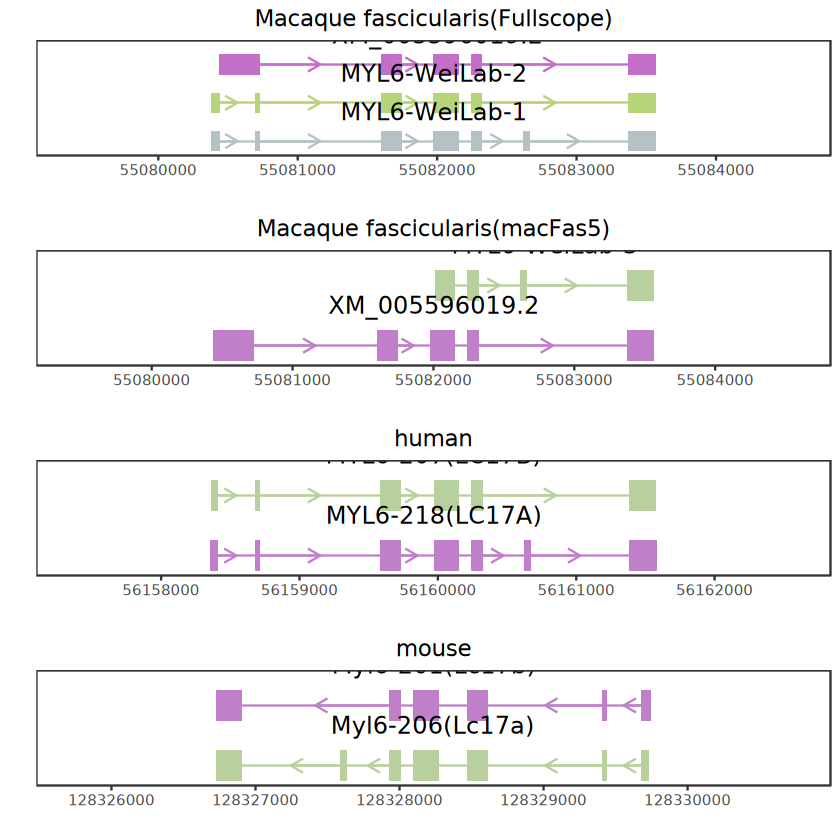

R packages available

Packages in library '/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library':

abind                   Combine Multidimensional Arrays
ade4                    Analysis of Ecological Data: Exploratory and
                        Euclidean Methods in Environmental Sciences
admixtools              Inferring demographic history from genetic data
amap                    Another Multidimensional Analysis Package
annotate                Annotation for microarrays
AnnotationDbi           Manipulation of SQLite-based annotations in
                        Bioconductor
AnnotationFilter        Facilities for Filtering Bioconductor
                        Annotation Resources
AnnotationHub           Client to access AnnotationHub resources
anytime                 Anything to 'POSIXct' or 'Date' Converter
ape                     Analyses of Phylogenetics and Evolution
aplot                   Decorate a 'ggplot' with Associated Information
arrow             

In [296]:
library()
geneex = "MYL6"
hubtrans = c("MYL6-WeiLab-1","MYL6-WeiLab-2","XM_005596019.2")
gtfdf = as.data.frame(gtf[which(gtf$gene_id == geneex & gtf$transcript_name %in% hubtrans),])
gtfdf$transcript_name = factor(gtfdf$transcript_name,levels = c("MYL6-WeiLab-1","MYL6-WeiLab-2","XM_005596019.2"))
groupid = "Macaque fascicularis(Fullscope)"
pc1 = Txrefplot(gtfdf,groupid)

geneex = "MYL6"
hubtrans = c("XM_005596019.2","MYL6-WeiLab-3")
gtfdf = as.data.frame(gtf[which(gtf$gene_id == geneex & gtf$transcript_name %in% hubtrans),])
gtfdf$transcript_name = factor(gtfdf$transcript_name,levels = c("XM_005596019.2","MYL6-WeiLab-3"))
groupid = "Macaque fascicularis(macFas5)"
pc2 = Txrefplot(gtfdf,groupid)

#human
hubtrans = c("ENST00000550697.6","ENST00000547649.5")
gtfdf.hp = as.data.frame(gtf.hp[gtf.hp$gene_name == "MYL6" & gtf.hp$transcript_id %in% hubtrans,])
gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-218",]$transcript_name = paste0(gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-218",]$transcript_name,
                                                                          ("(LC17A)"))
gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-207",]$transcript_name = paste0(gtfdf.hp[gtfdf.hp$transcript_name == "MYL6-207",]$transcript_name,
                                                                          ("(LC17B)"))
#https://www.ncbi.nlm.nih.gov/nuccore/NM_079423.4
#https://www.ncbi.nlm.nih.gov/nuccore/NM_021019.5
gtfdf.hp$transcript_name = factor(gtfdf.hp$transcript_name,levels = c("MYL6-218(LC17A)","MYL6-207(LC17B)")) 
groupid = "human"
pc3 = Txrefplot(gtfdf.hp,groupid)

#mouse
hubtrans = c("Myl6-206","Myl6-201")
gtfdf.ms = as.data.frame(gtf.ms[gtf.ms$gene_name == "Myl6" & gtf.ms$transcript_name %in% hubtrans,])
gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-206",]$transcript_name = paste0(gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-206",]$transcript_name,
                                                                          ("(Lc17a)"))
gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-201",]$transcript_name = paste0(gtfdf.ms[gtfdf.ms$transcript_name == "Myl6-201",]$transcript_name,
                                                                          ("(Lc17b)"))
hubtrans = c("Myl6-206(Lc17a)","Myl6-201(Lc17b)")
gtfdf.ms = gtfdf.ms[order(gtfdf.ms$transcript_name),]
# gtfdf.ms$start = -gtfdf.ms$start
# gtfdf.ms$end = -gtfdf.ms$end
# gtfdf.ms$strand = "+"
gtfdf.ms$transcript_name = factor(gtfdf.ms$transcript_name,levels = hubtrans) 
groupid = "mouse"
pc4 = Txrefplot(gtfdf.ms,groupid)
pct = ggarrange(pc1,pc2,pc3,pc4,ncol = 1)
pct
ggexport(pct,filename = "result/figure5/MYL6-cross_species_sliced_compare_25_03_18.pdf",width = 8,height = 6)

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


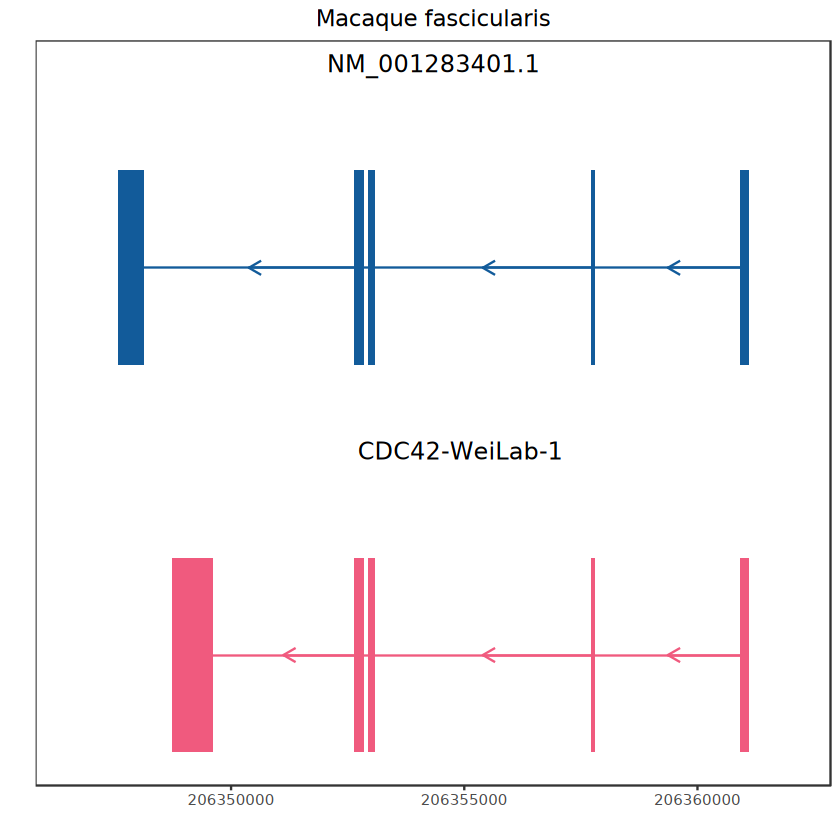

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


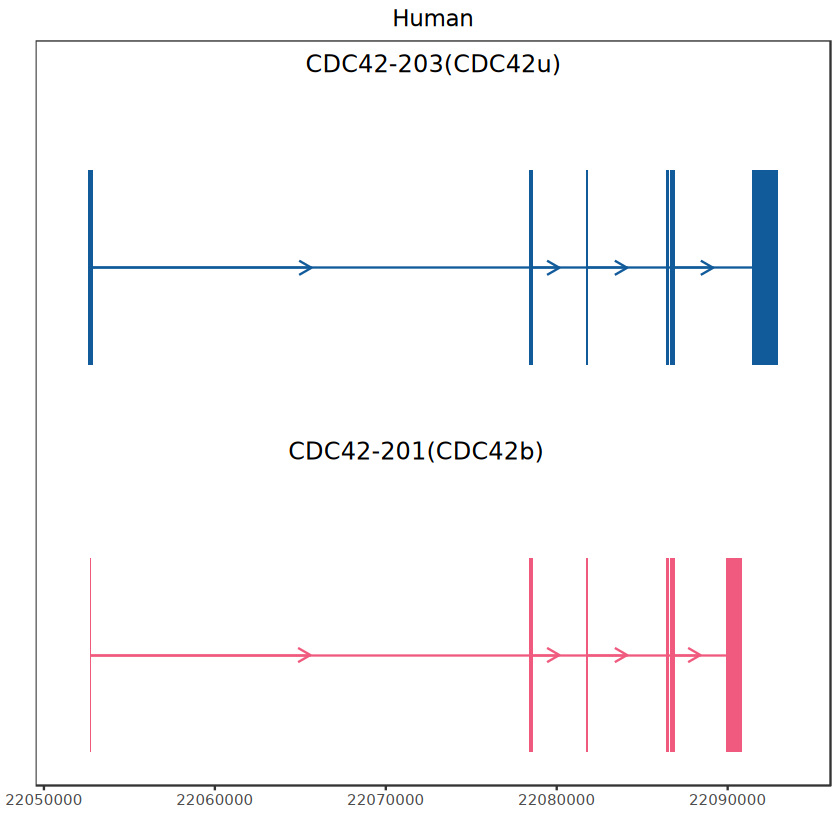

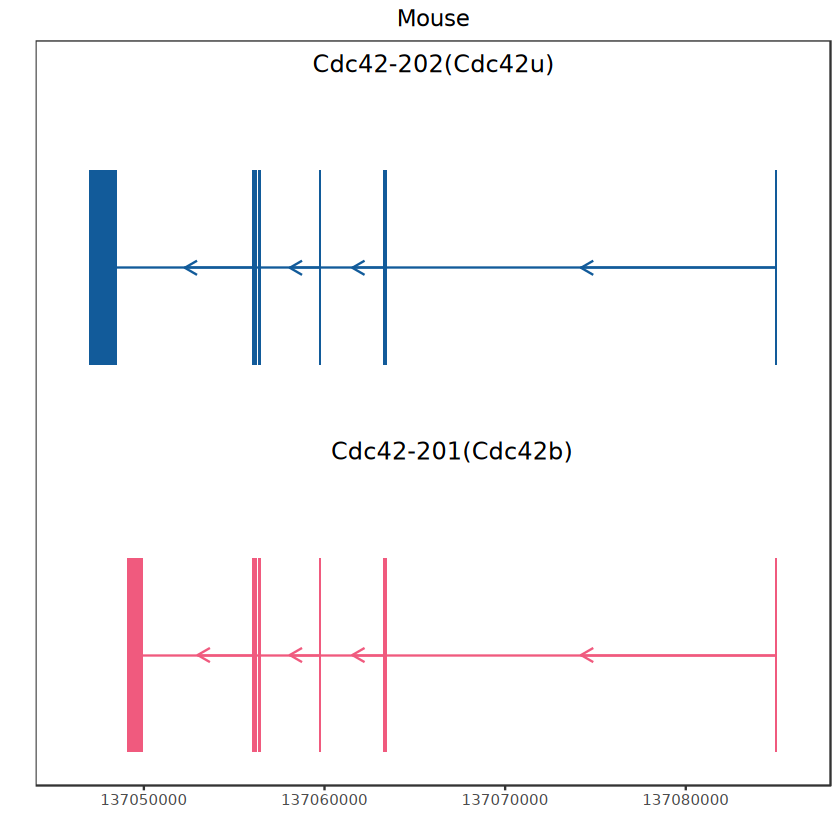

file saved to result/figure5/CDC42-cross_species_sliced_compare_24_12_24.pdf



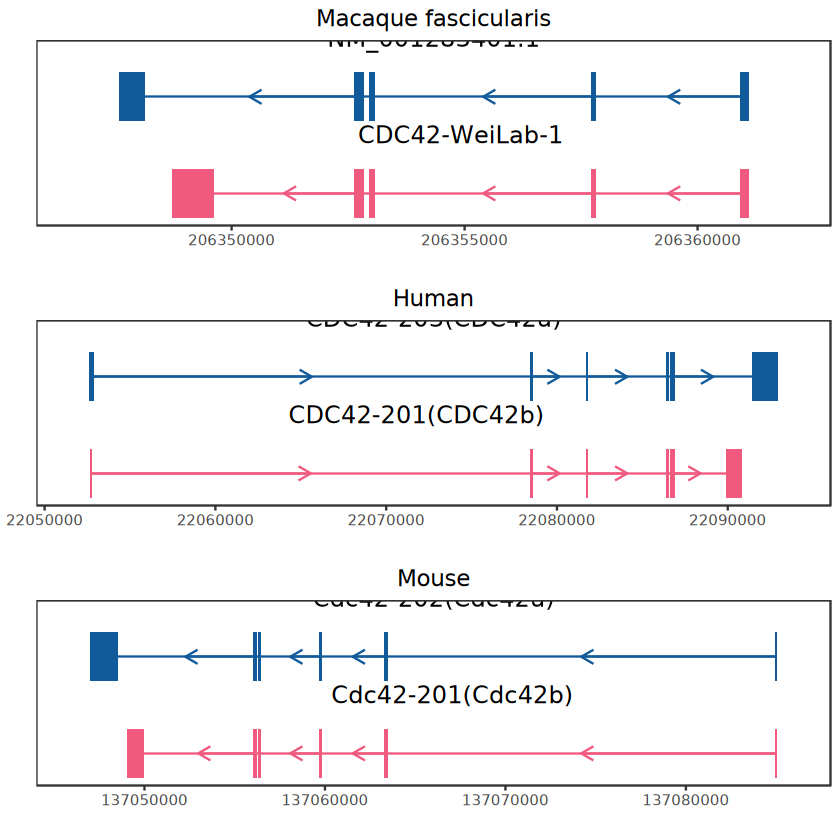

In [146]:
#"ENST00000400259","ENST00000315554"
#"CDC42b" "CDC42u"
geneex = "CDC42"
mycolor = c("#F05A7E","#125B9A")
#hubtrans = c("MYL6-WeiLab-1","MYL6-WeiLab-2")
gtfdf = as.data.frame(gtf[which(gtf$gene_id == geneex),])
gtfdf$transcript_name = factor(gtfdf$transcript_name,levels = c("CDC42-WeiLab-1","NM_001283401.1"))
groupid = "Macaque fascicularis"
pc1 = Txrefplot(gtfdf,groupid,mycolor)
pc1

hubtrans = c("ENST00000400259.5","ENST00000315554.15")
#gtf.hp[gtf.hp$gene_name == "CDC42" & gtf.hp$transcript_id %in%  hubtrans & gtf.hp$type == "transcript",]
gtfdf.hp.hub = as.data.frame(gtf.hp[gtf.hp$gene_name == "CDC42" & gtf.hp$transcript_id %in% hubtrans,])
gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-203",]$transcript_name = paste0(gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-203",]$transcript_name,
                                                                          "(CDC42u)")
gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-201",]$transcript_name = paste0(gtfdf.hp.hub[gtfdf.hp.hub$transcript_name == "CDC42-201",]$transcript_name,
                                                                          "(CDC42b)")
gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = c("CDC42-201(CDC42b)","CDC42-203(CDC42u)")) 
#gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = unique(gtfdf.hp.hub$transcript_name)) 
groupid = "Human"
pc2 = Txrefplot(gtfdf.hp.hub,groupid,mycolor)
pc2
#hubtrans = c("ENST00000400259.5","ENST00000315554.15")
#gtf.hp[gtf.hp$gene_name == "CDC42" & gtf.hp$transcript_id %in%  hubtrans & gtf.hp$type == "transcript",]
gtfdf.ms.hub = as.data.frame(gtf.ms[gtf.ms$gene_name == "Cdc42",])
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub = gtfdf.ms.hub[!is.na(gtfdf.ms.hub$transcript_name),]
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-202",]$transcript_name = paste0(gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-202",]$transcript_name,
                                                                          "(Cdc42u)")
gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-201",]$transcript_name = paste0(gtfdf.ms.hub[gtfdf.ms.hub$transcript_name == "Cdc42-201",]$transcript_name,
                                                                          "(Cdc42b)")
gtfdf.ms.hub$transcript_name = factor(gtfdf.ms.hub$transcript_name,levels = c("Cdc42-201(Cdc42b)","Cdc42-202(Cdc42u)")) 
# gtfdf.ms.hub$transcript_name = factor(gtfdf.ms.hub$transcript_name,levels = unique(gtfdf.ms.hub$transcript_name)) 
groupid = "Mouse"
pc3 = Txrefplot(gtfdf.ms.hub,groupid,mycolor)
pc3
pct = ggarrange(pc1,pc2,pc3,ncol = 1)
pct
ggexport(pct,filename = "result/figure5/CDC42-cross_species_sliced_compare_24_12_24.pdf",width = 6,height = 6)

In [1089]:
#unique(isosigcmpt[isosigcmpt$gene_id %in% "RSRP1",c("transcript_id","ref_id")])
hgvmac.tmapf[hgvmac.tmapf$qry_gene_id == "SNRPN",]

ref_gene_id        ref_id          class_code qry_gene_id qry_id        
32782 ENSG00000128739.16 ENST00000346403 =          SNRPN       XM_005558943.2
32784 ENSG00000128739.16 ENST00000390687 =          SNRPN       NM_001287684.1
      num_exons FPKM TPM cov len  major_iso_id   ref_match_len
32782 10        0    0   0   1304 XM_015452467.1 1304         
32784 10        0    0   0   1278 XM_015452467.1 1527

In [1100]:
gtfdf

seqnames    start   end     width  strand source type       score phase
1  NC_022278.1 2811954 2812094    141 +      Bambu  exon       NA    NA   
2  NC_022278.1 2815604 2815759    156 +      Bambu  exon       NA    NA   
3  NC_022278.1 2837895 2960384 122490 +      Bambu  transcript NA    NA   
4  NC_022278.1 2837895 2838066    172 +      Bambu  exon       NA    NA   
5  NC_022278.1 2871791 2871857     67 +      Bambu  exon       NA    NA   
6  NC_022278.1 2871791 2871857     67 +      Bambu  exon       NA    NA   
7  NC_022278.1 2899442 2899561    120 +      Bambu  exon       NA    NA   
8  NC_022278.1 2899442 2899561    120 +      Bambu  exon       NA    NA   
9  NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
10 NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
11 NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
12 NC_022278.1 2944051 2944146     96 +      Bambu  exon       NA    NA   
13 NC_022278.1 2949770 2949920    151 +      Bambu  exon       NA    NA   
14 NC_022278.1 2956142 2956287    146 +      Bambu  exon       NA    NA   
15 NC_022278.1 2956218 2956287     70 +      Bambu  exon       NA    NA   
16 NC_022278.1 2957144 2957295    152 +      Bambu  exon       NA    NA   
17 NC_022278.1 2957144 2957295    152 +      Bambu  exon       NA    NA   
18 NC_022278.1 2958100 2958211    112 +      Bambu  exon       NA    NA   
19 NC_022278.1 2958100 2958211    112 +      Bambu  exon       NA    NA   
20 NC_022278.1 2958100 2958211    112 +      Bambu  exon       NA    NA   
21 NC_022278.1 2958664 2958816    153 +      Bambu  exon       NA    NA   
22 NC_022278.1 2958664 2958816    153 +      Bambu  exon       NA    NA   
23 NC_022278.1 2959568 2959706    139 +      Bambu  exon       NA    NA   
24 NC_022278.1 2959568 2959706    139 +      Bambu  exon       NA    NA   
25 NC_022278.1 2959994 2960119    126 +      Bambu  exon       NA    NA   
26 NC_022278.1 2959994 2960119    126 +      Bambu  exon       NA    NA   
27 NC_022278.1 2960208 2960336    129 +      Bambu  exon       NA    NA   
28 NC_022278.1 2960208 2960384    177 +      Bambu  exon       NA    NA   
   gene_id transcript_id  transcript_name exon_number
1  SNRPN   XM_015452467.1 NA              2          
2  SNRPN   XM_015452467.1 NA              3          
3  SNRPN   XM_015452466.1 NA              NA         
4  SNRPN   XM_015452466.1 NA              1          
5  SNRPN   XM_015452467.1 NA              4          
6  SNRPN   XM_015452466.1 NA              2          
7  SNRPN   XM_015452467.1 NA              5          
8  SNRPN   XM_015452466.1 NA              3          
9  SNRPN   XM_015452466.1 NA              4          
10 SNRPN   XM_005558943.2 XM_005558943.2  2          
11 SNRPN   NM_001287684.1 NM_001287684.1  2          
12 SNRPN   XM_015452469.1 NA              2          
13 SNRPN   NM_001287684.1 NM_001287684.1  3          
14 SNRPN   XM_015452467.1 NA              8          
15 SNRPN   XM_005558943.2 XM_005558943.2  4          
16 SNRPN   XM_015452467.1 NA              9          
17 SNRPN   NM_001287684.1 NM_001287684.1  5          
18 SNRPN   XM_015452467.1 NA              10         
19 SNRPN   NM_001287684.1 NM_001287684.1  6          
20 SNRPN   XM_015452469.1 NA              5          
21 SNRPN   NM_001287684.1 NM_001287684.1  7          
22 SNRPN   XM_015452469.1 NA              6          
23 SNRPN   NM_001287684.1 NM_001287684.1  8          
24 SNRPN   XM_015452469.1 NA              7          
25 SNRPN   NM_001287684.1 NM_001287684.1  9          
26 SNRPN   XM_015452469.1 NA              8          
27 SNRPN   NM_001287684.1 NM_001287684.1  10         
28 SNRPN   XM_015452469.1 NA              9

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


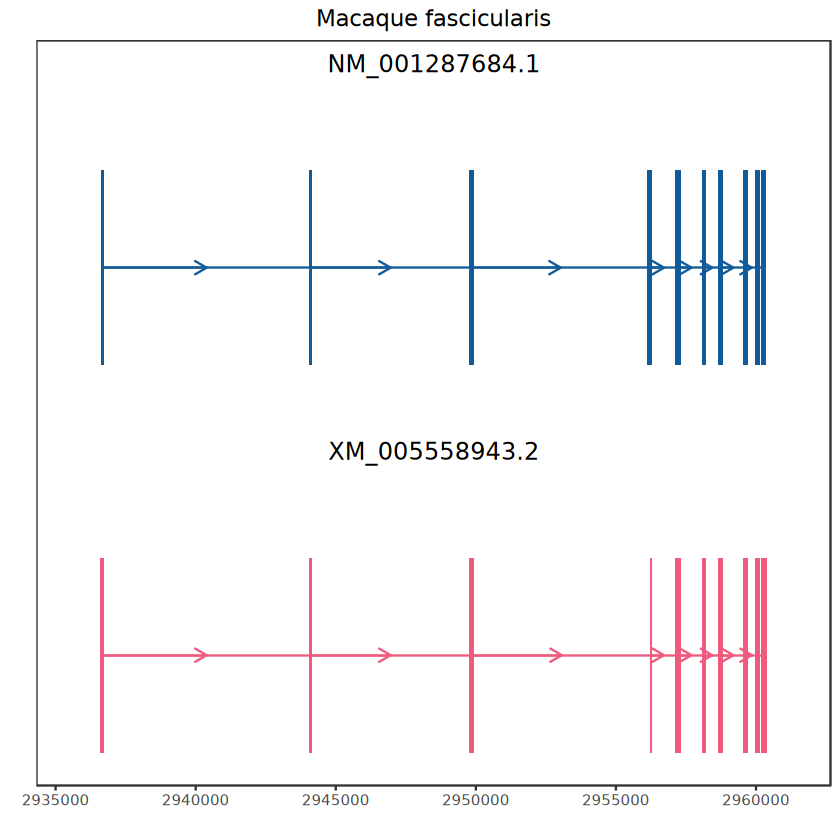

`summarise()` has grouped output by 'transcript_name'. You can override using
the `.groups` argument.


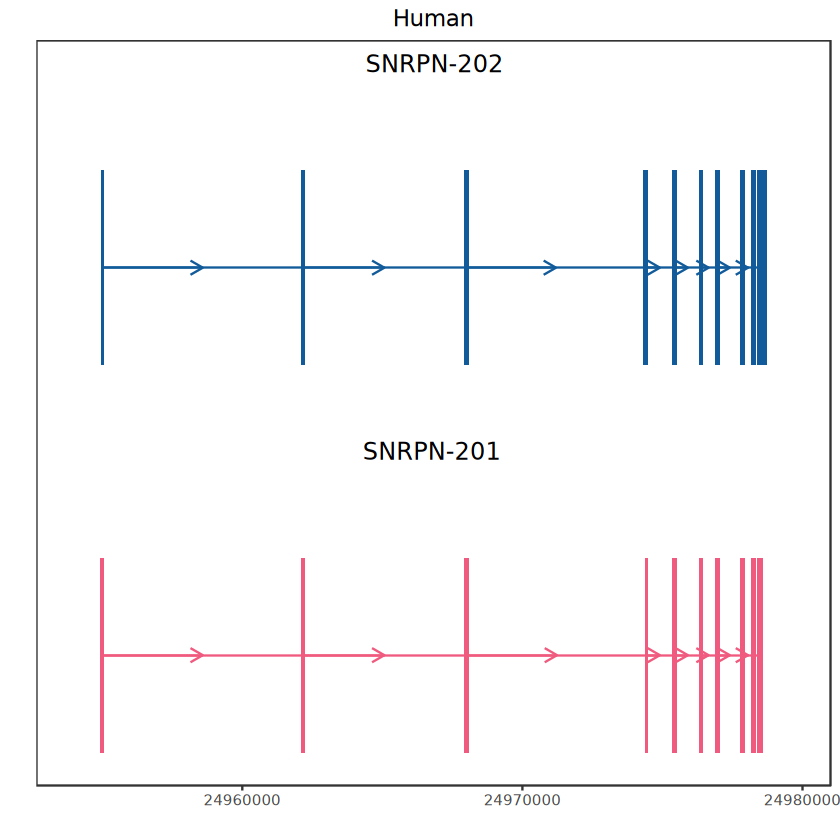

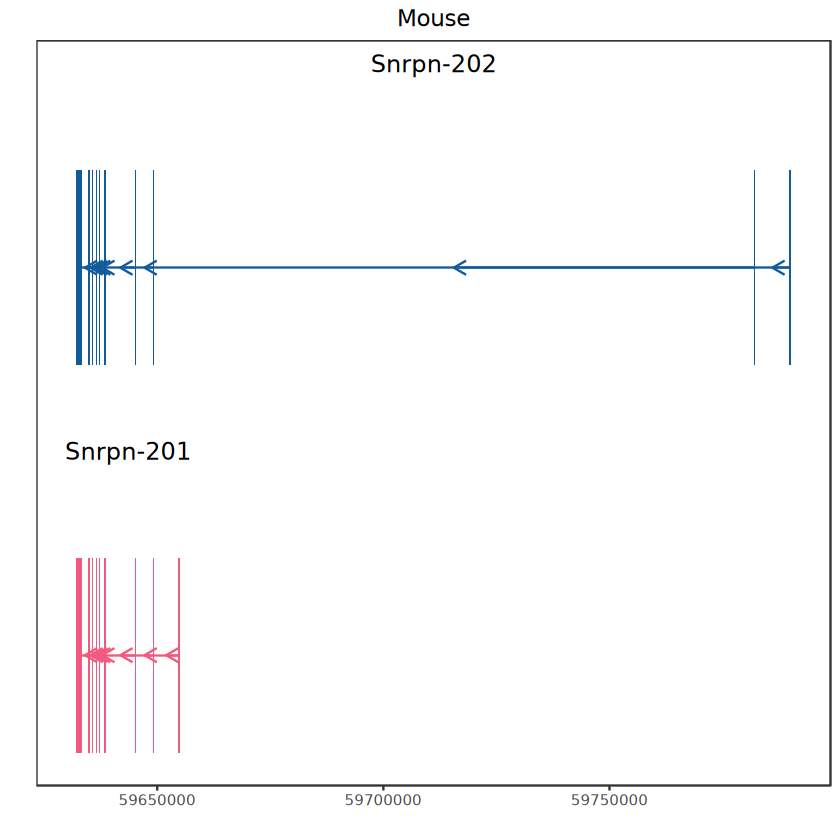

file saved to result/figure5/SNRPN-cross_species_sliced_compare_25_03_24.pdf



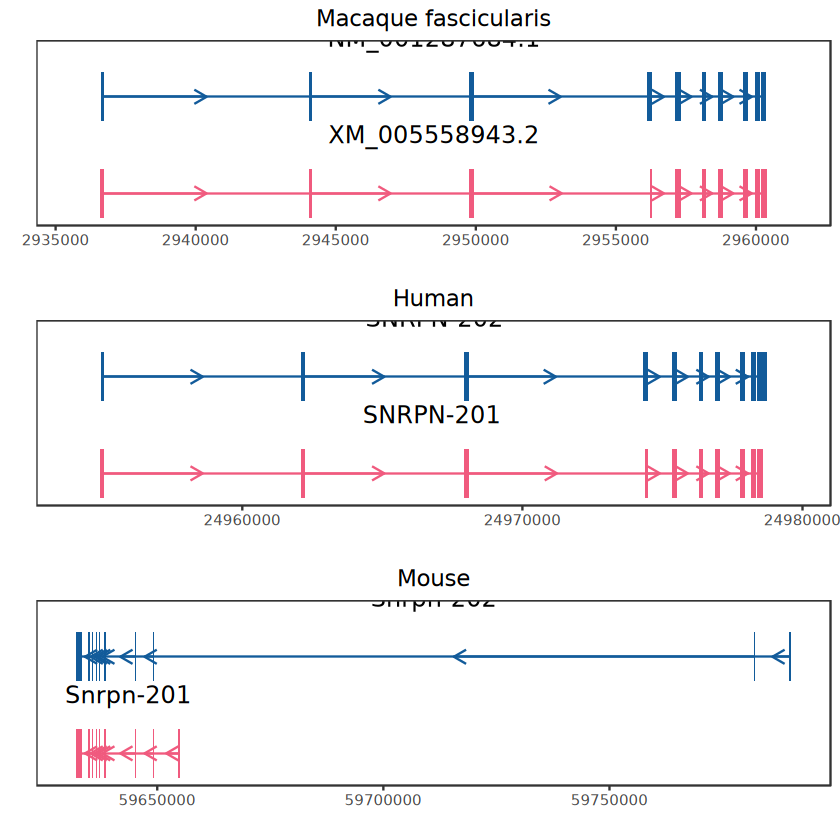

In [1102]:
#"ENST00000346403","ENST00000390687"
#"CDC42b" "CDC42u"
geneex = "SNRPN"
mycolor = c("#F05A7E","#125B9A")
gtfdf = as.data.frame(gtf[gtf$gene_id == geneex & gtf$transcript_id %in% c("XM_005558943.2","NM_001287684.1"),])
gtfdf$transcript_name = factor(gtfdf$transcript_id,levels = c("XM_005558943.2","NM_001287684.1"))
groupid = "Macaque fascicularis"
pc1 = Txrefplot(gtfdf,groupid,mycolor)
pc1

hubtrans = c("ENST00000346403.10","ENST00000390687.9")
gtfdf.hp.hub = as.data.frame(gtf.hp[gtf.hp$gene_name == "SNRPN" & gtf.hp$transcript_id %in% hubtrans,])
gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = c("SNRPN-201","SNRPN-202")) 
#gtfdf.hp.hub$transcript_name = factor(gtfdf.hp.hub$transcript_name,levels = unique(gtfdf.hp.hub$transcript_name)) 
groupid = "Human"
pc2 = Txrefplot(gtfdf.hp.hub,groupid,mycolor)
pc2
gtfdf.ms.hub = as.data.frame(gtf.ms[gtf.ms$gene_name == "Snrpn",])
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub = gtfdf.ms.hub[!is.na(gtfdf.ms.hub$transcript_name),]
#unique(gtfdf.ms.hub$transcript_name)
gtfdf.ms.hub$transcript_name = factor(gtfdf.ms.hub$transcript_name,levels = unique(gtfdf.ms.hub$transcript_name)) 
groupid = "Mouse"
pc3 = Txrefplot(gtfdf.ms.hub,groupid,mycolor)
pc3
pct = ggarrange(pc1,pc2,pc3,ncol = 1)
pct
ggexport(pct,filename = "result/figure5/SNRPN-cross_species_sliced_compare_25_03_24.pdf",width = 6,height = 6)

In [ ]:
geneex = "MYL6"
fsraw.cor.hub = fsraw.cor[!fsraw.cor$subclass %in% c("PV_CHC","VLMC"),]
grtdfl = BuildPlotBed(fsraw.cor.hub,longbed,"subclass",geneex,NULL)
grtdfl = grtdfl[grtdfl$transcript_id %in% c("MYL6-WeiLab-1","MYL6-WeiLab-2"),]
grtdfl = grtdfl %>% group_by(readid) %>% filter(n()> 1)
grtdfl$group = factor(grtdfl$group,levels = suborder)
pci = tryCatch(IsoformReadPlot(gtf, grtdfl,geneex,onlyhub = T), error = function(e) NULL)
pci
ggexport(pci,filename = "result/figure5/dtu_case_ls_disease_MYL6_gene_readsplice_24_11_21.pdf",
           width = 5,height = 10)

In [304]:
SpCasePlot = function(fsraw.cor,geneex,hubtrans,ptsize = 1,mycolor,downsample = 0){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex,]
    if(downsample != 0){
        mkdf = mkdf[sample(1:nrow(mkdf),size = as.integer(downsample*nrow(mkdf)),replace = F),]
    }
    # if(nrow(mkdf) > 3000){
    #     mkdf = mkdf[sample(1:nrow(mkdf),size = 3000,replace = F),]
    # }
    mkdf$transtype = MySplit(mkdf$transcript_id,"-",1)
    mkdf[mkdf$transtype != MySplit(mkdf$gene_id,"-",1),]$transcript_id = 
    paste0(mkdf[mkdf$transtype != MySplit(mkdf$gene_id,"-",1),]$gene_id,"-",
           mkdf[mkdf$transtype != MySplit(mkdf$gene_id,"-",1),]$transcript_id)
    hubtrans = hubtrans[hubtrans %in% mkdf$transcript_id]
    mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
    # mkdf.st = mkdf %>% group_by(transcript_id) %>% summarise(count = length(readid))
    # mkdf.st = mkdf.st[order(mkdf.st$count),]
    # transorder = unique(mkdf.st$transcript_id)
    mkdf$transcript_id = factor(mkdf$transcript_id,levels = hubtrans)
    mkdf = mkdf[order(-as.numeric(mkdf$transcript_id)),]
    #mkdf = mkdf[order(mkdf$transcript_id),]
    
    pmkpti1 = ggplot() +
        geom_segment(data = edgesdf, 
                   aes(x = x1, y = y1, xend = x2, yend = y2,color = subcortical),
                   size = 0.2,alpha = 1) +
      geom_point(data = mkdf,
                 aes(x,y,fill = transcript_id),shape = 21,size = ptsize,stroke = NA) + 
      # geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2,color = areatr),
      #            size = 0.5,alpha = 0.75) + 
     # scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~layer,nrow = 2) 

      theme_void() +
      #scale_fill_discreterainbow() +
      scale_color_flatui() +
      scale_fill_manual(values = mycolor) +
      #scale_color_manual(values = mycolor) +
      #scale_color_flatui() +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 8)) +
      guides(color = "none",
            fill = guide_legend(override.aes = list(size=6),nrow = 2),size = 7) +
      scale_y_reverse() + scale_x_reverse()
    return(pmkpti1)
}
#head(subcoran)
pref = qread("../ref/area_figure_an.qs")
subcoran = unique(fsraw.cor[,c("region","subcortical")])
edgesdf = pref$areaedges
edgesdf[edgesdf$areaid == "1/2",]$areaid = "1|2"
edgesdf = merge(edgesdf,subcoran,by.x = "areaid",by.y = "region")
mycolor = distinctColorPalette(length(unique(edgesdf$subcortical)))
names(mycolor) = unique(edgesdf$subcortical)


In [307]:
rgb(189,131,199,maxColorValue = 255)
rgb(182,210,161,maxColorValue = 255)

rgb(240,90,126,maxColorValue = 255)
rgb(18,91,154,maxColorValue = 255)
c("CDC42-FS-1","NM_001283401.1")

[1] "#BD83C7"

[1] "#B6D2A1"

[1] "#F05A7E"

[1] "#125B9A"

[1] "CDC42-FS-1"     "NM_001283401.1"

In [324]:
mycolor =  c('#BD83C7','#B6D2A1')
geneex = "MYL6"
hubtrans = c("MYL6-WeiLab-1","MYL6-WeiLab-2")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 1,mycolor,0.2)
ggexport(pci,filename = "result/figure5/MYL6-spatial_reads_point_25_03_18.pdf", width = 4,height = 6)

file saved to result/figure5/MYL6-spatial_reads_point_25_03_18.pdf



In [325]:
mycolor =  c('#125B9A','#F05A7E')
geneex = "CDC42"
hubtrans = c("CDC42-NM_001283401.1","CDC42-WeiLab-1")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 1,mycolor,0.2)
ggexport(pci,filename = "result/figure5/CDC42-spatial_reads_point_25_03_18.pdf", width = 4,height = 6)

file saved to result/figure5/CDC42-spatial_reads_point_25_03_18.pdf



In [314]:
#srtt = qread("data/meta_cell_ngs/umap_srt_combined_with_isoform_24_10_24.qs")
srtt = qread("data/meta_cell_ngs/umap_srt_combined_with_isoform_withspliced_forvelocity_n10_24_11_12.qs")

In [315]:
library(scCustomize)
DefaultAssay(srtt) = "ISOFORM"
isodf = GetAssayData(srtt,assay = "ISOFORM")
umapdf = as.data.frame(srtt@reductions$umap@cell.embeddings)
library(ggpointdensity)
featurei = c("GRIP1-XM-015431169.1","GRIP1-XM-015431173.1")
Feature_Density = function(umapdf,isodf,featurei){
    pci3 = list()
    for(i in 1:length(featurei)){
        # library(ggpointdensity)
        isodfi = isodf[featurei[i],]
        isodfi1 = names(isodfi[isodfi>0])
        umapdf.back = umapdf[!rownames(umapdf) %in% isodfi1,]
        umapdf.plot = umapdf[isodfi1,]
        pci3i = ggplot() +
            geom_point(data = umapdf.back,aes(x = umap_1,y = umap_2),color = "grey") +
            geom_pointdensity(data =  umapdf.plot,aes(x = umap_1,y = umap_2),size = 0.1) + NoLegend() +
            scale_color_viridis(option = "A") + theme_void() + ggtitle(featurei[i])
        # pci3i = plot_density(srtt,features = featurei[i],
        #             pal = "magma",size = 0.2,reduction = "umap") + NoLegend() +
        # ggtitle(featurei[i]) + theme_void() + coord_fixed()
        pci3[[i]] = pci3i
    }
    pci3 = ggarrange(plotlist = pci3,common.legend = T,legend = "right")
    pci3
    return(pci3)
}
#pal <- viridis(n = 10, option = "D")
#Plot_Density_Custom(seurat_object = srtt, features = "CDC42-NM-001283401.1",cols = pal)
#Plot_Density_Custom(seurat_object = srtt, features = "CDC42-CDC42-WeiLab-1",cols = pal)
#FeaturePlot(srtt,features = c("COL5A2-MICALL1-WeiLab-1"),order = TRUE,pt.size = sn) + scale_color_viridis(option = "B")
#FeaturePlot(srtt,features = c("COL5A2-MICALL1-WeiLab-2"),order = TRUE,pt.size = sn) + scale_color_viridis(option = "B")

In [323]:
pci = Feature_Density(umapdf, isodf, featurei = c("MYL6-MYL6-WeiLab-1","MYL6-MYL6-WeiLab-2"))
ggexport(pci,filename = "result/figure5/MYL6-single_cell_UMAP_25_03_18.pdf", width = 6,height = 3)

file saved to result/figure5/MYL6-single_cell_UMAP_25_03_18.pdf



class subclass gene_id 1         2         groupid geneidn
1 GABA  PVALB    PDE4B   0.8181818 0.1363636 13      1      
2 GABA  RELN     PDE4B   1.0000000 0.0000000 11      1      
3 GABA  SST      PDE4B   0.7611940 0.1791045 14      1      
4 GABA  VIP_RELN PDE4B   0.4666667 0.4666667 12      1      
5 GLU   L2       PDE4B   0.6666667 0.1739130  1      1      
6 GLU   L2/3     PDE4B   0.8085106 0.1063830  2      1

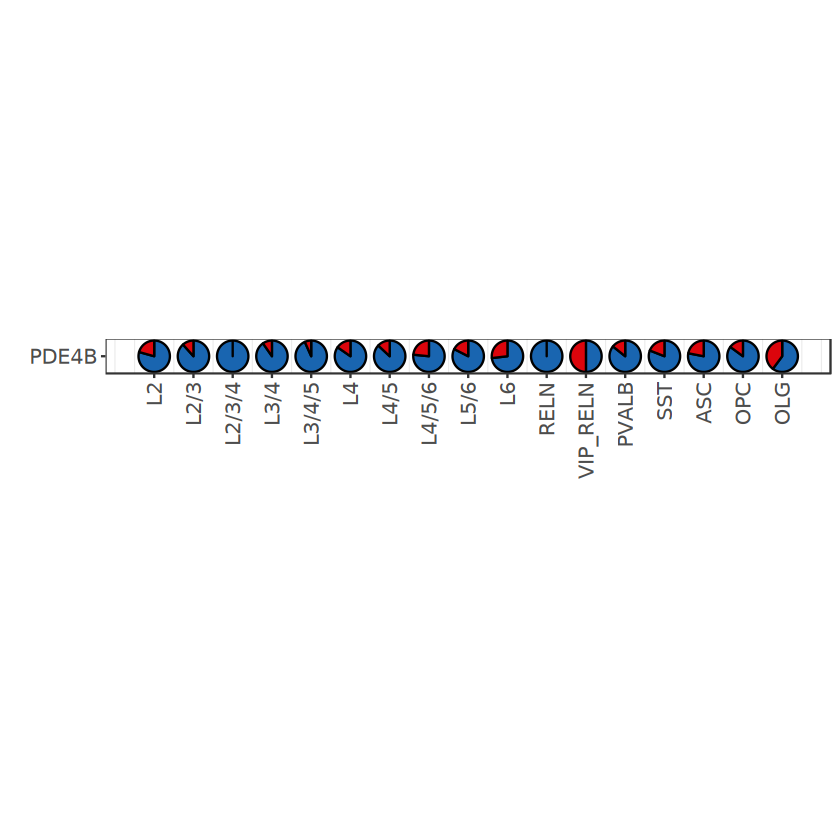

In [540]:
#MYL6 pie plot
caseg = "PDE4B"
mycolor =  c('#BD83C7','#B6D2A1')
isosigi = rbind(isosigls$subclass,isosigls$layer,isosigls$lobe,isosigls$subcortical)
isosigi = isosigi[isosigi$sig != "N",]
isosigi2 = rbind(isosigls$subclass,isosigls$layer,isosigls$lobe,isosigls$subcortical)
isosigi2 = isosigi2[isosigi2$meanrelative > 0.1,]

casecti = casect[casect$gene_id %in% caseg & casect$transcript_id %in% isosigi2$transcript_id,]

casecti = casecti[casecti$genecount > 10,]
casecti = casecti[!casecti$subclass %in% c("PV_CHC"),]

casecti = casecti %>% group_by(gene_id) %>% mutate(id = as.character(as.numeric(as.factor(transcript_id))))
casecti$gene_tran = paste0(casecti$gene_id,"-",casecti$id)
library(scatterpie)
casectl = dcast(casecti,class+subclass+gene_id~id,value.var = "rate")
casectl[is.na(casectl)] = 0
casectl = casectl[order(casectl$class,casectl$subclass),]
casectl$groupid = as.numeric(factor(casectl$subclass,levels = suborder[suborder %in% casectl$subclass]))
casectl$geneidn = as.numeric(factor(casectl$gene_id,levels = caseg))
head(casectl)

library(patchwork)
ison = casecti %>% group_by(gene_id) %>% summarise(transn = length(unique(transcript_id)))
ison = max(ison$transn)
casectl$sig = 'N'
casectl[paste0(casectl$subclass,casectl$gene_id) %in% paste0(isosigi$areatr,isosigi$gene_id),]$sig = "Y"
#caseg = c("INTU",'DNAJC7',"TUSC3","GRIP1","CACNB4","FAM173A","KLC1","MPG","MTG2","EIF5A","ARID4A","SIVA1","IDH3B")
#caseg = c("MYL6",'NTRK2',"DBNDD2","DDRGK1","ARPP19","ARPP21")
casectl$gene_id = factor(casectl$gene_id,levels = caseg)
plt = ggplot() + 
      geom_scatterpie(data = casectl[casectl$gene_id %in% caseg, ],
                      aes(x = groupid, y = geneidn, group = groupid,
                                           r = 0.4),
                      cols=colnames(casectl)[4:(4+ison-1)]) + 
      coord_fixed() +
      scale_x_continuous(breaks = c(1:length(unique(casectl$subclass))),labels = suborder[suborder %in% casectl$subclass]) +
      scale_y_continuous(breaks = c(1:length(caseg)),labels = caseg) +
      scale_color_manual(values = c("black")) +
      # geom_smooth(data = tem2, aes(x=x, y=y), se = F, method = 'loess',color = "black") +
      #scale_fill_manual(values = mycolor) +
      scale_fill_discreterainbow() +
      #annotate("text", x = 8, y = 7, label = caseg[i], hjust = 1.1, vjust = 1.1, size = 5, angle = 90) +
      ylab("") + xlab("") +
      theme_bw() + theme(legend.position="none",axis.text = element_text(size = 12),panel.grid.major = element_blank(),
                         axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
                        strip.background =element_rect(fill="white"))
plt
#ggexport(plt,filename = "result/figure5/MYL6_subclass_isoform_rate_stat_pie_25_03_16.pdf",width = 6,height = 2)

In [ ]:
asd.dtu = d2[abs(d2$DTU.ASD.Value)>1 & d2$DTU.ASD.FDR < 0.05,]
asd.dtu = asd.dtu[!is.na(asd.dtu$external_gene_id),]
#head(asd.dtu)
isosigt = isosigls$subclass
isosigt = isosigt[isosigt$sig != "N" & isosigt$areatr %in% c("ASC","OPC"),]
#isosigt = dtumkdf.hub
isosigt = isosigt[isosigt$gene_id %in% asd.dtu$external_gene_id ,]
#isosigt = isosigt[isosigt$gene_id %in% refgdf[refgdf$source %in% c("ASD.Buxbaum","ASD.Talkowski","ASD.GWAS"),]$gene_id,]
unique(isosigt$gene_id)
table(isosigt$areatr)

In [ ]:
isosigt = isosigls$layer
isosigt = isosigt[isosigt$sig != "N" & isosigt$areatr %in% c("l4"),]
isosigt = isosigt[isosigt$gene_id %in% refgdf[refgdf$source %in% c("NDD.Talkowski","DDD.Retterer"),]$gene_id ,]
unique(isosigt$gene_id)
table(isosigt$areatr)

In [ ]:
isosigt = isosigls$subclass
isosigt = isosigt[isosigt$sig != "N",]
#isosigt = isosigt[isosigt$gene_id %in% asd.dtu$external_gene_id ,]
isosigt = isosigt[isosigt$gene_id %in% refgdf[refgdf$source %in% c("ASD.DTU","BD.DTU","SCZ.DTU"),]$gene_id,]
unique(isosigt$gene_id)

In [ ]:
d2[d2$external_gene_id %in% c("MYL6","CIRBP","CLTA","RPS24","NTRK2","INTS1","SRSF10") & abs(d2$DTU.ASD.Value)>0.5,
   c("external_gene_id","ensembl_transcript_id","DTU.ASD.Value")]
#MYL6-207 increased ENST00000547649 means ASC MYL6-WL-2 increased or ASC cell decreased
gtf.hub = gtf[gtf$transcript_id == "MYL6-WeiLab-2" & gtf$type == "exon",]
gtf.hub

#### Summary data

In [ ]:
library(writexl)
write_xlsx(data6s,"result/figure6_other_cmp/table_s6_disease_calculation.xlsx")